# **Text Mining Group Project 23-24**

## **Group 3**

**Elements**:
- Afonso Gorjão | 20230575 | 20230575@novaims.unl.pt
- Diogo Almeida | 20230737 | 20230737@novaims.unl.pt
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- Pedro Carvalho | 20230554 | 20230554@novaims.unl.pt

**Index**
* [1. Library imports](#library-imports)
* [2. Constants](#constants)
* [3. Data Imports](#data-imports)
* [4. Data Exploration Before Pre-Processing](#data-exploration-before-preproc)
* [5. Data Pre-processing](#data-preprocessing)
    * [5.1. Copies of Data](#copies)
    * [5.2. Merging Info and Reviews](#)
    * [5.3. Dropping Duplicates](#)
    * [5.4. Reindexing](#)
    * [5.5. Replacing Pseudo-Nans](#)
    * [5.6. Custom Transformations](#)
    * [5.7. Text Cleaning before NER](#)
    * [5.8. Handling Missing Values](#)
    * [5.9. Language Detection](#)
    * [5.10. Additional #1: Translating Rare Languages](#)
    * [5.11. Additional #2: NER](#)
    * [5.12. Text Cleaning after NER](#)
    * [5.13. Removing Stop Words](#)
    * [5.14. Stemming](#)
    * [5.15. Lemmatization](#)
    * [5.16. Train-Test Split](#)
* [6. Data Exploration Post Pre-Processing](#data-exploration-post-preproc)
* [7. Feature Engineering](#feature-engineering)
    * [8.1. TF-IDF](#tf-idf)
    * [8.2. GloVe](#glove)
    * [8.3. Additional #1: XLM-RoBERTa Feature Extraction](#roberta-fe)
    * [8.4. Additional #2: mBERT Feature Extraction](#mbert-fe)
* [9. Model Development](#model-dev)
    * [9.1. Rule-Based Model](#rule-based)
    * [9.2. KNN](#knn)
    * [9.3. Logistic Regression](#lr)
    * [9.4. Random Forest](#rf)
    * [9.5. Comparing Predictions](#comp-pred)
    * [9.6. Ungrouped Data](#ungrouped-data)
    * [9.7. Additional #1: XLM-RoBERTa Fine Tuning](#robert-ft)
    * [9.8. Additional #2: mBERT Fine Tuning](#mbert-ft)
    * [9.9. Bonus Additional #3: Text summarization before Classification](#text-summ)
    * [9.10. Extending Rule Based Model](#ext-rule-based)
* [10. Model Comparison](#model-comp)
    * [10.1. Fixing Predictions](#)
    * [10.2. Threshold Tuning](#)
    * [10.3. Cross-Validating Best Models](#)
* [11. Plug-and-play Solution](#plug-n-play)

## **Library Imports**<a id='library-imports'></a>

In [1]:
# libraries not pre-installed in colab's kernel

!pip install fasttext
!pip install deep-translator
!pip install datasets
!pip install accelerate -U
!pip install umap-learn
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227143 sha256=8c19b0c6b4d28dbb475da8fa9a784feba605ad9bcfd4e5e771e55725a6dee82d
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: re

In [2]:
# mount drive if using colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import gc
from copy import deepcopy
import random
import time
import re
import string
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from num2words import num2words

import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import spacy

from bs4 import BeautifulSoup

import fasttext
from deep_translator import GoogleTranslator  # https://github.com/nidhaloff/deep-translator

import gensim
import gensim.downloader

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

import umap.umap_ as umap

import transformers
from transformers import pipeline, set_seed
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import datasets
from datasets import DatasetDict, load_metric
from datasets import Dataset as HFDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchtext.vocab as vocab
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.transforms import ToTensor
import torchtext.vocab as vocab


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
transformers.set_seed(SEED)

## **Constants**<a id='constants'></a>

In [3]:
RAW_DATA_DIR = os.path.join('corpora', 'raw-data')

TRAIN_INFO_PATH = os.path.join(RAW_DATA_DIR, 'train.xlsx')
TRAIN_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'train_reviews.xlsx')

TEST_INFO_PATH = os.path.join(RAW_DATA_DIR, 'test.xlsx')
TEST_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'test_reviews.xlsx')


# *************************
# LOCAL OR COLAB
# *************************

colab = False

TRAIN_PREPROCESSED_PATH = os.path.join('corpora', 'train_preprocessed.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/train_preprocessed.pkl'
TEST_PREPROCESSED_PATH = os.path.join('corpora', 'test_preprocessed.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/test_preprocessed.pkl'
TRAIN_PROPERTIES_WITH_REVIEWS = os.path.join('corpora', 'train_properties_with_reviews.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/train_properties_with_reviews.pkl'
TEST_PROPERTIES_WITH_REVIEWS = os.path.join('corpora', 'test_properties_with_reviews.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/test_properties_with_reviews.pkl'

# XY prefix pertains to the train and test data after splitting the original 'train' data
XY_TRAIN_PREPROCESSED_PATH = os.path.join('corpora', 'Xy_train_preprocessed.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/Xy_train_preprocessed.pkl'
XY_TEST_PREPROCESSED_PATH = os.path.join('corpora', 'Xy_test_preprocessed.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/Xy_test_preprocessed.pkl'
XY_TRAIN_INFO_PATH = os.path.join('corpora', 'Xy_train_info.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/Xy_train_info.pkl'
XY_TEST_INFO_PATH = os.path.join('corpora', 'Xy_test_info.pkl') if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/Xy_test_info.pkl'

GLOVE_CACHE_DIR =  '.vector_cache' if not colab else '/content/drive/MyDrive/.vector_cache'

# for fine tuning transformers
OUTPUT_DIR = 'content/drive/MyDrive/outputs'

## **Data Imports**<a id='data-imports'></a>

In [ ]:
train_info_raw = pd.read_excel(TRAIN_INFO_PATH)
train_reviews_raw = pd.read_excel(TRAIN_REVIEWS_PATH)

print(f'Train info shape: {train_info_raw.shape}')
display(train_info_raw.head())
print(f'\nTrain reviews shape: {train_reviews_raw.shape}')
display(train_reviews_raw.head())

# also want to check the test data to ensure compatibility
test_info_raw = pd.read_excel(TEST_INFO_PATH)
test_reviews_raw = pd.read_excel(TEST_REVIEWS_PATH)

print(f'\nTest info shape: {test_info_raw.shape}')
display(test_info_raw.head())
print(f'\nTest reviews shape: {test_reviews_raw.shape}')
display(test_reviews_raw.head())

assert test_info_raw.columns.tolist() == train_info_raw.columns.tolist()[:-1], 'Test and train info columns do not match'
assert test_reviews_raw.columns.tolist() == train_reviews_raw.columns.tolist(), 'Test and train reviews columns do not match'

# time to load: ~30s

Train info shape: (6248, 4)


index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  
0                Alojamento Local Registro: 20835/AL         0  
1  I am friendly host, and I will try to always b...         1  
2  I am a social person liking to communicate, re...         1  
3  Hello!_x000D_\nI m Portuguese and i love to me...         0  
4  Nous sommes une famille avec deux enfants de 1...         0


Train reviews shape: (361281, 2)


index                                           comments
0      1  this is a very cozy and comfortable house to s...
1      1                                          good<br/>
2      1  My first hostel experience, and all I have to ...
3      1  Das Hostel war neu und deshalb funktionierte a...
4      1  It was fine for a dorm, but I think for the pe...


Test info shape: (695, 3)


index                                        description  \
0      1  <b>The space</b><br />Apartment located in the...   
1      2  IMPORTANT: In response to COVID-19, this prope...   
2      3  Bright, beautiful, and spacious. This four-bed...   
3      4  Charming Apartment Close to the Bay of Cascais...   
4      5  Se procura umas férias perto da praia, casino ...   

                                          host_about  
0  Gosto de viajar, de conhecer pessoas, gosto de...  
1  We are the be@home Team!\n\nYou can count on u...  
2  Hi there!\n\nWe're GuestReady, a professional ...  
3                                                 :)  
4  Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


Test reviews shape: (41866, 2)


index                                           comments
0      1  Thank you very much Antonio ! All has been per...
1      1  Very nice appartment in the old town of Lissab...
2      1  When travelling we're looking for kids friendl...
3      1  We've been in Lisbon in march 2013 (3 adults a...
4      1  Our host Antonio was very helpful with informa...

## **Data Exploration Before Pre-Processing**<a id='data-exploration-before-preproc'></a>

- **Making Copies of the Data**

In [ ]:
# during exploration we will transform the data (very slightly)
# we want to make them in a copy in order to not
# alter the original data
train_info = train_info_raw.copy()
train_reviews = train_reviews_raw.copy()
test_info = test_info_raw.copy()
test_reviews = test_reviews_raw.copy()

- **Missing Values (and pseudo-NaNs)**

In [ ]:
# there are non-null values that we considered as nulls
# e.g. blank strings, 'Nan' words, docs only composed
# of punctuation or just the same character

def replace_pseudo_nans(df):

    new_df = df.replace(r'^\s*$', np.nan, regex=True)  # r'^\s*$' matches strings that are empty or contain only whitespace
    new_df = new_df.replace('Nan', np.nan)
    new_df = new_df.replace('Nul', np.nan)
    new_df = new_df.replace(f"^[{re.escape(string.punctuation)}]+$", np.nan, regex=True)  # solely composed of punctuation
    new_df = new_df.replace(r'^(.)\1*$', np.nan, regex=True)  # solely composed of 1 or more same characters, i.e. '.', or '!!!', or 'A' (some emojis but the big majority is indeed random)
    return new_df

In [ ]:
# there seems to be blank spaces not being identified as nulls

print('Before pseudo-nan replacement:')

print('Train info missing values:')
print(train_info.isna().sum())
print('\nTrain reviews missing values:')
print(train_reviews.isna().sum())
print('\nTest info missing values:')
print(test_info.isna().sum())
print('\nTest reviews missing values:')
print(test_reviews.isna().sum())

print('\n--------------------------------\n')
print('After pseudo-nan replacement:')
train_info = replace_pseudo_nans(train_info)
train_reviews = replace_pseudo_nans(train_reviews)
test_info = replace_pseudo_nans(test_info)
test_reviews = replace_pseudo_nans(test_reviews)

print('Train info missing values:')
print(train_info.isna().sum())
print('\nTrain reviews missing values:')
print(train_reviews.isna().sum())
print('\nTest info missing values:')
print(test_info.isna().sum())
print('\nTest reviews missing values:')
print(test_reviews.isna().sum())

# ... given that these values are actual missing values the data will be analysed
# as it is AFTER pseudo nan replacement with NaN for simplicity reasons as they make
# up less than 1%

Before pseudo-nan replacement:
Train info missing values:
index          0
description    0
host_about     0
unlisted       0
dtype: int64

Train reviews missing values:
index       0
comments    2
dtype: int64

Test info missing values:
index          0
description    0
host_about     0
dtype: int64

Test reviews missing values:
index       0
comments    0
dtype: int64

--------------------------------

After pseudo-nan replacement:
Train info missing values:
index           0
description     0
host_about     73
unlisted        0
dtype: int64

Train reviews missing values:
index         0
comments    901
dtype: int64

Test info missing values:
index          0
description    0
host_about     9
dtype: int64

Test reviews missing values:
index         0
comments    130
dtype: int64


- **Duplicates**

In [ ]:
# are there duplicates?
print(f'Duplicate rows in train_info: {train_info.duplicated().sum()}')
print(f'Duplicate rows in train_reviews: {train_reviews.duplicated().sum()}')

print(f'\nDuplicate rows in test_info: {test_info.duplicated().sum()}')
print(f'Duplicate rows in test_reviews: {test_reviews.duplicated().sum()}')

# ... duplicate reviews:
print('\nSample of duplicates:')
display(test_reviews[test_reviews.duplicated(keep=False)].head(10))

# removing duplicates (only the reviews dfs have them)
train_reviews = train_reviews.drop_duplicates()
test_reviews = test_reviews.drop_duplicates()

# ... duplicates shall also be dropped as they provide no information
# on the data

Duplicate rows in train_info: 0
Duplicate rows in train_reviews: 253

Duplicate rows in test_info: 0
Duplicate rows in test_reviews: 35

Sample of duplicates:


index         comments
1622      42      Great place
1645      42      Great place
4165      79              NaN
4203      79              NaN
8843     155              NaN
8862     155             Good
8884     155             Good
8906     155              NaN
11302    178     Great place!
11416    178  Great location!

- **High-level Statistics**

In [ ]:
# is index unique in train_info?
assert train_info['index'].nunique() == train_info.shape[0], 'Index is not unique'
assert test_info['index'].nunique() == test_info.shape[0], 'Index is not unique'

print(f'Total no. of properties in train dataset: {train_info.shape[0]}')
print(f'Total no. of properties in test dataset: {test_info.shape[0]}')

Total no. of properties in train dataset: 6248
Total no. of properties in test dataset: 695


In [ ]:
# are there properties with reviews but without description?
assert set(train_info['index']).issuperset(set(train_reviews['index'])), 'At least one Train property with reviews but no info.'
assert set(test_info['index']).issuperset(set(test_reviews['index'])), 'At least one Test property with reviews but no info.'

# ... all properties in the reviews dfs exist in the info dfs

Unlisted: 1708 (27.34%)
Listed: 4540 (72.66%)



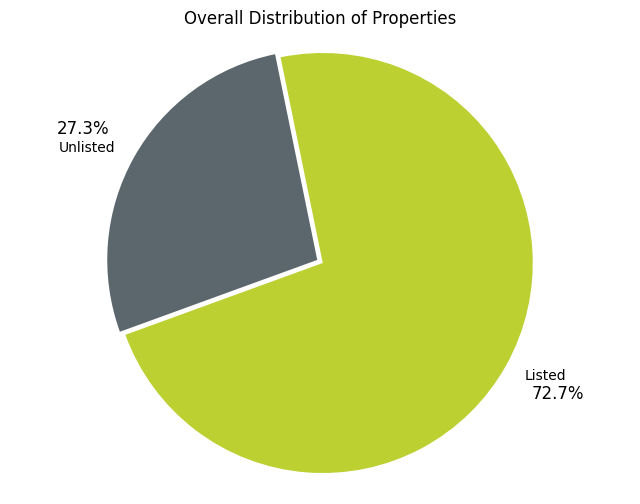

In [ ]:
# listed vs unlisted

unlisted_train = train_info['unlisted'].value_counts()
print(f'Unlisted: {unlisted_train[1]} ({unlisted_train[1] / train_info.shape[0] * 100:.2f}%)')
print(f'Listed: {unlisted_train[0]} ({unlisted_train[0] / train_info.shape[0] * 100:.2f}%)\n')

# percentages for 'unlisted' column with super host
overall_percentage_0 = (train_info['unlisted'].value_counts(normalize=True) * 100).get(0, 0)
overall_percentage_1 = (train_info['unlisted'].value_counts(normalize=True) * 100).get(1, 0)

# labels for the pie chart
labels = ['Listed', 'Unlisted']
sizes = [overall_percentage_0, overall_percentage_1]
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)]
explode = (0.03, 0)

# pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                   shadow=False, startangle=200, textprops=dict(color="black"),
                                   pctdistance=1.28)

# setting percentages as text annotations outside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Overall Distribution of Properties')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show pie chart
plt.show()

# ... some data imbalance, might need to address this later

For properties WITH AT LEAST 1 review:

unlisted
0    3978
1     267
Name: count, dtype: int64

unlisted
0    0.937102
1    0.062898
Name: proportion, dtype: float64

--------------------------------------

For properties WITHOUT reviews:

unlisted
1    1441
0     562
Name: count, dtype: int64

unlisted
1    0.719421
0    0.280579
Name: proportion, dtype: float64



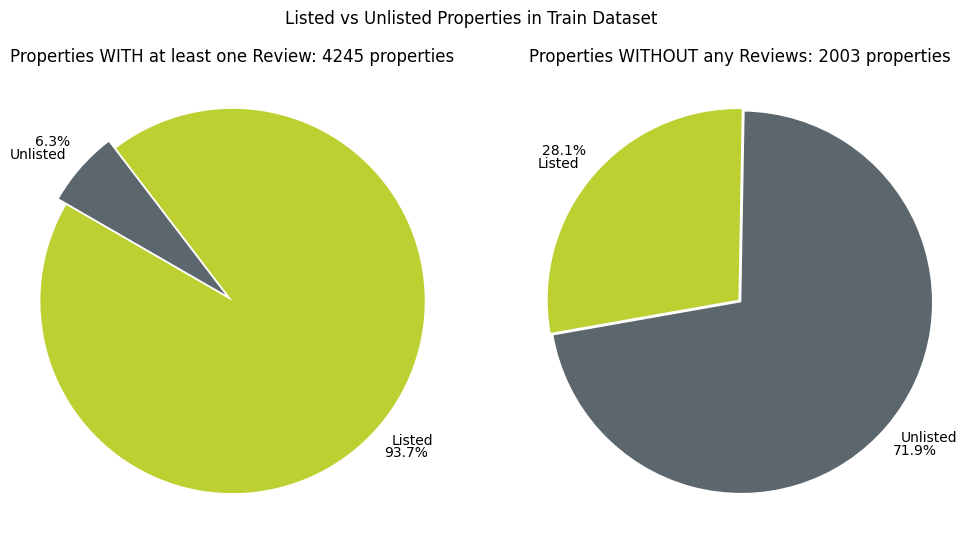

In [ ]:
# distribution of the labels over properties with no reviews

index_properties_with_reviews = set(train_reviews['index'])
train_info['has_comments'] = train_info['index'].apply(lambda x: int(x in index_properties_with_reviews))

# doing the same for the test set (will be used at the end of project)
index_properties_with_reviews_test = set(test_reviews['index'])
test_info['has_comments'] = test_info['index'].apply(lambda x: int(x in index_properties_with_reviews_test))

# this will be useful later on!
# with open('corpora/train_properties_with_reviews.pkl', 'wb') as file:
#     pickle.dump(list(index_properties_with_reviews), file)

# with open('corpora/test_properties_with_reviews.pkl', 'wb') as file:
#     pickle.dump(list(index_properties_with_reviews_test), file)

print('For properties WITH AT LEAST 1 review:\n')
print(train_info.loc[train_info['has_comments'] == 1, 'unlisted'].value_counts(0))
print()
print(train_info.loc[train_info['has_comments'] == 1, 'unlisted'].value_counts(1))

print('\n--------------------------------------\n')

print('For properties WITHOUT reviews:\n')
print(train_info.loc[train_info['has_comments'] == 0, 'unlisted'].value_counts(0))
print()
print(train_info.loc[train_info['has_comments'] == 0, 'unlisted'].value_counts(1))
print()

# ... i.e. properties with at least 1 review are more likely to remain listed

# Calculate the distribution for properties WITH reviews
with_reviews_counts = train_info.loc[train_info['has_comments'] == 1, 'unlisted'].value_counts(normalize=True) * 100
with_reviews_labels = with_reviews_counts.index
with_reviews_sizes = with_reviews_counts.values

# Calculate the distribution for properties WITHOUT reviews
without_reviews_counts = train_info.loc[train_info['has_comments'] == 0, 'unlisted'].value_counts(normalize=True) * 100
without_reviews_labels = without_reviews_counts.index
without_reviews_sizes = without_reviews_counts.values

# Define colors
labels = ['Listed', 'Unlisted']
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)]

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for properties WITH reviews
axes[0].pie(with_reviews_sizes, labels=labels, autopct='%1.1f%%', startangle=150, colors=colors, pctdistance=1.2, explode=(0.05, 0))
axes[0].set_title('Properties WITH at least one Review: 4245 properties')

# Pie chart for properties WITHOUT reviews
axes[1].pie(without_reviews_sizes, labels=labels[::-1], autopct='%1.1f%%', startangle=190, colors=colors[::-1], pctdistance=1.2, explode=(0.02, 0))
axes[1].set_title('Properties WITHOUT any Reviews: 2003 properties')

# Ensure equal aspect ratio for pie charts
for ax in axes:
    ax.axis('equal')

plt.suptitle('Listed vs Unlisted Properties in Train Dataset')
plt.show()

In [ ]:
# there are some nulls in host about
print(train_info.loc[train_info['host_about'].isnull(), 'unlisted'].value_counts())
print(train_info.loc[train_info['host_about'].isnull(), 'unlisted'].value_counts(1))

# ... similar proportions, i.e. does not seem to have discriminatory power

unlisted
0    54
1    19
Name: count, dtype: int64
unlisted
0    0.739726
1    0.260274
Name: proportion, dtype: float64


In [ ]:
# property reviews

def get_reviews_per_property(info_df, reviews_df, verbose=1):
    reviews_per_property = reviews_df['index'].value_counts()
    total_properties = info_df.shape[0]
    properties_with_reviews = reviews_per_property.shape[0]
    properties_without_reviews = total_properties - properties_with_reviews
    if verbose:
        print(f'Properties with reviews: {properties_with_reviews} ({properties_with_reviews / total_properties * 100:.2f}%)')
        print(f'Properties without reviews: {properties_without_reviews} ({properties_without_reviews / total_properties * 100:.2f}%)')

    if verbose:
        avg_reviews_per_property = reviews_per_property.mean()
        print(f'Average reviews per property: {avg_reviews_per_property:.2f}')
        print(f'Median reviews per property: {reviews_per_property.median():.0f}')
        print(f'Mode of reviews per property: {reviews_per_property.mode()[0]}')
        print(f'Standard deviation of reviews per property: {reviews_per_property.std():.2f}')

    return reviews_per_property

print('Train Dataset:')
reviews_per_property_train = get_reviews_per_property(train_info, train_reviews)

print('\nTest Dataset:')
reviews_per_property_test = get_reviews_per_property(test_info, test_reviews)

# ... maybe, for the properties without reviews we can the most common class?

Train Dataset:
Properties with reviews: 4245 (67.94%)
Properties without reviews: 2003 (32.06%)
Average reviews per property: 85.05
Median reviews per property: 48
Mode of reviews per property: 1
Standard deviation of reviews per property: 96.41

Test Dataset:
Properties with reviews: 475 (68.35%)
Properties without reviews: 220 (31.65%)
Average reviews per property: 88.07
Median reviews per property: 45
Mode of reviews per property: 1
Standard deviation of reviews per property: 102.03


In [ ]:
# are there properties with reviews but without host description?
missing_host_about_index = train_info[train_info['host_about'].isnull()]['index'].tolist()
train_reviews.loc[train_reviews['index'].isin(missing_host_about_index) & train_reviews['comments'].notnull(), :].shape

# ... yes, i.e. we can't drop the properties with no host about

(4532, 2)

<Figure size 650x500 with 0 Axes>

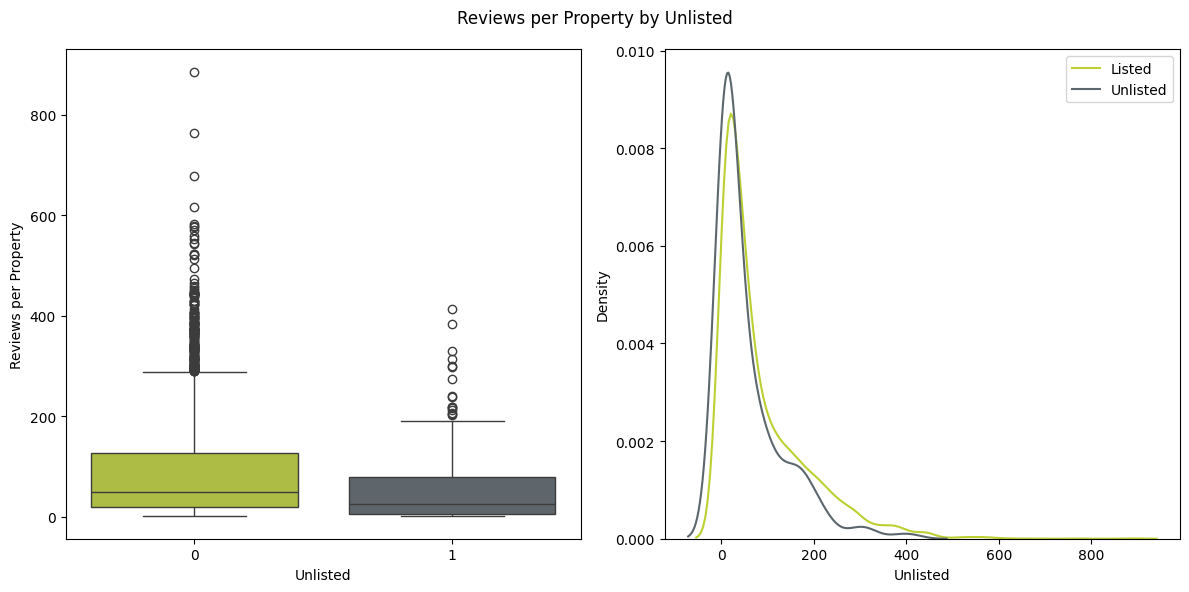

In [ ]:
# reviews per property vs. target

def get_label(property_idx, property_df = train_info):
    return property_df.loc[property_df['index'] == property_idx, 'unlisted'].values[0]

property_reviews, property_labels = [], []
for property_idx, nreviews in reviews_per_property_train.items():
    property_reviews.append(nreviews)
    property_labels.append(get_label(property_idx))

property_reviews = np.array(property_reviews)
property_labels = np.array(property_labels)

plt.figure(figsize=(6.5, 5))
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
plt.suptitle('Reviews per Property by Unlisted')

sns.boxplot(x=property_labels, y=property_reviews, palette=colors, ax=ax1)
ax1.set_xlabel('Unlisted')
ax1.set_ylabel('Reviews per Property')

sns.kdeplot(x=property_reviews[property_labels == 0], color=colors[0], ax=ax2, label='Listed')
sns.kdeplot(x=property_reviews[property_labels == 1], color=colors[1], ax=ax2, label='Unlisted')
ax2.set_xlabel('Unlisted')
ax2.set_ylabel('Density')

plt.legend()
plt.tight_layout()
plt.show()

# ... there seems to be a slight tendency for houses with more reviews to remain listed
# ... also it seems reviews with more than around 430 reviews are always remaining as listed

# very similar distributions it seems that number of reviews
# is not that helpful to discriminate the target for houses
# with at least one review

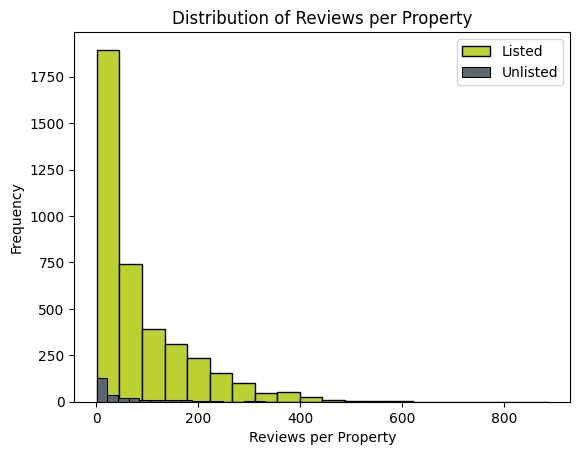

In [ ]:
# Separate reviews based on unlisted status
property_reviews_unlisted, property_reviews_listed = [], []
for property_idx, nreviews in reviews_per_property_train.items():
    label = get_label(property_idx)
    if label == 0:
        property_reviews_unlisted.append(nreviews)
    else:
        property_reviews_listed.append(nreviews)

# Create a figure and axis object
fig, ax = plt.subplots()
# Plot distribution for unlisted = 1 (unlisted)
sns.histplot(property_reviews_unlisted, ax=ax, label='Listed', color=(188/255, 208/255, 49/255), alpha=1, bins=20)
# Plot distribution for unlisted = 0 (listed)
sns.histplot(property_reviews_listed, ax=ax, label='Unlisted', color=(92/255, 103/255, 109/255), alpha=1, bins=20)

# Set labels and title
ax.set_xlabel('Reviews per Property')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Reviews per Property')

# Add legend
plt.legend()

# Show plot
plt.show()

# the above is better...

In [ ]:
# checkout houses will only one comment
one_review = []
for idx, nreviews in zip(reviews_per_property_train.index, reviews_per_property_train.values):
    if nreviews == 1:
        one_review.append(idx)

print(f"N. of houses with only 1 review: {len(one_review)}")
train_reviews.loc[train_reviews['index'].isin(one_review), :].sample(20)

N. of houses with only 1 review: 113


index                                           comments
263265   4507  I loved it. Depends on what you want… I was lo...
17386     325          Logement sympa à côté d’une superbe plage
140083   2391                                       Super séjour
228139   3905          Muito bom alojamento! <br/>Recomendo 100%
26724     474  The place was great - the WiFi needs to be fix...
149669   2550  Foram dias maravilhosos! Super recomendo essa ...
235897   4052  This rental is for two separate apartments whi...
212032   3595  Thankyou for the stay and your attentiveness. ...
162483   2729    Μέσα στην πόλη πολύ καθαρό με εξυπηρέτηση άψογη
28475     503  Truth has to be said, the apartment is stunnin...
309296   5385  The service, check-in, communication are excel...
126107   2154  Really good host that tried to make the stay a...
270357   4619  Uma semana bem passada num ambiente calmo e ac...
356478   6150  The setting, view, property and amenities are ...
40280     704  João Is an artist. He has designed the apartme...
5094       97  Its clean and good and train station infront o...
239542   4116  Superbe endroit très tranquille, paisible et u...
75693    1248  Great location and nice spot! Only down fall i...
264464   4535  title : Miscommunication and ripoff <br/>Pleas...
181664   3084  Communication was superb. I also liked the opt...

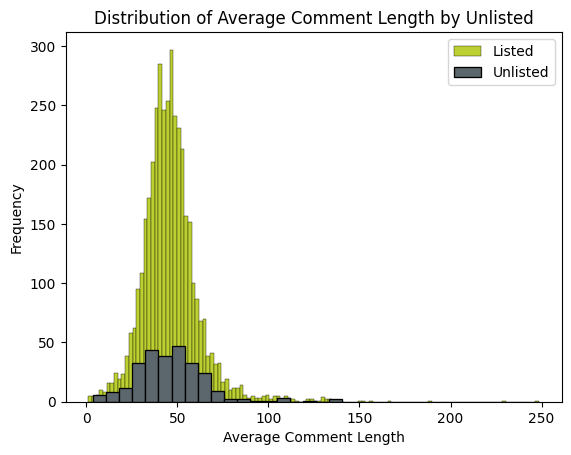

In [ ]:
# Merge the two dataframes on 'index'
merged_df = pd.merge(train_info, train_reviews, on='index')

# Calculate comment lengths
merged_df = merged_df.loc[merged_df['comments'].notnull(), :]  # only houses with at least one comment
merged_df['avg_comment_length'] = merged_df['comments'].str.split().apply(len)

# Group by 'index' and calculate the mean of 'comment_length' and take the first value of 'unlisted' as it's the same for each group
final_df = merged_df.groupby('index').agg({'unlisted': 'first', 'avg_comment_length': 'mean'}).reset_index()
final_df.set_index('index', inplace=True)
final_df['comment_count'] = merged_df['index'].value_counts()

# Rename columns
final_df = final_df.sort_values(by='index')

unlisted_0 = final_df[final_df['unlisted'] == 0]['avg_comment_length']
unlisted_1 = final_df[final_df['unlisted'] == 1]['avg_comment_length']

# Create a figure and axis object
fig, ax = plt.subplots()
# Plot distribution for unlisted = 0
sns.histplot(unlisted_0, ax=ax, label='Listed', color=(188/255, 208/255, 49/255), alpha=1)
# Plot distribution for unlisted = 1
sns.histplot(unlisted_1, ax=ax, label='Unlisted', color=(92/255, 103/255, 109/255), alpha=1)

# Set labels and title
ax.set_xlabel('Average Comment Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Average Comment Length by Unlisted')

# Add legend
plt.legend()

# Show plot
plt.show()

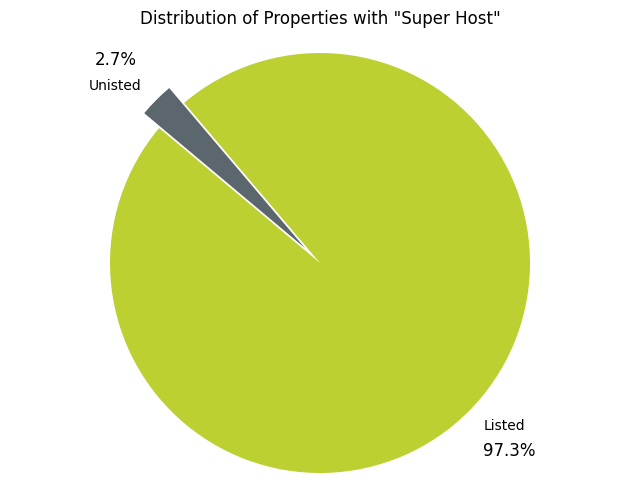

In [ ]:
filtered_df = merged_df[merged_df['comments'].str.contains("super host", case=False) | merged_df['description'].str.contains("super host", case=False) | merged_df['host_about'].str.contains("super host", case=False)]
unique_indices_with_superhost = filtered_df['index'].unique()
filtered_train_info = train_info[train_info['index'].isin(unique_indices_with_superhost)]

# Calculate the percentages for 'unlisted' column with super host
percentage_0 = (filtered_train_info['unlisted'].value_counts(normalize=True) * 100).get(0, 0)
percentage_1 = (filtered_train_info['unlisted'].value_counts(normalize=True) * 100).get(1, 0)

# Create labels for the pie chart
labels = ['Listed', 'Unisted']
sizes = [percentage_0, percentage_1]
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)]
explode = (0.1, 0)

# Create pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                   shadow=False, startangle=140, textprops=dict(color="black"),
                                   pctdistance=1.27)

# Set percentages as text annotations outside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Distribution of Properties with "Super Host"')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show pie chart
plt.show()

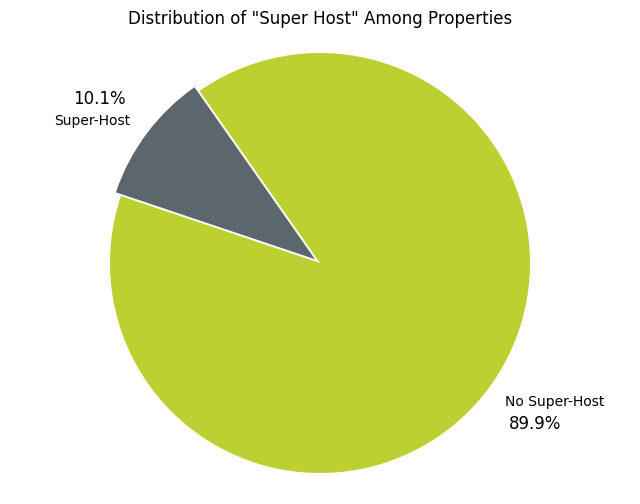

In [ ]:
superhost_count = filtered_train_info.shape[0]

# Step 3: Calculate the total number of rows
total_rows = train_info.shape[0]

# Step 4: Calculate the percentage of houses with "super host"
percentage_superhost = (superhost_count / total_rows) * 100


# Create labels for the pie chart
labels = ['Super-Host', 'No Super-Host']
sizes = [percentage_superhost, 100-percentage_superhost]
colors = [(92/255, 103/255, 109/255),(188/255, 208/255, 49/255)]
explode = (0.03, 0)

# Create pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                   shadow=False, startangle=125, textprops=dict(color="black"),
                                   pctdistance=1.28)

# Set percentages as text annotations outside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Distribution of "Super Host" Among Properties')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show pie chart
plt.show()

In [ ]:
# for the houses with out reviews can super host be helpful?

train_info.loc[(train_info['has_comments']==0) & (train_info['host_about'].str.contains('super host'))]

# nope not useful...

Empty DataFrame
Columns: [index, description, host_about, unlisted, has_comments]
Index: []

In [ ]:
# duplicates in the host about column
duplicated_hosts = train_info.loc[(train_info['host_about'].duplicated(keep=False)) & (train_info['host_about'].notnull()), ['index', 'host_about', 'has_comments', 'unlisted']]


real_estate_moguls = duplicated_hosts.groupby('host_about').agg({
    'index': 'count',
    'unlisted': 'sum',
    'has_comments': 'sum'
}).reset_index()

display(real_estate_moguls)


# .... what we want to answer: are houses belonging to companies / big time owners are more / less likely to become unlisted?

host_about  index  unlisted  \
0    \nAmateur photographer // Life Rider // Born t...      2         0   
1        My name is Lucy Liu, Me and My family have...      3         1   
2     C'est avec Paulo que vous échangerez lors de ...      2         0   
3     Hello, we are 4 close friends that have cheri...      2         1   
4     I worked as a Deck Officer in the Portuguese ...      3         1   
..                                                 ...    ...       ...   
937                  我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.      13         0   
938  我是一名来自中国的朋友，广交世界好友，请大家多多指教,希望能给大家带来舒适,温暖,干净,整洁...      2         0   
939          欢迎各位，很開心你們分享我的房源。我們會盡力的協助你們在里斯本有個開心快樂的假期。      3         0   
940                                              自驾游晚期      5         2   
941                                              超级三脚猫      4         3   

     has_comments  
0               2  
1               2  
2               2  
3               2  
4               2  
..            ...  
937            12  
938             2  
939             3  
940             3  
941             1  

[942 rows x 4 columns]

## **Data Pre-Processing**<a id='data-preprocessing'></a>

In [ ]:
# the idea here is to merge the info and reviews datasets and then, iteratively, add new columns
# these new columns will be pre processed versions of the original columns
# e.g. comments -> clean_comments -> no_stopwords_clean_comments -> lemma_no_stopwords_clean_comments
# the names of the columns indicate all the transformations the original column has been through to get thereWe 

#### **Copies of data**

In [ ]:
# storing a copy of the data before cleaning for easier comparison
# between pre and post cleaning

# (no harm in assigninig new data to existing variables as they will be used no more)
train_info = train_info_raw.copy()
train_reviews = train_reviews_raw.copy()
test_info = test_info_raw.copy()
test_reviews = test_reviews_raw.copy()

#### **Merging Info with Reviews Datasets**

In [ ]:
# merging both train datasets
train_merged = train_info_raw.merge(train_reviews_raw,
                                    on='index',
                                    how='left')

# merging both test sets
test_merged = test_info_raw.merge(test_reviews_raw,
                                  on='index',
                                  how='left')

# making sure all is good for both merged datasets
assert set(train_merged['index'].unique().tolist()) == set(train_info_raw['index'].unique().tolist() + train_reviews_raw['index'].unique().tolist()), 'Missing indexes in train_merged'
assert set(test_merged['index'].unique().tolist()) == set(test_info_raw['index'].unique().tolist() + test_reviews_raw['index'].unique().tolist()), 'Missing indexes in test_merged'

print(f'Train merged shape: {train_merged.shape}')
print(f'Test merged shape: {test_merged.shape}')

Train merged shape: (363284, 5)
Test merged shape: (42086, 4)


#### **Dropping Duplicates**

In [ ]:
# needs to be done before reindexing
print(f'Duplicates in train_merged: {train_merged.duplicated().sum()} -> dropped')
print(f'Duplicates in test_merged: {test_merged.duplicated().sum()} -> dropped')

train_merged = train_merged.drop_duplicates()
test_merged = test_merged.drop_duplicates()

Duplicates in train_merged: 142 -> dropped
Duplicates in test_merged: 15 -> dropped


#### **Reindexing**

In [ ]:
# we can ensure the quality of the following transformations
# by creating new indexes - property index and review index

train_merged = train_merged.rename(columns={'index': 'property_index'})
test_merged = test_merged.rename(columns={'index': 'property_index'})

train_merged = train_merged.reset_index().rename(columns={'index': 'comment_index'})
test_merged = test_merged.reset_index().rename(columns={'index': 'comment_index'})

display(train_merged.head(3))

comment_index  property_index  \
0              0               1   
1              1               1   
2              2               1   

                                         description  \
0  This is a shared mixed room in our hostel, wit...   
1  This is a shared mixed room in our hostel, wit...   
2  This is a shared mixed room in our hostel, wit...   

                            host_about  unlisted  \
0  Alojamento Local Registro: 20835/AL         0   
1  Alojamento Local Registro: 20835/AL         0   
2  Alojamento Local Registro: 20835/AL         0   

                                            comments  
0  this is a very cozy and comfortable house to s...  
1                                          good<br/>  
2  My first hostel experience, and all I have to ...

#### **Replace Pseudo-NaNs**

In [ ]:
train_merged = replace_pseudo_nans(train_merged)
test_merged = replace_pseudo_nans(test_merged)

print('Missing values in train_merged:')
print(train_merged.isna().sum())
print('\nMissing values in test_merged:')
print(test_merged.isna().sum())

Missing values in train_merged:
comment_index        0
property_index       0
description          0
host_about        4563
unlisted             0
comments          2859
dtype: int64

Missing values in test_merged:
comment_index       0
property_index      0
description         0
host_about        562
comments          343
dtype: int64


#### **Custom Transformations**

In [ ]:
# one host about description is written in several different languages
# we discovered it by accident. Since it is troublesome to write a function
# that can accurately and quickly discover duplicate sentences in different
# languages we will fix this one by hand. There may be other still to be found.

# this particular instance was found because it exceeds 5000 characters and the
# deep_translator translator class does not allow for sentences bigger than that

train_merged.loc[train_merged['property_index'] == 2245, 'host_about'] = """Travel is life ! I love meeting people and helping them discover the amazing places I am lucky enough to call home in Portugal, Malta and the UK.  Maybe you will do as I did in 2009 and give up your old life to make one of these magical places home...
When travelling, I believe that paying to stay in a place is a real treat, and when you do so the very least that you should expect is for it to be as comfortable and clean as your own home, if not even better.
For me, that means spaces that not only look amazing, but also cover the basics that are so often missing in AirBNB properties such as huge beds with fine linens and 100% blackout for a great nights sleep, plus Air Conditioning and Luxury amenities.
It's these simple luxuries, plus sparkling clean places, great wifi / smart home tech and fast responsive service that I make sure to provide for my guests."""

#### **Text Cleaning with Regex and Common String Methods BEFORE Named Entity Recognition**

In [ ]:
# cleaning functions
# NOTE some of this functions will be used for data pre processing!

def remove_covid_tag(text):
    # this tag appears in a lot of descriptions
    text = text.replace('IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests', '')
    return text

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text


def replace_newlines(text):
    text = text.replace('\n', ' ')
    return text


def remove_emojis_and_special_characters(text):
    # Regex to remove emojis and non-ASCII characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text


def remove_control_characters(text):
    # Remove common problematic sequences
    text = text.replace('_x000D_', '')  # Explicitly replace carriage returns (often used to indicate line breaks)
    # Remove non-printable characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    return text


def remove_or_replace_mentions(text):
    # '@' seems to be either used as a simplification of the word 'at'
    # or a mention. Therefore, if '@' is not attached to any other characters
    # then we will replace it with 'at', else will remove it as well as the
    # characters glued to it.
    if '@' in text:
        text = re.sub(r' @ ', ' at ', text)
        text = re.sub(r'@(\w+)', '', text)
    return text


def remove_urls(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    return text


def remove_or_replace_hashtags(text):
    # not sure if they are really used as hashtags
    # but rather to mean 'number'/'best', e.g. # 1 spot in town!
    if '#1' or '# 1':
        text = re.sub(r'#\s?\b1\b', 'best', text)
    text = re.sub(r'#(\w+)', '', text)
    return text


def replace_numbers(text):
    text = text.replace('²', '2')
    text = text.replace('⁶', '6')
    text = text.replace('⁰', '')
    for token in text.split():
        if str.isdigit(token):
            try:
                text = text.replace(token, num2words(token))
            except:
                print(token)
    return text


def remove_double_withspaces(text):
    # the previous transformations might end up
    # creating duplicate whitespaces
    text = re.sub(r'\s+', ' ', text)
    return text


def remove_functional_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation.replace("'", "")))
    text = text.replace('—', '')
    text = text.replace('’', "'")
    text = text.replace('…', '')  # another edge case found
    return text

def strip(text):
    return text.strip()

In [ ]:
# function chainer
# select which cleaning functions to use

def clean_text(text):
    # skip nans
    if pd.isna(text):
        return text

    # the order matters
    text = remove_covid_tag(text)
    text = remove_html_tags(text)
    text = replace_newlines(text)
    text = remove_control_characters(text)
    text = remove_or_replace_mentions(text)
    text = remove_urls(text)
    text = remove_or_replace_hashtags(text)
    text = remove_emojis_and_special_characters(text)
    text = remove_functional_punctuation(text)
    text = replace_numbers(text)
    text = remove_double_withspaces(text)
    text = strip(text)

    return text

In [ ]:
# testing the cleaning functions
print(clean_text('aaaa IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests'))
print(clean_text('.'))
print(clean_text("we're 20 min away from the beach"))
print(clean_text('-'))
print(clean_text('—-'))
print(clean_text('"drama…""'))
print(clean_text('find me at https://my.info.com'))
print(clean_text('Família_x000D_\nPortugal_x000D_'))
print(clean_text('@ZMPoppe\nA'))
print(clean_text('me and my friend were @ the cafe'))
print(clean_text('good<br/>'))
print(clean_text('Отличное расположение. Есть всё необходимое. Чисто, уютно. Есть утюг и фен, кофе чай'))
print(clean_text('一个完美的房子体验，非常干净和安静，房东非常热情，离老城区景点非常近，不能错过的房源 '))
print(clean_text('👍 top'))
print(clean_text('   great!!!   '))
print(clean_text('진짜 깔끔하고 있을거 다 구비되어 있습니다. 화장실 깔끔하게 온수도 잘 나오고 물빠짐도 좋아요..'))

aaaa

we're twenty min away from the beach


drama
find me at
Família Portugal
A
me and my friend were at the cafe
good
Отличное расположение Есть всё необходимое Чисто уютно Есть утюг и фен кофе чай
一个完美的房子体验，非常干净和安静，房东非常热情，离老城区景点非常近，不能错过的房源
top
great
진짜 깔끔하고 있을거 다 구비되어 있습니다 화장실 깔끔하게 온수도 잘 나오고 물빠짐도 좋아요


In [ ]:
# with the outer merge the columns description and host about are mainly composed of
# duplicate captions. To increase efficiency we can run the pre proc functions for their
# unique values and then map them to them to the merged datasets

def map_from_unique(df, func, text_col, lang_col = None, index='property_index') -> dict:
    # this assumes that data pre processing functions always follow the structure
    # foo(text, lang) or just foo(text), otherwise will return an error

    if lang_col:
        # to the format: {index: (text, lang)}
        unique = pd.Series(df[[text_col, lang_col]].values.tolist(), index=df[index]).map(tuple).to_dict()
        return {index: func(text, lang) for index, (text, lang) in unique.items()}

    # to the format {index: text}
    unique = dict(zip(df[index], df[text_col]))
    return {index: func(text) for index, text in unique.items()}

In [ ]:
start = time.perf_counter()

for df in [train_merged, test_merged]:
    df['clean_description'] = df['property_index'].map(map_from_unique(df, clean_text, 'description'))
    df['clean_host_about'] = df['property_index'].map(map_from_unique(df, clean_text, 'host_about'))
    df['clean_comments'] = df['comments'].apply(clean_text)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 117.21 seconds


In [ ]:
# cleaning functions that transform text data will end up in generating pseudo nans values
# i.e. empty strings. We need to take this into account

# there are comments like '.' which after being clean an empty string is returned
# these are considered pseudo-nans and need to be replaced with nans

train_merged = train_merged.replace('', np.nan)
test_merged = test_merged.replace('', np.nan)

print('Missing values in train_merged:')
print(train_merged.isna().sum())
print('\nMissing values in test_merged:')
print(test_merged.isna().sum())

Missing values in train_merged:
comment_index           0
property_index          0
description             0
host_about           4563
unlisted                0
comments             2859
clean_description       0
clean_host_about     5047
clean_comments       2942
dtype: int64

Missing values in test_merged:
comment_index          0
property_index         0
description            0
host_about           562
comments             343
clean_description      0
clean_host_about     639
clean_comments       347
dtype: int64


#### **Handling Missing Values**

In [ ]:
# there is a considerable amount of properties without reviews so removing them would make us lose possibly
# important information. a solution to this is: add new index columns for the position of missing values and
# then replace the actual missing values with some default strings like 'unknown'

# the majority of missing values are in the comments feature. Since the airbnb
# reviews are optional, the lack of reviews might indicate the values to be MNAR
# i.e. a missing value indicates that the client did not want to leave a review.
# On the other hand host information is mandatory and the values are likely MCAR.
# Since both are independent we should avoid imputing these cases with techniques such as KNN.

# NOTE: there are only missing values in host_about and comments columns
# also, all missing values in the clean columns are a superset of the
# missing values of the non-cleaned columns

for df in [train_merged, test_merged]:
    # creating idx columns
    df['nan_index_comments'] = df['clean_comments'].apply(lambda x: 1 if pd.isna(x) else 0)
    df['nan_index_host_about'] = df['clean_host_about'].apply(lambda x: 1 if pd.isna(x) else 0)

    # filling nans
    df['comments'] = df['comments'].fillna('unknown')
    df['clean_comments'] = df['clean_comments'].fillna('unknown')
    df['host_about'] = df['host_about'].fillna('unknown')
    df['clean_host_about'] = df['clean_host_about'].fillna('unknown')

#### **Language Detection**

In [ ]:
# using the fasttext library, developed by Facebook, to help detect language
# of text fields it is much faster than other libraries like langdetect

# how to:
# 1. go to: https://fasttext.cc/docs/en/language-identification.html
# 2. download lid.176.ftz and place it in the language-detection folder (if you have no such folder, create it beforehand)
# example: https://huggingface.co/facebook/fasttext-language-identification

class LanguageDetector:
    def __init__(self):
        self.model = self._load_model()

    def _load_model(self):
        model = fasttext.load_model(os.path.join('language-detection', 'lid.176.ftz'))
        return model

    def detect_language(self, text):
        if pd.isna(text):
            return text
        return self.model.predict(text)[0][0].split('__')[-1]

In [ ]:
# class created during data exploration

start = time.perf_counter()

language_detector = LanguageDetector()

for df in [train_merged, test_merged]:
    df['clean_description_lang'] = df['property_index'].map(map_from_unique(df, language_detector.detect_language, 'clean_description'))
    df['clean_host_about_lang'] = df['property_index'].map(map_from_unique(df, language_detector.detect_language, 'clean_host_about'))
    df['clean_comments_lang'] = df['clean_comments'].apply(lambda text: language_detector.detect_language(text))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 23.17 seconds


No. of unique languages in clean_description_lang: 11
No. of unique languages in clean_host_about_lang: 15
No. of unique languages in clean_comments_lang: 61


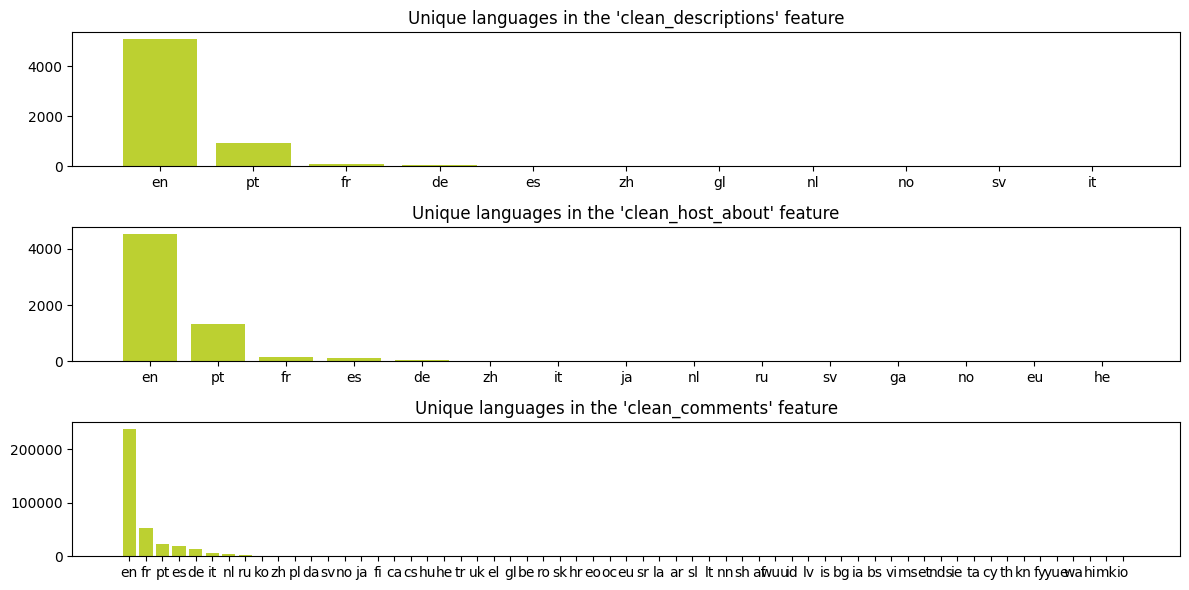

In [ ]:
# we are plotting this here and not aftwerwards during data exploration after pre processing
# because this data is used for the next step - we need to check the most common languages
# so we can translate those

description_languages = train_merged[['property_index', 'clean_description_lang']].drop_duplicates()['clean_description_lang'].value_counts()
host_about_languages = train_merged[['property_index', 'clean_host_about_lang']].drop_duplicates()['clean_host_about_lang'].value_counts()
comments_languages = train_merged['clean_comments_lang'].value_counts()

print(f"No. of unique languages in clean_description_lang: {len(description_languages)}")
print(f"No. of unique languages in clean_host_about_lang: {len(host_about_languages)}")
print(f"No. of unique languages in clean_comments_lang: {len(comments_languages)}")

# plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))
color = (188/255, 208/255, 49/255)


ax1.bar(description_languages.index, description_languages, color=color)
ax1.set_title("Unique languages in the 'clean_descriptions' feature")

ax2.bar(host_about_languages.index, host_about_languages, color=color)
ax2.set_title("Unique languages in the 'clean_host_about' feature")

ax3.bar(comments_languages.index, comments_languages, color=color)
ax3.set_title("Unique languages in the 'clean_comments' feature")

plt.tight_layout()
plt.show()

In [ ]:
common_languages = [
    'en', 'pt', 'es', 'fr',
    'it', 'de', 'nl', 'ru'
]

print(f"Proportion of common languages in comments: {len(train_merged.loc[train_merged['clean_comments_lang'].isin(common_languages)]) / len(train_merged['clean_comments_lang']):.3f}")

# ... ideally we could choose the top 10 languages instead of top 8
# however finding stop words for chinese and korean is troublesome
# therefore we decided on translating them as well
print('\nComments by language:')
print(train_merged['clean_comments_lang'].value_counts()[:15])

Proportion of common languages in comments: 0.985

Comments by language:
clean_comments_lang
en    237924
fr     53082
pt     22400
es     19289
de     14235
it      5693
nl      3581
ru      1525
ko      1412
zh      1211
pl       545
da       419
sv       361
no       210
ja       181
Name: count, dtype: int64


In [ ]:
print(f"Null languages: {train_merged['clean_comments_lang'].isnull().sum()}")
assert all(train_merged['clean_comments_lang'].isnull() == train_merged['clean_comments'].isnull()), 'Nulls not at the same indexes'

Null languages: 0


In [ ]:
# ... and on the test set?

#### **Additional #1: Translating Rare Languages**

In [ ]:
# the reviews are written in several different languages. Although ideally our dataset should only
# have text in one unique language, translating all comments to english would be a too time consuming
# task and could as well result in the addition of bias due to information being 'lost in translation'.
# Therefore we picked out the most common languages which will be kept as they are, but will translate to english,
# all other uncommon languages.

# The main reason for the translation is that the resulting languages (after translating rare to en)
# are all supported by libraries for pre processing, like nltk and spacy and pre trained models we use for
# fine tuning and feature extraction were train in a corpous with those languages (at least). Also by translating
# languages we are reducing our vocabulary size which might be helpful for feature engineering.

# although this is an additional step we chose to insert it in the middle of data pre processing because
# cleaning the text data too thouroughly might imply the loss of semantic context and therefore imply
# the lack of quality of the translation

# although this is an additional step, we chose to add it in between the mandatory steps
# because the order matters. Applying the NER spacy algorithm to sentences after being
# heavily pre processed, e.g. stop word removal and lemmatization, might imply the loss
# of context and consequently the lack of accuracy of the NER algorithm

In [ ]:
# for translating we are using the deep_translator library. In essence we are calling
# the google translator API

# quick fixes beforehand
# 'he' is code for 'hebrew'
# but for the deep_translator library it is: 'iw'
# same idea for the others ...

iso_code_fixes = {
    'he': 'iw',  # iw is the old code for hebrew
    'zh': 'zh-CN',  # simplified chinese
}

for df in [train_merged, test_merged]:
    for col_name in ['clean_description_lang', 'clean_host_about_lang', 'clean_comments_lang']:
        df[col_name] = df[col_name].replace(iso_code_fixes)

In [ ]:
# remaining languages
remaining_languages = train_merged.loc[-train_merged['clean_comments_lang'].isin(common_languages), 'clean_comments_lang']
remaining_languages.value_counts()

clean_comments_lang
ko       1412
zh-CN    1211
pl        545
da        419
sv        361
no        210
ja        181
fi        177
ca        177
cs         99
hu         98
iw         91
tr         59
uk         57
el         49
gl         34
be         33
ro         22
sk         18
hr         17
eo         14
oc         13
eu         13
sr         13
la         12
ar         10
sl          8
lt          6
nn          6
sh          5
id          4
af          4
wuu         4
is          3
bg          3
lv          3
vi          2
ia          2
bs          2
ms          2
et          2
nds         1
ie          1
ta          1
cy          1
wa          1
kn          1
fy          1
yue         1
th          1
hi          1
mk          1
io          1
Name: count, dtype: int64

In [ ]:
# not all languages are supporte by deep_translator

deep_translator_supported = ['af', 'sq', 'am', 'ar', 'hy', 'as', 'ay', 'az', 'bm', 'eu', 'be', 'bn', 'bho', 'bs', 'bg', 'ca', 'ceb', 'ny', 'zh-CN', 'zh-TW',
                             'co', 'hr', 'cs', 'da', 'dv', 'doi', 'nl', 'en', 'eo', 'et', 'ee', 'tl', 'fi', 'fr', 'fy', 'gl', 'ka', 'de', 'el', 'gn', 'gu',
                             'ht', 'ha', 'haw', 'iw', 'hi', 'hmn', 'hu', 'is', 'ig', 'ilo', 'id', 'ga', 'it', 'ja', 'jw', 'kn', 'kk', 'km', 'rw', 'gom', 'ko',
                             'kri', 'ku', 'ckb', 'ky', 'lo', 'la', 'lv', 'ln', 'lt', 'lg', 'lb', 'mk', 'mai', 'mg', 'ms', 'ml', 'mt', 'mi', 'mr', 'mni-Mtei',
                             'lus', 'mn', 'my', 'ne', 'no', 'or', 'om', 'ps', 'fa', 'pl', 'pt', 'pa', 'qu', 'ro', 'ru', 'sm', 'sa', 'gd', 'nso', 'sr', 'st',
                             'sn', 'sd', 'si', 'sk', 'sl', 'so', 'es', 'su', 'sw', 'sv', 'tg', 'ta', 'tt', 'te', 'th', 'ti', 'ts', 'tr', 'tk', 'ak', 'uk', 'ur',
                             'ug', 'uz', 'vi', 'cy', 'xh', 'yi', 'yo', 'zu']


deep_unsupported_languages = []
for lang, comment_count in zip(remaining_languages.value_counts().index, remaining_languages.value_counts().values):
     if lang not in deep_translator_supported:
         deep_unsupported_languages.append(lang)
         print(f'{lang}: {comment_count}')

oc: 13
nn: 6
sh: 5
wuu: 4
ia: 2
nds: 1
ie: 1
wa: 1
yue: 1
io: 1


In [ ]:
# the unsupported languages represent such a minuscule amount of data that they can
# be removed without any major implications
# we just need to make sure there is no property that only has reviews in one of those languages
# to avoid messing up the output excel file (test predictions)

for idx, row in test_merged.groupby('property_index').agg({'clean_comments_lang': lambda x: x.tolist()}).reset_index().iterrows():
    if len(row['clean_comments_lang']) == 1:
        if row['clean_comments_lang'][0] in deep_unsupported_languages:
            print(f'WARNING: {idx}, {row}')

# ... no printed statement ==> there won't be no issues, we can remove them safely

train_merged = train_merged.loc[-train_merged['clean_comments_lang'].isin(deep_unsupported_languages), :]
test_merged = test_merged.loc[-test_merged['clean_comments_lang'].isin(deep_unsupported_languages), :]

In [ ]:
# if we group first by language then we only
# need to call GoogleTranslator once for each language
# i.e. faster
def group_by_language(df, lang_col_name):
    u_lang = df[lang_col_name].unique()
    for lang in u_lang:
        df_lang = df.loc[df[lang_col_name] == lang, :]
        yield df_lang


def apply_translation(df, text_col_name, lang_col_name, df_index_col):
    df_lang_gen = group_by_language(df, lang_col_name)
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:
        # every df only contains rows of the same language
        lang = df_lang[lang_col_name].iloc[0]

        if lang not in common_languages:
            # NOTE: max translation length of 5000 characters
            # NOTE: some languages are not accepted
            translator = GoogleTranslator(source=lang, target='en')
            translated_text = []
            for text in tqdm(df_lang[text_col_name], total=len(df_lang), desc=f'Translating {text_col_name} {lang} to en'):
                # translation upper cases words and adds punctuation
                # we need to remove them
                translated_text.append(translator.translate(text))  # translation might add punctuation and upper case some letters, which is ok because we will handle it after NER
            df_lang[f'trans_{text_col_name}'] = translated_text
        else:
            # else, keep as is
            df_lang[f'trans_{text_col_name}'] = df_lang[text_col_name]

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


start = time.perf_counter()
for df in [train_merged, test_merged]:
    for text_col in ['clean_description', 'clean_host_about', 'clean_comments']:

        # need to do this due to the mapping function
        if (text_col == 'clean_description') or (text_col == 'clean_host_about'):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'

        lang_col = f'{text_col}_lang'
        reduced_df = df[[index_col, text_col, lang_col]].drop_duplicates()
        trans_df = apply_translation(reduced_df, text_col, lang_col, index_col)
        df[f'trans_{text_col}'] = df[index_col].map(dict(zip(trans_df[index_col], trans_df[f'trans_{text_col}'])))
        df[f'trans_{lang_col}'] = df[lang_col].apply(lambda x: 'en' if x not in common_languages else x)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Translating clean_comments lv to en: 100%|███████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Took 7035.43 seconds


In [ ]:
# checking if all is good
train_merged['trans_clean_comments_lang'].value_counts()

trans_clean_comments_lang
en    243302
fr     53082
pt     22400
es     19289
de     14235
it      5693
nl      3581
ru      1525
Name: count, dtype: int64

#### **Additional #2: Named Entity Recognition (NER)**

In [ ]:
# although this is an additional step, we chose to add it in between the mandatory steps
# because the order matters. Applying the NER spacy algorithm to sentences after being
# heavily pre processed, e.g. stop word removal and lemmatization, might imply the loss
# of context and consequently the lack of accuracy of the NER algorithm

# firstly you need to download the pre-trained spacy models:
# python -m spacy download <model name, e.g. en_core_web_sm>
# for all models in the dictionary below
# NOTE: spacy 'sm' models are built for efficiency whereas 'trf' models are built for accuracy

# the common languages
spacy_nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'pt': spacy.load('pt_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm'),
    'it': spacy.load('it_core_news_sm'),
    'es': spacy.load('es_core_news_sm'),
    'de': spacy.load('de_core_news_sm'),
    'nl': spacy.load('nl_core_news_sm'),
    'ru': spacy.load('ru_core_news_sm')
}

In [ ]:
# doc = spacy_nlp_models['en']("silvia's place was great")
# doc = spacy_nlp_models['en']("Tatiana and her husband")
doc = spacy_nlp_models['en']("Pedro is a nice host")
# doc = spacy_nlp_models['pt']("A casa do João era linda")

for ent in doc.ents:
    print(ent.text, ent.label_)

Pedro PERSON


In [ ]:
# the spacy model is somewhat complex so in order to increase efficiency
# we can use the pipe method: https://spacy.io/usage/processing-pipelines

# https://www.kaggle.com/code/curiousprogrammer/entity-extraction-and-classification-using-spacy
# spacy recognizes the following entities
# PERSON - People, including fictional.
# NORP - Nationalities or religious or political groups.
# FAC - Buildings, airports, highways, bridges, etc.
# ORG - Companies, agencies, institutions, etc.
# GPE - Countries, cities, states.
# LOC - Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT - Objects, vehicles, foods, etc. (Not services.)
# EVENT - Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART - Titles of books, songs, etc.
# LAW - Named documents made into laws.
# LANGUAGE - Any named language.
# DATE - Absolute or relative dates or periods.
# TIME - Times smaller than a day.
# PERCENT - Percentage, including "%".
# MONEY - Monetary values, including unit.
# QUANTITY - Measurements, as of weight or distance.
# ORDINAL - "first", "second", etc.
# CARDINAL - Numerals that do not fall under another type.


def ner(df, text_col_name, lang_col_name, actions, df_index_col):

    def act(doc, lang):
        # the NER are not necessarily tokens, e.g. tokens ['optimus', 'prime']
        # and NER 'PERSON' -> 'Optimus Prime', so this is not about replacing
        # tokens with the entity but replacing substrings with the entity
        text = doc.text
        for ent in doc.ents:
            # print(ent.text, ent.label_)
            ent_label = ent.label_
            ent_text = ent.text
            if ent_label in actions.keys():
                text = text.replace(ent_text, actions[ent_label][lang] if not None else '')
        return text

    disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]  # for efficiency reasons
    df_lang_gen = group_by_language(df, lang_col_name)  # using data generator to group datasets by language to speed up nlp.pipe
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:
        lang = df_lang[lang_col_name].iloc[0]
        new_col = []
        for doc in tqdm(spacy_nlp_models[lang].pipe(df_lang[text_col_name].tolist(), disable=disable), total=len(df_lang), desc=f'NER {text_col_name} [{lang}]'):
            # print([(ent.text, ent.label_) for ent in doc.ents])
            text = act(doc, lang)
            new_col.append(text)

        # creating new column
        df_lang[f'ner_{text_col_name}'] = new_col

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


# if value is None then that entity will be removed
# if str then will be replaced by that string
ner_actions = {
    'PERSON': {'en': 'person', 'pt': 'pessoa', 'fr': 'personne', 'es': 'persona', 'it': 'personne', 'de': 'person', 'nl': 'persoon', 'ru': 'человек'},
    'PER': {'en': 'person', 'pt': 'pessoa', 'fr': 'personne', 'es': 'persona', 'it': 'personne', 'de': 'person', 'nl': 'persoon', 'ru': 'человек'},
    'GPE': {'en': 'location', 'pt': 'local', 'fr': 'emplacement', 'es': 'ubicación', 'it': 'posizione', 'de': 'standort', 'nl': 'plaats', 'ru': 'расположение'},
    'LOC': {'en': 'location', 'pt': 'local', 'fr': 'emplacement', 'es': 'ubicación', 'it': 'posizione', 'de': 'standort', 'nl': 'plaats', 'ru': 'расположение'},
}
# ... we could but no, we are not removing anything

start = time.perf_counter()

for df in [train_merged, test_merged]:
    for text_col in ['trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments']:

        if (text_col == 'trans_clean_description') or (text_col == 'trans_clean_host_about'):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'

        lang_col_name = f'{text_col}_lang'
        reduced_df = df[[index_col, text_col, lang_col_name]].drop_duplicates()
        ner_df = ner(reduced_df, text_col, lang_col_name, ner_actions, index_col)
        df[f'ner_{text_col}'] = df[index_col].map(dict(zip(ner_df[index_col], ner_df[f'ner_{text_col}'])))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

NER trans_clean_comments [ru]: 100%|████████████████████████████████████████████████| 154/154 [00:00<00:00, 431.80it/s]

Took 781.33 seconds


In [ ]:
# NER does have its short comings
train_merged[['trans_clean_comments', 'ner_trans_clean_comments']].sample(10)

# ... seems to not be working more often than it does

# LIMITATIONS:
# ... too much cleaning beforehand
# ... the unrigorous / informal grammar and ortography in reviews

# ... but note that although it may not always increase the quality
# of the text it does not seem to decrease it, i.e. replace non-entities
# (we basically have various False Negatives - not picking up on entities -
# but few, if any, False Positives)

trans_clean_comments  \
140613  Ana's place was wonderful Great location comfo...   
304139  Nice and well equipped apartment in a very ple...   
18909   Merci à nos hôtes pour ce logement qu'ils ont ...   
231535                                   Wonderful Lisbon   
70756   Expect a real authentic stay in a stylish apar...   
93847   Apartamento no primeiro andar de um prédio loc...   
217209  Jorge has a beautiful home It is a clean and w...   
323800  Great artist musician designer Portuguese cele...   
73625   Très grand logement privé à très bon prix Touc...   
186070  The host was very nice He was already waiting ...   

                                 ner_trans_clean_comments  
140613  Ana's place was wonderful Great location comfo...  
304139  Nice and well equipped apartment in a very ple...  
18909   Merci à nos hôtes pour ce logement qu'ils ont ...  
231535                                             person  
70756   Expect a real authentic stay in a stylish apar...  
93847   local no primeiro andar de um prédio localizad...  
217209  person has a beautiful home It is a clean and ...  
323800  Great artist musician designer Portuguese cele...  
73625   Très grand logement privé à très bon prix Touc...  
186070  The host was very nice He was already waiting ...

#### **Text Cleaning with Regex and Common String Methods AFTER Named Entity Recognition**

In [ ]:
def lower_case(text):
    return text.lower()

def remove_apostrophe(text):
    return text.replace("'", '')

def clean_text_post_ner(text):
    if pd.isna(text):
        return text

    # after several manual tries it seems spacy's
    # NER algo. works better with punctuation
    # mainly apostrophe and upper case names
    # i.e. Silvia's place was awesome is easier
    # to deteck Silvia as PERSON rather than
    # silvias place was awesome or even silvia's
    # place was awesome
    text = remove_apostrophe(text)
    text = lower_case(text)

    return text

In [ ]:
start = time.perf_counter()

for df in [train_merged, test_merged]:
    # before NER
    df['trans_clean_description'] = df['property_index'].map(map_from_unique(df, clean_text_post_ner, 'trans_clean_description'))
    df['trans_clean_host_about'] = df['property_index'].map(map_from_unique(df, clean_text_post_ner, 'trans_clean_host_about'))
    df['trans_clean_comments'] = df['trans_clean_comments'].apply(clean_text_post_ner)

    # after NER
    df['ner_trans_clean_description'] = df['property_index'].map(map_from_unique(df, clean_text_post_ner, 'ner_trans_clean_description'))
    df['ner_trans_clean_host_about'] = df['property_index'].map(map_from_unique(df, clean_text_post_ner, 'ner_trans_clean_host_about'))
    df['ner_trans_clean_comments'] = df['ner_trans_clean_comments'].apply(clean_text_post_ner)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 2.02 seconds


#### **Removing Stop Words**

In [ ]:
# transforming it into ISO 639-1 codes
nltk_stopwords = {
    'nl': stopwords.words('dutch'),
    'en': stopwords.words('english'),
    'fr': stopwords.words('french'),
    'de': stopwords.words('german'),
    'it': stopwords.words('italian'),
    'pt': stopwords.words('portuguese'),
    'ru': stopwords.words('russian'),
}

In [ ]:
def remove_stopwords(text, lang='en'):
    if lang in nltk_stopwords.keys():
        text = ' '.join([t for t in word_tokenize(text) if t not in nltk_stopwords[lang]])
    return text


start = time.perf_counter()

for df in [train_merged, test_merged]:
    for text_col in ['trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments']:
        lang_col = f'{text_col}_lang'
        ner_col = f'ner_{text_col}'

        if (text_col == 'trans_clean_description') or (text_col == 'trans_clean_host_about'):
            # without NER
            df[f'no_stopwords_{text_col}'] = df['property_index'].map(map_from_unique(df, remove_stopwords, text_col, lang_col))
            # with NER
            df[f'no_stopwords_{ner_col}'] = df['property_index'].map(map_from_unique(df, remove_stopwords, ner_col, lang_col))
        else:
            # without NER
            df[f'no_stopwords_{text_col}'] = df.apply(lambda row: remove_stopwords(row[text_col], row[lang_col]), axis=1)
            # with NER
            df[f'no_stopwords_{ner_col}'] = df.apply(lambda row: remove_stopwords(row[ner_col], row[lang_col]), axis=1)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 287.10 seconds


In [ ]:
# example of how stop word removal might return a blank string

train_merged.loc[train_merged['no_stopwords_trans_clean_comments'] == '', ['comments', 'trans_clean_comments', 'no_stopwords_trans_clean_comments']].sample(10)

# ... new examples of pseudo nans
# ... text cleaning might not always be perfect

comments trans_clean_comments no_stopwords_trans_clean_comments
70535                No                   no                                  
206612               we                   we                                  
250758               SO                   so                                  
112363              A a                  a a                                  
70302              A+++                    a                                  
182789         As above             as above                                  
234694  Все было хорошо      все было хорошо                                  
20425        Все хорошо           все хорошо                                  
258989               No                   no                                  
42697                No                   no

In [ ]:
# stopwords removal migth strip a string untils its blank
print((train_merged == '').sum())
print()
print((test_merged == '').sum())

comment_index                                0
property_index                               0
description                                  0
host_about                                   0
unlisted                                     0
comments                                     0
clean_description                            0
clean_host_about                             0
clean_comments                               0
nan_index_comments                           0
nan_index_host_about                         0
clean_description_lang                       0
clean_host_about_lang                        0
clean_comments_lang                          0
trans_clean_description                      0
trans_clean_description_lang                 0
trans_clean_host_about                       0
trans_clean_host_about_lang                  0
trans_clean_comments                         0
trans_clean_comments_lang                    0
ner_trans_clean_description                  0
ner_trans_cle

In [ ]:
# add to nan_index and replace blanks with the 'unknown' token

def update_nan_index(nan_index, text):
    if nan_index == 1:
        return 1
    elif (text == 'nan') or (pd.isna(text)):
        return 1
    else:
        return 0

for df in [train_merged, test_merged]:
    for text_col in ['no_stopwords_trans_clean_host_about', 'no_stopwords_ner_trans_clean_host_about', 'no_stopwords_trans_clean_comments', 'no_stopwords_ner_trans_clean_comments']:
        # creating idx columns
        df['nan_index_comments'] = df.apply(lambda row: update_nan_index(row['nan_index_comments'], row[text_col]), axis=1)
        df[text_col] = df[text_col].replace('', 'unknown')

#### **Stemming**

In [ ]:
nltk_stemmers = {
    'nl': SnowballStemmer('dutch'),
    'en': SnowballStemmer('english'),
    'fr': SnowballStemmer('french'),
    'de': SnowballStemmer('german'),
    'it': SnowballStemmer('italian'),
    'pt': SnowballStemmer('portuguese'),
    'es': SnowballStemmer('spanish'),
    'ru': SnowballStemmer('russian'),
}

In [ ]:
def stem(text, lang):
    if lang in nltk_stemmers.keys():
        stemmer = nltk_stemmers[lang]
        text = ' '.join([stemmer.stem(t) for t in word_tokenize(text)])
    return text


start = time.perf_counter()

for df in [train_merged, test_merged]:
    for text_col in ['trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments']:
        lang_col = f'{text_col}_lang'
        ner_col = f'ner_{text_col}'

        if (text_col == 'trans_clean_description') or (text_col == 'trans_clean_host_about'):
            # without NER
            df[f'stem_no_stopwords_{text_col}'] = df['property_index'].map(map_from_unique(df, stem, f'no_stopwords_{text_col}', lang_col))
            # with NER
            df[f'stem_no_stopwords_{ner_col}'] = df['property_index'].map(map_from_unique(df, stem, f'no_stopwords_{ner_col}', lang_col))
        else:
            # without NER
            df[f'stem_no_stopwords_{text_col}'] = df.apply(lambda row: stem(row[f'no_stopwords_{text_col}'], row[lang_col]), axis=1)
            # with NER
            df[f'stem_no_stopwords_{ner_col}'] = df.apply(lambda row: stem(row[f'no_stopwords_{ner_col}'], row[lang_col]), axis=1)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Took 567.99 seconds


#### **Lemmatization**

In [ ]:
def lemmatize(df, text_col_name, lang_col_name):

    disable=['parser','ner']  # for efficiency reasons
    df_lang_gen = group_by_language(df, lang_col_name)  # using data generator to group datasets by language to speed up nlp.pipe
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:
        lang = df_lang[lang_col_name].iloc[0]
        new_col = []
        for doc in tqdm(spacy_nlp_models[lang].pipe(df_lang[text_col_name].tolist(), disable=disable), total=len(df_lang), desc=f'Lemmatizing {text_col_name} [{lang}]'):
            text = " ".join([token.lemma_ for token in doc])
            new_col.append(text)

        # creating new column
        df_lang[f'lemma_{text_col_name}'] = new_col

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


start = time.perf_counter()

# also with and without NER
columns = [
    'no_stopwords_trans_clean_description',
    'no_stopwords_trans_clean_host_about',
    'no_stopwords_trans_clean_comments',
    'no_stopwords_ner_trans_clean_description',
    'no_stopwords_ner_trans_clean_host_about',
    'no_stopwords_ner_trans_clean_comments',
]

for df in [train_merged, test_merged]:
    for text_col in columns:

        if ('description' in text_col) or ('host_about' in text_col):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'

        lang_col_name = f"{text_col.replace('no_stopwords_', '').replace('ner_', '')}_lang"
        reduced_df = df[[index_col, text_col, lang_col_name]].drop_duplicates()
        lemma_df = lemmatize(reduced_df, text_col, lang_col_name)
        df[f'lemma_{text_col}'] = df[index_col].map(dict(zip(lemma_df[index_col], lemma_df[f'lemma_{text_col}'])))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

Lemmatizing no_stopwords_trans_clean_description [en]: 100%|██████████████████████| 5129/5129 [00:26<00:00, 192.09it/s]
Lemmatizing no_stopwords_trans_clean_description [pt]: 100%|████████████████████████| 951/951 [00:03<00:00, 284.10it/s]
Lemmatizing no_stopwords_trans_clean_description [fr]: 100%|███████████████████████████| 90/90 [00:02<00:00, 42.62it/s]
Lemmatizing no_stopwords_trans_clean_description [es]: 100%|██████████████████████████| 29/29 [00:00<00:00, 193.62it/s]
Lemmatizing no_stopwords_trans_clean_description [de]: 100%|██████████████████████████| 46/46 [00:00<00:00, 216.18it/s]
Lemmatizing no_stopwords_trans_clean_description [it]: 100%|█████████████████████████████████████| 1/1 [00:00<?, ?it/s]
Lemmatizing no_stopwords_trans_clean_description [nl]: 100%|████████████████████████████| 2/2 [00:00<00:00, 260.74it/s]
Lemmatizing no_stopwords_trans_clean_host_about [en]: 100%|███████████████████████| 4578/4578 [00:12<00:00, 352.67it/s]
Lemmatizing no_stopwords_trans_clean_hos

Took 1500.15 seconds


In [ ]:
# other probably useful pre processing techniques:

# topic modelling

# replacement of rare words by an UNK token (would decrease the size of the vocab. and therefore of the model parameters however
# we would need to define the thresholds manually for what is considered a rare word: this processed is made more difficult due
# to the existence of several languages, e.g. underrepresented languages could have all its vocb. removed)

# remove short comments (e.g. < 3 words)

# pre clean before NER (basically everything except punctuation removal?), apply NER, and then finish cleaning

#### **Train-Test Split**

In [ ]:
train_merged = pd.read_pickle(os.path.join('corpora', 'train_preprocessed.pkl'))
test_merged = pd.read_pickle(os.path.join('corpora', 'test_preprocessed.pkl'))

In [ ]:
# we want to make sure the data is stratified in terms of the target
# but also in terms of houses with and without reviews

def load_pkl_list(filename):
    with open(filename, 'rb') as file:
        lst = pickle.load(file)
    return lst

train_reviews = load_pkl_list(TRAIN_PROPERTIES_WITH_REVIEWS)
pseudo_df = train_merged[['property_index', 'unlisted']].drop_duplicates()
pseudo_df['has_comments'] = [1 if p in train_reviews else 0 for p in pseudo_df['property_index']]

print(pseudo_df['unlisted'].value_counts())
print(pseudo_df['unlisted'].value_counts(1))
print('\n-----------------------\n')
print(pseudo_df['has_comments'].value_counts())
print(pseudo_df['has_comments'].value_counts(1))

unlisted
0    4540
1    1708
Name: count, dtype: int64
unlisted
0    0.726633
1    0.273367
Name: proportion, dtype: float64

-----------------------

has_comments
1    4245
0    2003
Name: count, dtype: int64
has_comments
1    0.679417
0    0.320583
Name: proportion, dtype: float64


In [ ]:
# based on: https://datascience.stackexchange.com/questions/78194/is-it-possible-to-have-stratified-train-test-split-of-a-set-based-on-two-columns

X = pseudo_df['property_index'].copy()
y = pseudo_df['unlisted'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, pd.concat([pseudo_df["has_comments"], y], axis=1), stratify=pd.concat([pseudo_df["has_comments"], y], axis=1),
    test_size=.2, shuffle=True, random_state=SEED
)

y_train = y_train['unlisted']
y_test = y_test['unlisted']

print(f"Len. X_train: {len(X_train)} | Proportion: {len(X_train) / len(X):.2f}")
print(f"Len. X_test: {len(X_test)} | Proportion: {len(X_test) / len(X):.2f}")

print()
print(pseudo_df.loc[pseudo_df['property_index'].isin(X_train), 'unlisted'].value_counts(1))
print('\n', pseudo_df.loc[pseudo_df['property_index'].isin(X_train), 'has_comments'].value_counts(1))

# .... same proportions so all is good

Len. X_train: 4998 | Proportion: 0.80
Len. X_test: 1250 | Proportion: 0.20

unlisted
0    0.726491
1    0.273509
Name: proportion, dtype: float64

 has_comments
1    0.679472
0    0.320528
Name: proportion, dtype: float64


In [ ]:
# saving data

# saving all data to train final model on (not really necessary to save train data as well)
train_merged.to_pickle(os.path.join('corpora', 'train_preprocessed.pkl'))
test_merged.to_pickle(os.path.join('corpora', 'test_preprocessed.pkl'))

# saving train and test splits
Xy_train = train_merged.loc[train_merged['property_index'].isin(X_train), :]
Xy_test = train_merged.loc[train_merged['property_index'].isin(X_test), :]
Xy_train.to_pickle(os.path.join('corpora', 'Xy_train_preprocessed.pkl'))
Xy_test.to_pickle(os.path.join('corpora', 'Xy_test_preprocessed.pkl'))

In [ ]:
# saving indices and labels of houses in Xy_train and Xy_test
# this will help us when making predictions on datasets that
# are sliced (e.g. only houses with reviews) and therefore
# do not contain all houses

def make_info_dict(indices):
    info = {}
    for idx in indices:
        has_comments, unlisted = pseudo_df.loc[pseudo_df['property_index'] == idx, ['has_comments', 'unlisted']].values.tolist()[0]
        info[idx] = {'has_comments': has_comments, 'unlisted': unlisted}
    return info

X_train_info = make_info_dict(X_train.values)
X_test_info = make_info_dict(X_test.values)

with open('corpora/Xy_train_info.pkl', 'wb') as file:
    pickle.dump(X_train_info, file)

with open('corpora/Xy_test_info.pkl', 'wb') as file:
    pickle.dump(X_test_info, file)

## **Data Exploration After Pre-Processing**<a id='data-exploration-post-preproc'></a>

#### **Importing Pre Processed Data**

In [4]:
def load_pkl_list(filename):
    with open(filename, 'rb') as file:
        lst = pickle.load(file)
    return lst


def groupby_property(df):

    for col in df.columns:
        if ('index' in col) and (col != 'property_index'):
            df.drop(col, axis=1, inplace=True)

    if 'comment_index' in df.columns:
        df = df.drop('comment_index', axis=1)

    unlisted_exists = False
    if 'unlisted' in df.columns:
        unlisted_exists = True
        label_dict = {property_id: label for property_id, label in zip(df['property_index'], df['unlisted'])}
        df = df.drop('unlisted', axis=1)  # otherwise groupby would return error -> ''.join([ints...]) raises TypeError

    new_df = df.groupby('property_index').agg(lambda x: ' '.join(set(x))).reset_index()

    if unlisted_exists:
        new_df['unlisted'] = new_df['property_index'].map(label_dict)

    return new_df


def load_preprocessed_data(columns=[],
                           group = True,
                           concat_features = True,
                           drop_property_index=True,
                           handle_reviews = 'keep-all',  # keep all, keep properties with reviews, keep properties without reviews
                           lang = 'all',
                           lang_col = None,
                           train_path=XY_TRAIN_PREPROCESSED_PATH,
                           test_path=XY_TEST_PREPROCESSED_PATH,
                           train_info_path=XY_TRAIN_INFO_PATH,
                           test_info_path=XY_TEST_INFO_PATH):

    # loading data
    train_df = pd.read_pickle(train_path)
    test_df = pd.read_pickle(test_path)

    # kepp / remove houses with/out reviews
    if handle_reviews != 'keep-all':

        train_info = load_pkl_list(train_info_path)  # e.g. {'property_index_0': {'has_comments': 1, 'unlisted': 0}, ...}
        test_info = load_pkl_list(test_info_path)

        if handle_reviews == 'keep-reviews':
            train_df = train_df.loc[train_df['property_index'].isin([i for i in train_info if train_info[i]['has_comments']==1]), :]
            test_df = test_df.loc[test_df['property_index'].isin([i for i in test_info if test_info[i]['has_comments']==1]), :]

        elif handle_reviews == 'keep-no-reviews':
            train_df = train_df.loc[train_df['property_index'].isin([i for i in train_info if train_info[i]['has_comments']==0]), :]
            test_df = test_df.loc[test_df['property_index'].isin([i for i in test_info if test_info[i]['has_comments']==0]), :]

    # handle languages
    if lang != 'all':
        train_df = train_df.loc[train_df[lang_col] == lang, :]
        test_df = test_df.loc[test_df[lang_col] == lang, :]

    # handle columns
    if columns:

        if isinstance(columns, str):
            columns = [columns]

        # just making sure that the columns are in the dataset
        asserted_columns = list(set(columns + ['property_index', 'unlisted']))
        train_df = train_df[asserted_columns]
        test_df = test_df[asserted_columns]

    # grouping by property
    if group:
        train_df = groupby_property(train_df)
        test_df = groupby_property(test_df)

    # if no. of features > 1 we can choose to concatenate them
    # for easier ingestion into NLP models
    # if columns is None we wont't bother concat them all though
    if concat_features:
        if isinstance(columns, list) and len(columns) > 1:
            train_df['concat'] = train_df[[col for col in columns]].apply(lambda texts: ' '.join(texts), axis=1)
            test_df['concat'] = test_df[[col for col in columns]].apply(lambda texts: ' '.join(texts), axis=1)

            # we don't need the other columns besides concat (and 'unlisted for train')
            train_df = train_df.drop([col for col in train_df.columns if col not in ['property_index', 'concat', 'unlisted']], axis=1)
            test_df = test_df.drop([col for col in test_df.columns if col not in ['property_index', 'concat', 'unlisted']], axis=1)

    # might be useful to keep track of properties in
    if drop_property_index:
        train_df = train_df.drop('property_index', axis=1)
        test_df = test_df.drop('property_index', axis=1)

    return train_df, test_df

In [7]:
# loading all columns
# we are actually loading train and test splits and not the real test data
train_clean, test_clean = load_preprocessed_data(group=False, drop_property_index=False)
print(f'Pre-processed train shape: {train_clean.shape}')
print(f'Pre-processed test shape: {test_clean.shape}')

Pre-processed train shape: (289732, 41)
Pre-processed test shape: (73375, 41)


In [8]:
# grouping by property index
grouped_train_clean = groupby_property(train_clean)
grouped_test_clean = groupby_property(test_clean)
print(f'Grouped pre-processed train shape: {grouped_train_clean.shape}')
print(f'Groupped pre-processed test shape: {grouped_test_clean.shape}')

# ... sum of properties should add up to the number of properties in train_info (6248)

Grouped pre-processed train shape: (4998, 38)
Groupped pre-processed test shape: (1250, 38)


In [9]:
# for exploration purposes we can join train and test dfs
# as it is all the 'real' train data

train_clean = pd.concat([train_clean, test_clean], axis=0)
print(train_clean.shape)

(363107, 38)


#### **Word Count**

In [ ]:
word_columns = [
    ('comments', 'trans_clean_comments', 'no_stopwords_ner_trans_clean_comments'),
    ('description', 'trans_clean_description', 'no_stopwords_ner_trans_clean_description'),
    ('host_about', 'trans_clean_host_about', 'no_stopwords_ner_trans_clean_host_about'),
]

# every tuple needs to have the same size!

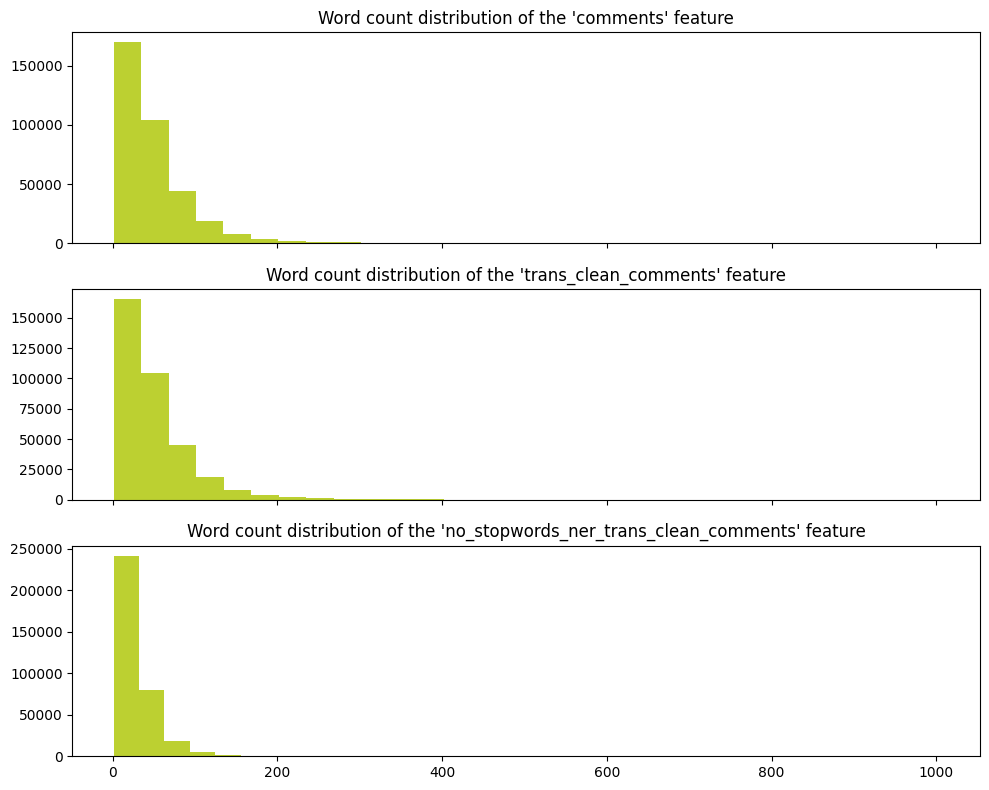

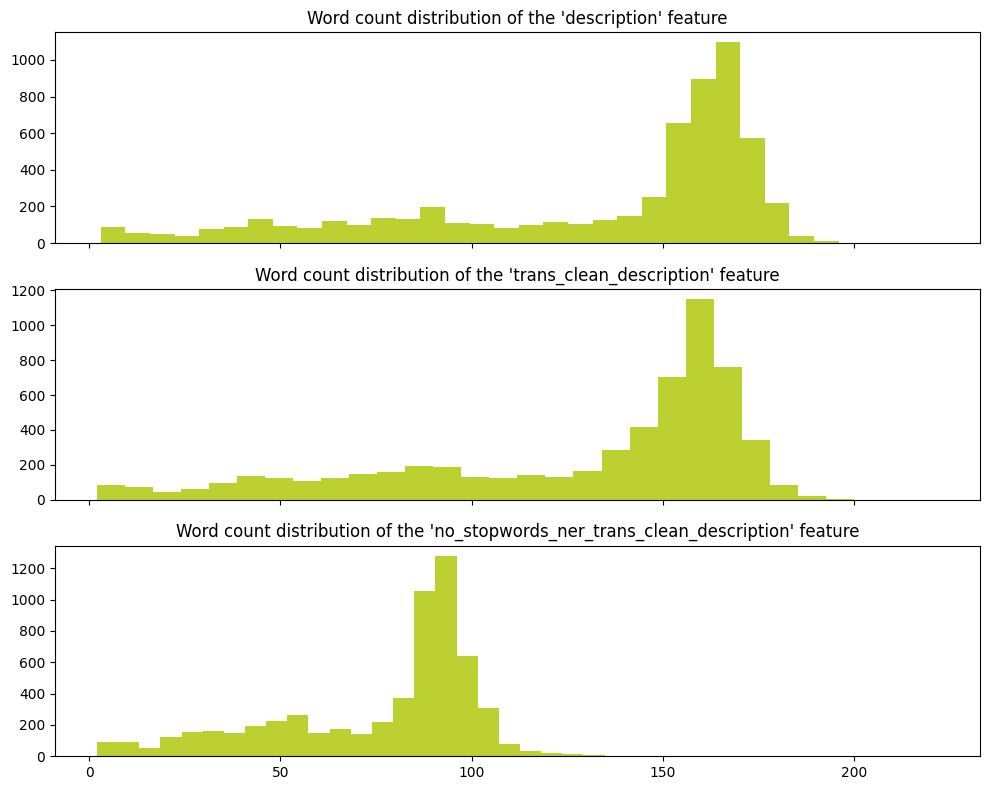

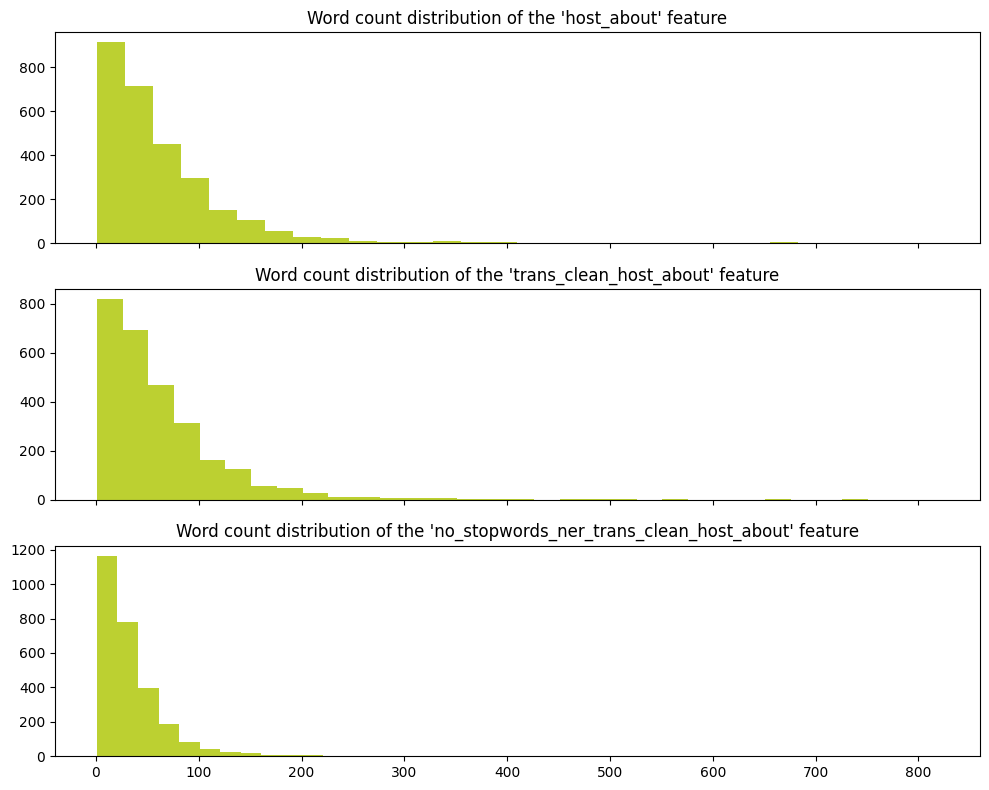

In [ ]:
def word_counter(text):
    if pd.isna(text):
        return 0
    return len(text.split())

for cols in word_columns:
    word_counts = []
    for col in cols:
        word_count = train_clean[col].drop_duplicates().map(word_counter)
        word_counts.append(word_count)

    fig, axes = plt.subplots(len(word_counts), 1, figsize=(10, 8), sharex=True)
    colors = [(188/255, 208/255, 49/255)]

    if len(word_counts) == 1:
        axes = [axes]

    for i, (ax, word_count) in enumerate(zip(axes, word_counts)):
        ax.hist(word_count, bins=30, color=colors)
        ax.set_title(f"Word count distribution of the '{cols[i]}' feature")

    plt.tight_layout()
    plt.show()

    print()

#### **Word Cloud**

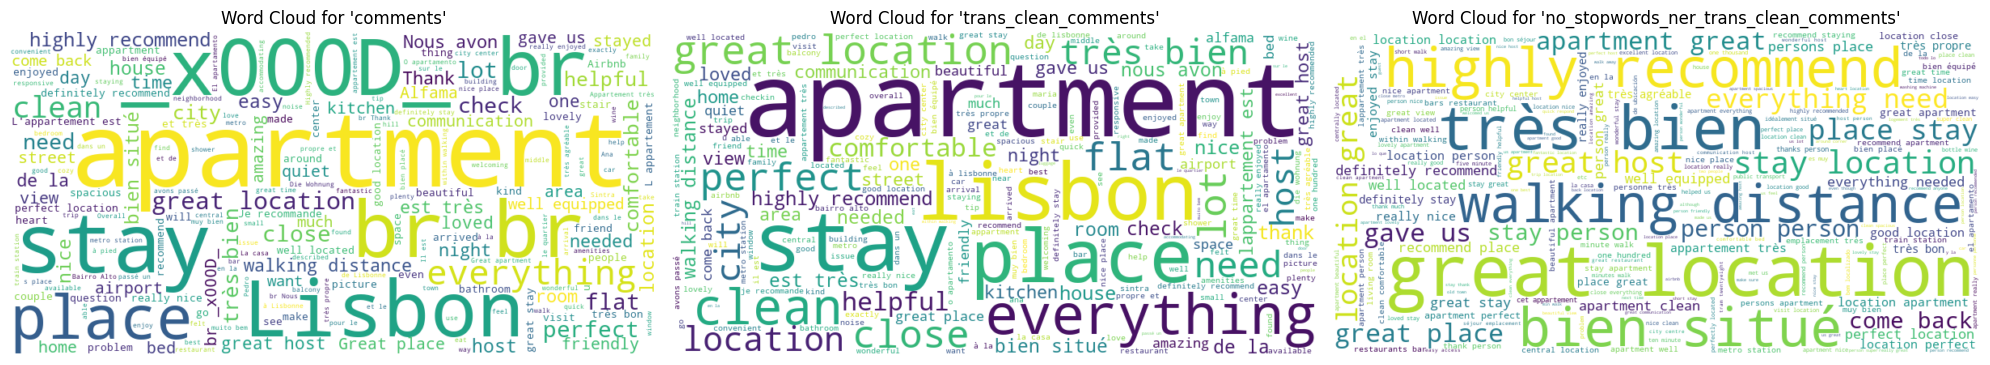

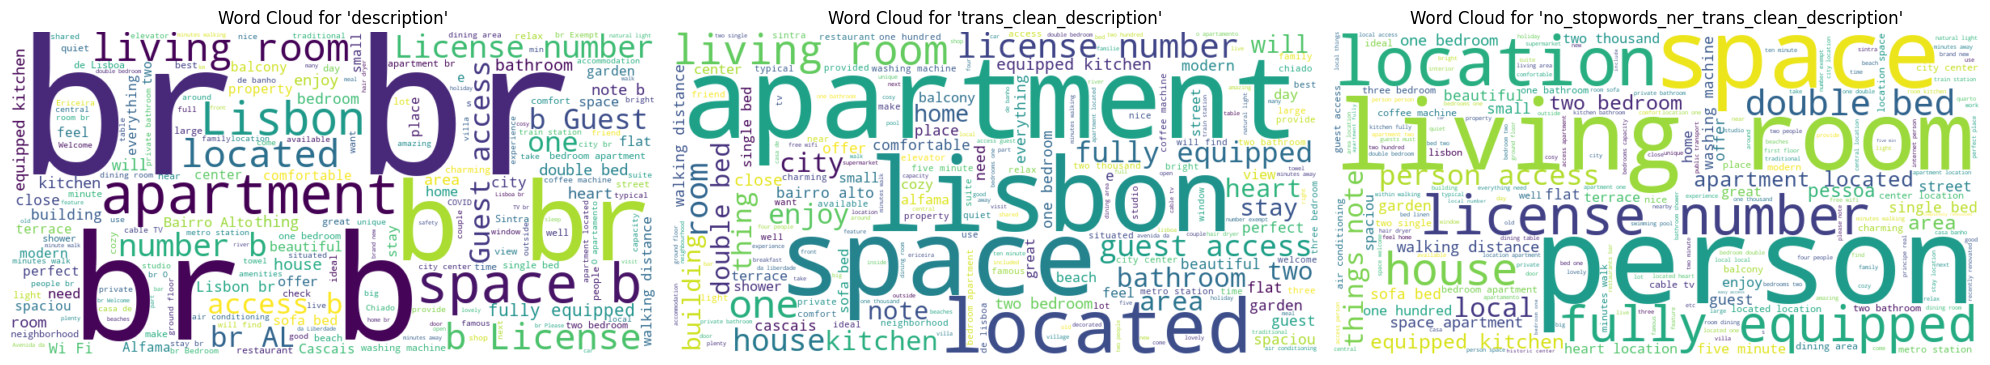

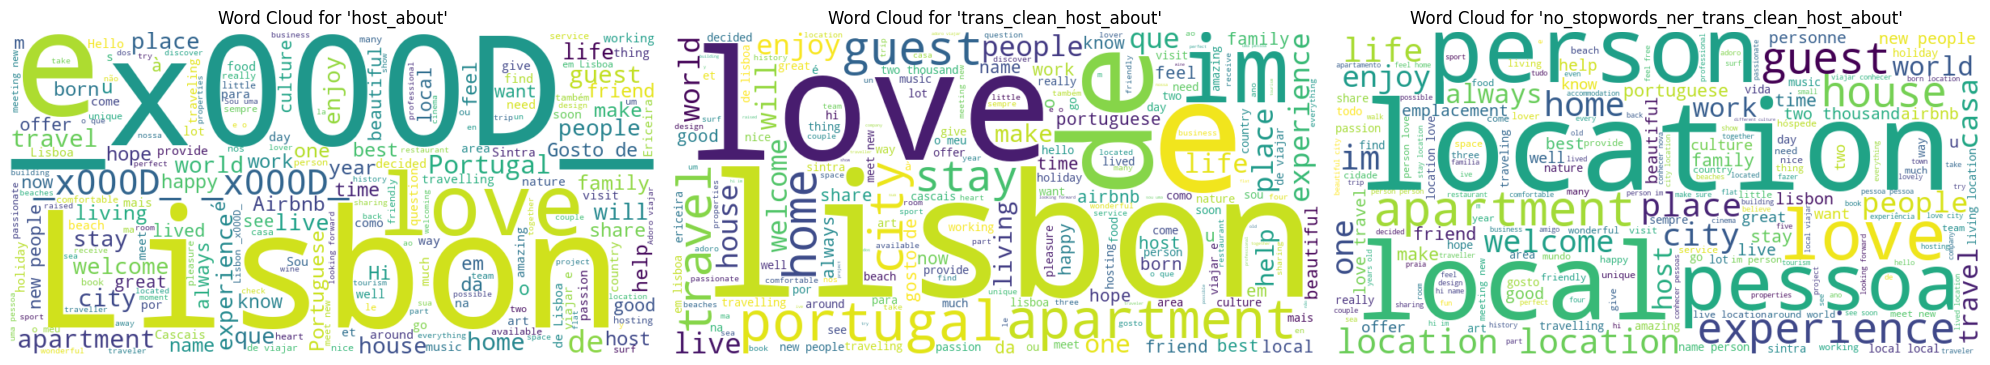

In [ ]:
def generate_joint_text(column_data):
    return ' '.join([text for text in column_data if not pd.isna(text)])

for cols in word_columns:
    joint_texts = []
    for col in cols:
        joint_text = generate_joint_text(train_clean[col].drop_duplicates())
        joint_texts.append(joint_text)

    wordclouds = [(col, WordCloud(width=800, height=400, background_color="white").generate(joint_text))
                  for col, joint_text in zip(cols, joint_texts)]

    fig, axes = plt.subplots(1, len(wordclouds), figsize=(20, 15 * len(wordclouds)))

    if len(wordclouds) == 1:
        axes = [axes]

    for ax, (col, wordcloud) in zip(axes, wordclouds):
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Word Cloud for '{col}'")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### **N-Grams**

In [ ]:
def plot_top_ngrams(corpus, n=None, ngrams=(1,1), top_n=10, title="Top N-grams"):
    """
    corpus: array-like, list of text documents.
    n: int, N-gram number.
    ngrams: tuple, range of N-gram.
    top_n: int, number of top N-grams to display.
    title: str, title of the plot.
    """
    vec = CountVectorizer(ngram_range=ngrams, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_n_words = words_freq[:top_n]

    top_df = pd.DataFrame(top_n_words, columns=['N-gram', 'Frequency'])
    top_df.set_index('N-gram', inplace=True)

    # Custom color (green)
    green_color = (188/255, 208/255, 49/255)

    # Plotting
    ax = top_df.plot(kind='bar', figsize=(8, 4), color=[green_color] * top_n, width=0.5)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

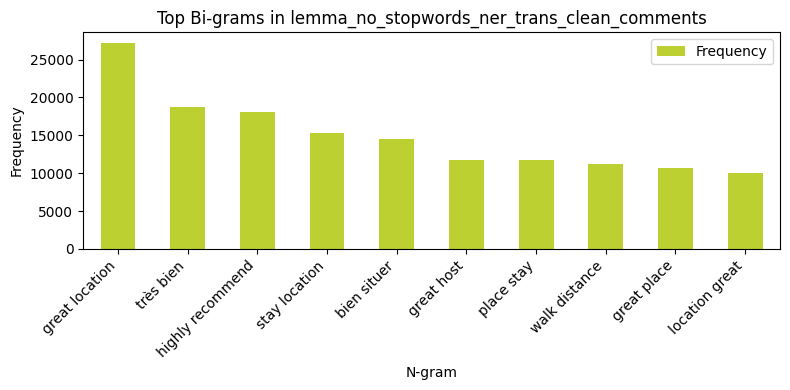

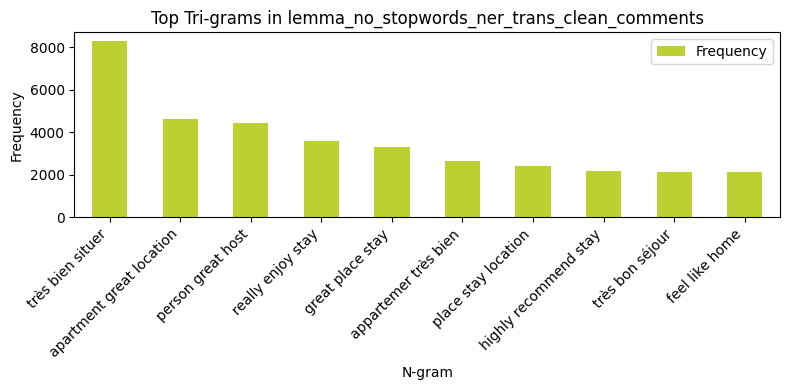

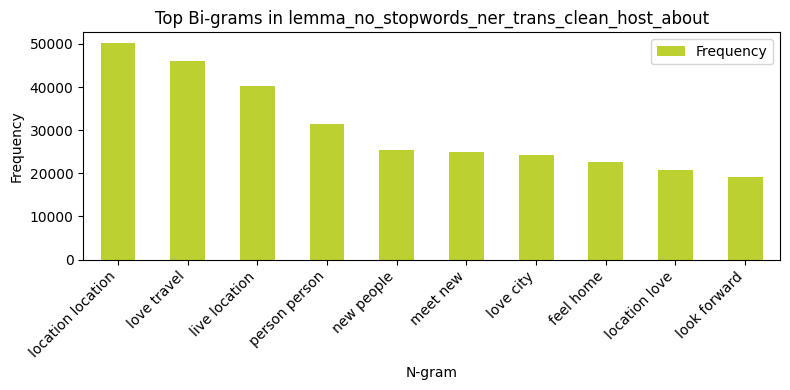

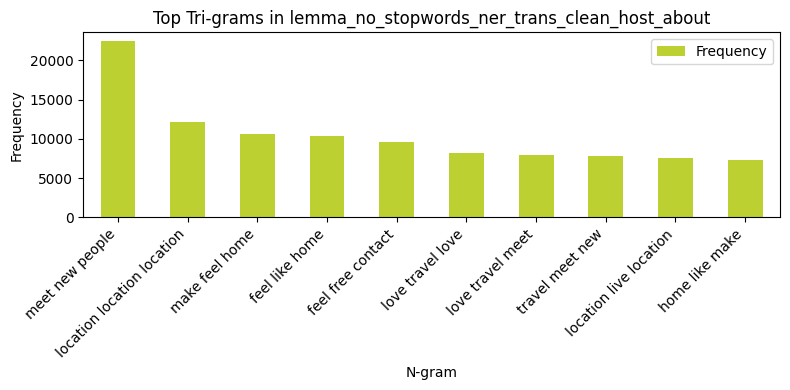

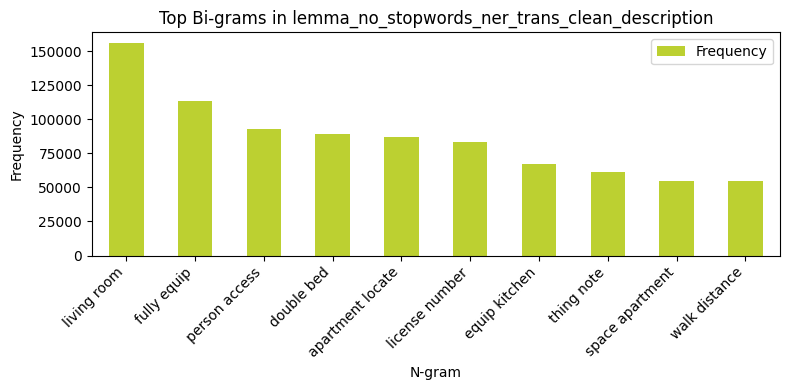

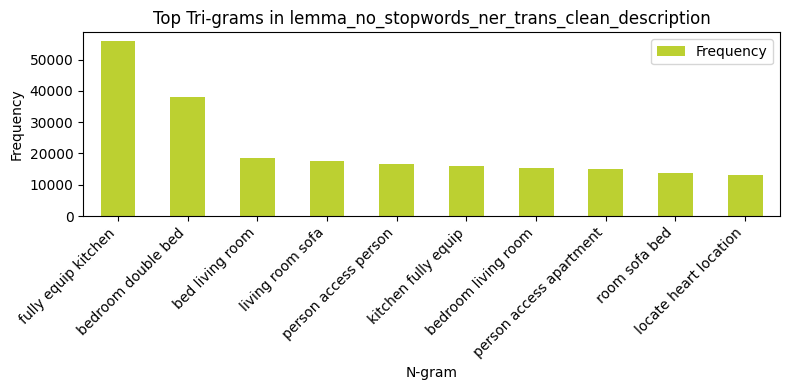

In [ ]:
# Analyze bi-grams for 'description'
plot_top_ngrams(train_clean['lemma_no_stopwords_ner_trans_clean_comments'], ngrams=(2,2), top_n=10, title="Top Bi-grams in lemma_no_stopwords_ner_trans_clean_comments")

# Analyze tri-grams for 'description'
plot_top_ngrams(train_clean['lemma_no_stopwords_ner_trans_clean_comments'], ngrams=(3,3), top_n=10, title="Top Tri-grams in lemma_no_stopwords_ner_trans_clean_comments")

# Analyze bi-grams for 'host_about'
plot_top_ngrams(train_clean['lemma_no_stopwords_ner_trans_clean_host_about'], ngrams=(2,2), top_n=10, title="Top Bi-grams in lemma_no_stopwords_ner_trans_clean_host_about")

# Analyze tri-grams for 'host_about'
plot_top_ngrams(train_clean['lemma_no_stopwords_ner_trans_clean_host_about'], ngrams=(3,3), top_n=10, title="Top Tri-grams in lemma_no_stopwords_ner_trans_clean_host_about")

# Analyze bi-grams for 'comments'
plot_top_ngrams(train_clean['lemma_no_stopwords_ner_trans_clean_description'], ngrams=(2,2), top_n=10, title="Top Bi-grams in lemma_no_stopwords_ner_trans_clean_description")

# Analyze tri-grams for 'comments'
plot_top_ngrams(train_clean['lemma_no_stopwords_ner_trans_clean_description'], ngrams=(3,3), top_n=10, title="Top Tri-grams in lemma_no_stopwords_ner_trans_clean_description")

In [ ]:
grouped_train_clean_ngrams=grouped_train_clean

# Define the n-grams
ngrams = ["great location", "highly recommend", "très bien", "really enjoy stay"]

# Create new binary features for each n-gram
for ngram in ngrams:
    grouped_train_clean_ngrams[ngram] = grouped_train_clean_ngrams['lemma_no_stopwords_ner_trans_clean_comments'].apply(lambda x: 0 if ngram in x else 1)

# Calculate the correlation between the new features and the target variable 'unlisted'
correlations = {}
for ngram in ngrams:
    correlation = grouped_train_clean_ngrams[[ngram, 'unlisted']].corr().iloc[0, 1]
    correlations[ngram] = correlation

# Display the correlations
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with unlisted'])

# Display the correlation DataFrame
print(correlation_df)

                   Correlation with unlisted
great location                      0.500208
highly recommend                    0.472944
très bien                           0.435749
really enjoy stay                   0.319514


#### **Distribution of Languages**

In [10]:
# do some properties cater more towards tourists of one country?
# does it affect the score?

lang_train_clean, lang_test_clean = load_preprocessed_data(group=False, drop_property_index=False, handle_reviews='keep-reviews')
lang_train_clean = pd.concat([lang_train_clean, lang_test_clean], axis=0)

In [11]:
# doesn't make the most sense to use translated
# but they are so few that we can follow along
lang_train_pivot = lang_train_clean.pivot_table(
    index='property_index',
    columns='trans_clean_comments_lang',
    values='trans_clean_comments',
    aggfunc='count'
).fillna(0.0)

# adding target
lang_train_pivot = pd.concat([lang_train_pivot, lang_train_clean[['property_index', 'unlisted']].drop_duplicates().set_index('property_index')], axis=1)

lang_train_pivot.head()

de     en   es    fr   it   nl   pt   ru  unlisted
property_index                                                     
1               2.0   31.0  3.0   5.0  0.0  0.0  6.0  3.0         0
5               5.0   18.0  4.0   5.0  0.0  2.0  7.0  0.0         0
8               0.0  149.0  5.0   5.0  2.0  0.0  7.0  0.0         0
9               1.0   17.0  2.0  11.0  1.0  0.0  1.0  0.0         0
10              1.0   11.0  0.0   0.0  0.0  0.0  1.0  0.0         0

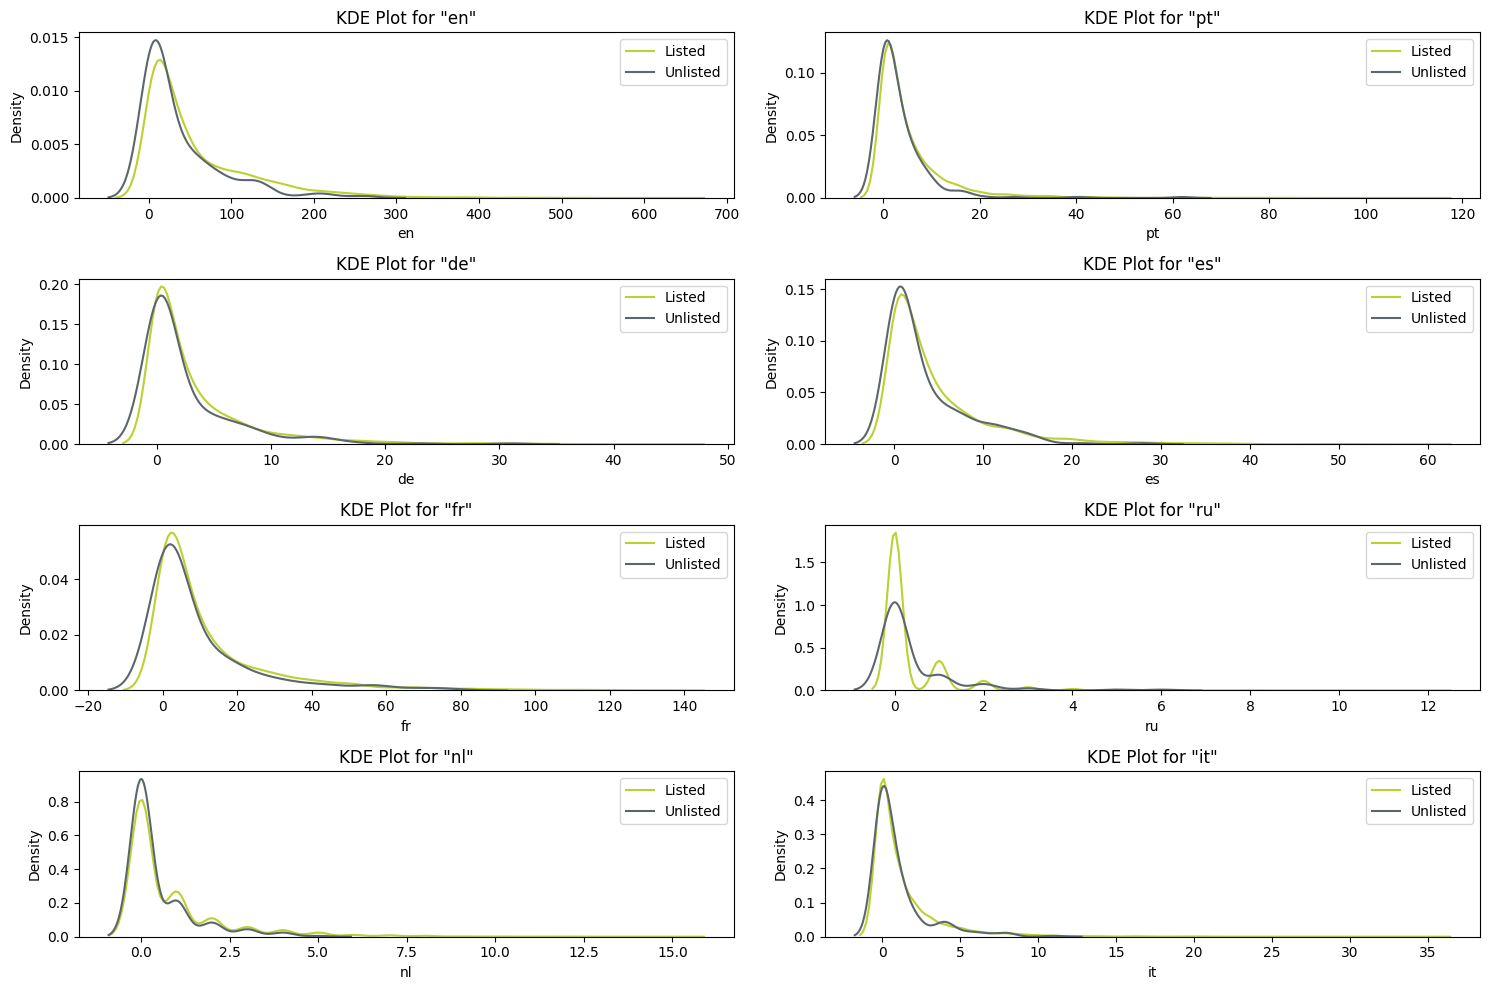

In [12]:
# Create subplots with 8 plots in a 4x2 grid
plt.figure(figsize=(15, 10))

# Subplot 1
plt.subplot(4, 2, 1)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'en'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'en'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "en"')

# Subplot 2
plt.subplot(4, 2, 2)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'pt'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'pt'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "pt"')

# Subplot 3
plt.subplot(4, 2, 3)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'de'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'de'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "de"')

# Subplot 4
plt.subplot(4, 2, 4)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'es'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'es'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "es"')

# Subplot 5
plt.subplot(4, 2, 5)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'fr'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'fr'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "fr"')

# Subplot 6
plt.subplot(4, 2, 6)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'ru'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'ru'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "ru"')

# Subplot 7
plt.subplot(4, 2, 7)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'nl'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'nl'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "nl"')

# Subplot 8
plt.subplot(4, 2, 8)
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 0, 'it'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=lang_train_pivot.loc[lang_train_pivot['unlisted'] == 1, 'it'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for "it"')

plt.tight_layout()
plt.show()


# ... similar distributions for each language, this indicates
# that more comments from a certain language doesn't really
# affect the house listing

#### **Document Lenght of Description and Host About for Properties Without Reviews**

In [14]:
no_rev_train_clean, no_rev_test_clean = load_preprocessed_data(columns=['trans_clean_description', 'trans_clean_host_about'],
                                                               group=True, drop_property_index=False, handle_reviews='keep-no-reviews',
                                                               concat_features=False)

no_rev_train_clean = pd.concat([no_rev_train_clean, no_rev_test_clean], axis=0)

In [15]:
no_rev_train_clean['len_description'] = no_rev_train_clean['trans_clean_description'].apply(lambda x: len(x.split()))
no_rev_train_clean['len_host_about'] = no_rev_train_clean['trans_clean_host_about'].apply(lambda x: len(x.split()))

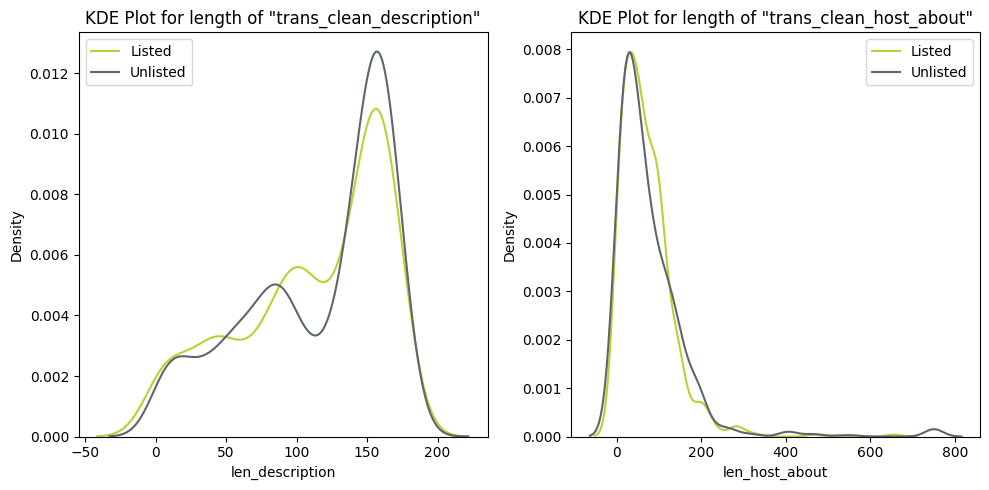

In [17]:
plt.figure(figsize=(10, 5))

# Subplot 1
plt.subplot(1, 2, 1)
sns.kdeplot(x=no_rev_train_clean.loc[no_rev_train_clean['unlisted'] == 0, 'len_description'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=no_rev_train_clean.loc[no_rev_train_clean['unlisted'] == 1, 'len_description'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for length of "trans_clean_description"')

# Subplot 2
plt.subplot(1, 2, 2)
sns.kdeplot(x=no_rev_train_clean.loc[no_rev_train_clean['unlisted'] == 0, 'len_host_about'], label='Listed', color=(188/255, 208/255, 49/255))
sns.kdeplot(x=no_rev_train_clean.loc[no_rev_train_clean['unlisted'] == 1, 'len_host_about'], label='Unlisted', color=(92/255, 103/255, 109/255))
plt.legend()
plt.title('KDE Plot for length of "trans_clean_host_about"')

plt.tight_layout()
plt.show()

# ... also no clear separation, does not seem to be discriminative feature

#### **Sentiment Analysis**

In [ ]:
# there are basically 3 types of sentiment analysis:
# 1. lexicon-based
# 2. machine learning-based
# 3. pre-trained transformer-based deep learning

In [141]:
def analyse_sentiment(corpus, en=False):
    if en:
        model_ckpt = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'
    else:
        # https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
        model_ckpt = 'nlptown/bert-base-multilingual-uncased-sentiment'

    device = ("cuda" if torch.cuda.is_available() else "cpu")
    pipe = pipeline('sentiment-analysis',
                    model=model_ckpt,
                    tokenizer=model_ckpt,
                    padding='max_length',
                    max_length=512,
                    truncation=True,
                    device=device)

    sentiment = pipe(corpus)

    if en:
        return [1 if sent['label'] == 'POSITIVE'
                else 0 for sent in sentiment]
    else:
        # doing some post processing as the output is ordinal 1-5 and for
        # simplicity sake we want it to be binary, positive or negative
        return [1 if sent['label'] in ['5 stars', '4 stars', '3 stars']
                else 0 for sent in sentiment]

In [ ]:
start = time.perf_counter()

train_clean_sentiment = train_clean.loc[train_clean['trans_clean_comments'] != 'unknown', :]  # all languages + with at least 1 review
# train_clean_sentiment = train_clean.loc[(train_clean['trans_clean_comments_lang'] == 'en') & (train_clean['trans_clean_comments'] != 'unknown'), :]  # english only + with at least 1 review
grouped_train_clean_sentiment = groupby_property(train_clean_sentiment)

sentiment_scores = {}
for col in ['ner_trans_clean_description', 'ner_trans_clean_host_about', 'ner_trans_clean_comments', ]:
    df = grouped_train_clean_sentiment[[col, 'unlisted']].drop_duplicates()
    print(f"Analyzing {col} {df.shape}...")
    sentiment = analyse_sentiment(df[col].tolist(), en=False)
    # doing some post processing as the output is ordinal 1-5 and for simplicity sake we want it to be binary, positive or negative
    sentiment_scores[col] = {'scores': sentiment, 'labels': df['unlisted'].tolist()}

print(f'Took {time.perf_counter() - start:0.2f} seconds')

# ...there are several duplicates in the host about colum, some are missing values (the host about column also has them and we are just dropping them for the comments column)
# also it seems the same host can be mapped to several properties (there several same host about strings for different properties):
# get there: grouped_train_clean_sentiment.loc[grouped_train_clean_sentiment['ner_trans_clean_host_about'].duplicated(keep=False), 'ner_trans_clean_host_about'].sort_values()

Analyzing ner_trans_clean_description (4131, 2)...


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Analyzing ner_trans_clean_host_about (2120, 2)...
Analyzing ner_trans_clean_comments (4244, 2)...
Took 397.86 seconds


In [ ]:
# chi-square test for independence
# H0: There is no significant relationship between Variable A and Variable B.
# vs.
# H1: There is a significant relationship between Variable A and Variable B
# therefore, rejecting the null suggests that there is evidence of an
# association between the variables.


for col, scores in sentiment_scores.items():
    contingency_table = pd.crosstab(scores['scores'], scores['labels'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(col)
    print("Chi-square statistic:", chi2)
    print("p-value:", p)
    # print("Degrees of freedom:", dof)
    # print("Expected frequencies:")
    # print(expected)
    print(f"Conclusion: {'Reject' if p < 0.05 else 'Fail to reject'} the null.")
    print('\n---------------------------------------------\n')

ner_trans_clean_description
Chi-square statistic: 1.1482479956254734
p-value: 0.2839162059917384
Conclusion: Fail to reject the null.

---------------------------------------------

ner_trans_clean_host_about
Chi-square statistic: 0.02892174783392797
p-value: 0.8649598424903656
Conclusion: Fail to reject the null.

---------------------------------------------

ner_trans_clean_comments
Chi-square statistic: 9.435139817892265
p-value: 0.0021286686006789114
Conclusion: Reject the null.

---------------------------------------------



In [ ]:
# limitations of sentiment analysis
# ... data cleaning / processing might cause bias
# ... data imbalance
# ... reviews might put out mixed signals, e.g. bad review about property, positive reiew
#     about trip, 'apartment was awful but the city was mesmerizing', model might predict
#     positive sentiment.
# ... lack of accuracy of the sentiment analyser used
# ... lack of power of the chi-square test

## **Feature Engineering**<a id='feature-engineering'></a>

In [ ]:
# due to multi-languages an approach like BoW would be sub-par since its issues
# like curse of dim. would only be exponentiated.

#### **Functions**

In [18]:
def extract_split_datasets(columns=[],
                           group = True,
                           concat_features = True,
                           drop_property_index=False,  # we want to keep it for datasets that dont use all properties
                           handle_reviews = 'keep-all',  # keep all, keep properties with reviews, keep properties without reviews
                           lang = 'all',
                           lang_col = None,
                           train_path=XY_TRAIN_PREPROCESSED_PATH,
                           test_path=XY_TEST_PREPROCESSED_PATH,
                           train_info_path=XY_TRAIN_INFO_PATH,
                           test_info_path=XY_TEST_INFO_PATH):

    # load train data
    train_df, test_df = load_preprocessed_data(columns=columns,
                                               group=group,
                                               concat_features=concat_features,
                                               drop_property_index=drop_property_index,
                                               handle_reviews=handle_reviews,
                                               lang=lang,
                                               lang_col=lang_col,
                                               train_path=train_path,
                                               test_path=test_path,
                                               train_info_path=train_info_path,
                                               test_info_path=test_info_path)

    # get split
    X_train = np.array(train_df[columns if isinstance(columns, str) else (columns[0] if len(columns) == 1 else 'concat')])
    X_test = np.array(test_df[columns if isinstance(columns, str) else (columns[0] if len(columns) == 1 else 'concat')])
    y_train = np.array(train_df['unlisted'])
    y_test = np.array(test_df['unlisted'])

    if not drop_property_index:
        train_property_indices = train_df['property_index'].to_numpy()
        test_property_indices = test_df['property_index'].to_numpy()
    else:
        train_property_indices = None
        test_property_indices = None

    return X_train, X_test, y_train, y_test, train_property_indices, test_property_indices

#### **Datasets**

In [19]:
tfidf_datasets = {}
glove_datasets = {}
xlmr_datasets = {}
mbert_datasets = {}

#### **TF-IDF**

In [21]:
# TF-IDF weights the importance of words based on their frequency in a document relative to the entire corpus,
# and since we have various languages the importance of a word would be affected by the proportion of its
# mother language in the corpora, i.e. important words could be discarded as not important if tied to
# underrepresented language. In order to avoid such issues, one could only select documents pertaining to the
# same language.

# contrary to the others TFIDF needs to be fit to the training data
# therefore we shoul also return the vectorizer

# also, given the particularities of TF IDF, stated previously, we
# should also have a way to filter for a specific language

def create_tfidf_datasets(data_kwargs, tfidf_kwargs):

    # get data
    X_train, X_test, y_train, y_test, train_indices, test_indices = extract_split_datasets(**data_kwargs)

    # get embeddings
    vectorizer = TfidfVectorizer(**tfidf_kwargs)

    # we don't want to pass transformed data to avoid
    # data leakege when doing CV in Grid Search we can
    # pass them as strings

    return X_train, X_test, y_train, y_test, train_indices, test_indices, vectorizer

In [22]:
# dataset 1:
data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'en',
    'lang_col': 'trans_clean_comments_lang'
}

tfidf_kwargs = {
    'max_features': 1_000
}

X_train, X_test, y_train, y_test, train_indices, test_indices, vectorizer = create_tfidf_datasets(data_kwargs, tfidf_kwargs)

tfidf_datasets['tfidf'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'vectorizer': deepcopy(vectorizer),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

In [23]:
tfidf_matrix = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
display(df_tfidf.head())

3rd  4th      able  absolute  absolutely       ac    access  accessible  \
0  0.0  0.0  0.000000  0.000000    0.025700  0.00000  0.025765         0.0   
1  0.0  0.0  0.000000  0.000000    0.000000  0.00000  0.000000         0.0   
2  0.0  0.0  0.000000  0.000000    0.000000  0.00000  0.000000         0.0   
3  0.0  0.0  0.000000  0.000000    0.000000  0.00000  0.000000         0.0   
4  0.0  0.0  0.022013  0.005863    0.045197  0.01332  0.020913         0.0   

   accommodate  accommodation  ...     world     worry  worth     would  \
0     0.000000       0.000000  ...  0.000000  0.087025    0.0  0.039013   
1     0.000000       0.000000  ...  0.000000  0.000000    0.0  0.000000   
2     0.000000       0.000000  ...  0.000000  0.000000    0.0  0.000000   
3     0.000000       0.000000  ...  0.000000  0.000000    0.0  0.000000   
4     0.028594       0.007475  ...  0.005707  0.000000    0.0  0.131941   

      write     year  yes       yet       you     young  
0  0.000000  0.00000  0.0  0.000000  0.000000  0.074891  
1  0.000000  0.00000  0.0  0.000000  0.000000  0.000000  
2  0.000000  0.00000  0.0  0.000000  0.000000  0.000000  
3  0.000000  0.00000  0.0  0.000000  0.000000  0.000000  
4  0.005757  0.00926  0.0  0.008935  0.006841  0.000000  

[5 rows x 1000 columns]

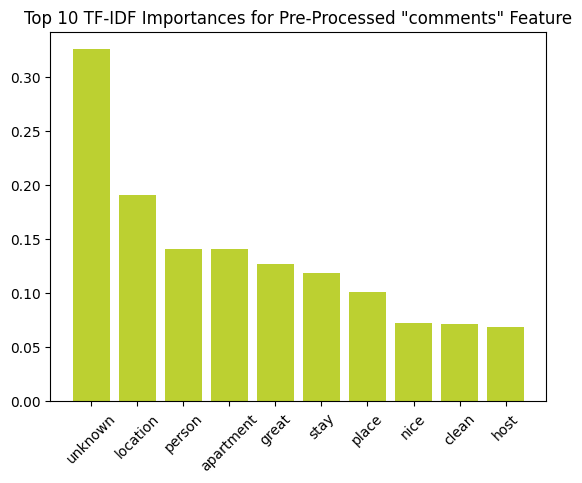

In [24]:
# average term importance

term_averages = np.mean(tfidf_matrix.toarray(), axis=0)
term_avg_relevance_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'average_tfidf_score': term_averages})
term_avg_relevance_df = term_avg_relevance_df.sort_values(by='average_tfidf_score', ascending=False)

top_n = 10
plt.bar(term_avg_relevance_df['term'][:top_n], term_avg_relevance_df['average_tfidf_score'][:top_n], color=[(188/255, 208/255, 49/255)])
plt.xticks(rotation=45)
plt.title(f'Top {top_n} TF-IDF Importances for Pre-Processed "comments" Feature')
plt.show()

#### **GloVe**

- **GloVe Class**

In [25]:
class ExtractGloVe:
    def __init__(self, name, dim, cache_dir=None):
        self.name = name
        self.dim = dim
        self.cache_dir = cache_dir

        if cache_dir:
            self.glove = vocab.GloVe(name=self.name, dim=self.dim, cache=self.cache_dir)
        else:
            self.glove = vocab.GloVe(name=self.name, dim=self.dim)

    def _get_glove_token_embedding(self, word):
        word_idx = self.glove.stoi.get(word)
        if word_idx is None:
            return np.zeros(self.dim)
        return self.glove.vectors[word_idx]

    def get_sentence_embeddings(self, corpus):
        glove_embeddings = []
        for text in tqdm(corpus, total=len(corpus), desc=f'Extracting GloVe Embeddings ({self.dim})'):
            tokenized_text = text.split()
            text_embeddings = np.mean(np.array([self._get_glove_token_embedding(token) for token in tokenized_text]), axis=0)
            glove_embeddings.append(text_embeddings)
        return np.array(glove_embeddings)

- **Creating Datasets**

In [26]:
def create_glove_datasets(data_kwargs, model_name, dim, cache_dir = None):
    # get data
    X_train, X_test, y_train, y_test, train_indices, test_indices = extract_split_datasets(**data_kwargs)

    # get embeddings
    if cache_dir is not None:
        glove = ExtractGloVe(model_name, dim, cache_dir)
    else:
        glove = ExtractGloVe(model_name, dim)

    X_train_glove = glove.get_sentence_embeddings(X_train)
    X_test_glove = glove.get_sentence_embeddings(X_test)

    return X_train_glove, X_test_glove, y_train, y_test, train_indices, test_indices

In [27]:
# dataset 1:

data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None
}
glove_name = '6B'
glove_dim = 50  # allows for 50, 100, 200 and 300

X_train, X_test, y_train, y_test, train_indices, test_indices = create_glove_datasets(data_kwargs, glove_name, glove_dim, GLOVE_CACHE_DIR)

glove_datasets['glove_50d'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices),
}

Extracting GloVe Embeddings (50): 100%|██████████| 1250/1250 [00:18<00:00, 67.55it/s]


In [28]:
# FYI there is a typo in the code - when the print states 'glove_concat'
# it is actually referring to this dataset, we forgot to change the name
# however we are not able to re run it fully due to time constraints

# dataset 2:
data_kwargs = {
    'columns': 'stem_no_stopwords_ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None,
}
glove_name = '6B'
glove_dim = 50

X_train, X_test, y_train, y_test, train_indices, test_indices = create_glove_datasets(data_kwargs, glove_name, glove_dim, GLOVE_CACHE_DIR)

glove_datasets['glove_stem'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices),
}

Extracting GloVe Embeddings (50): 100%|██████████| 1250/1250 [00:17<00:00, 72.40it/s]


In [29]:
# dataset 3:
data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None,
}
glove_name = '6B'
glove_dim = 200

X_train, X_test, y_train, y_test, train_indices, test_indices = create_glove_datasets(data_kwargs, glove_name, glove_dim, GLOVE_CACHE_DIR)

glove_datasets['glove_200d'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices),
}

Extracting GloVe Embeddings (200): 100%|██████████| 1250/1250 [00:19<00:00, 64.37it/s]


#### **Additional #1: XLM-RoBERTa Embeddings**

- **Feature Extractor Class**

This class will be used for both additional methods.

In [30]:
# based on code retrieved from book: Natural Language Processing with Transformers
def plot_umap(X, y, title='UMAP', verbose=0):
    X_scaled = MinMaxScaler().fit_transform(X)
    # Initialize and fit UMAP
    mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
    # Create a DataFrame of 2D embeddings
    df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
    df_emb["label"] = y

    if verbose:
        df_emb.head()

    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes = axes.flatten()
    cmaps = ['Greens', 'Reds']
    labels = ['Listed', 'Unlisted']
    for i, (label, cmap) in enumerate(zip(labels, cmaps)):
        df_emb_sub = df_emb.query(f"label == {i}")
        axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                    gridsize=20, linewidths=(0,))
        axes[i].set_title(label)
        axes[i].set_xticks([]), axes[i].set_yticks([])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [31]:
# helper function to get data splits
# into usable format
def build_joint_dataset(datasets: list[tuple], split_names=None):
    if split_names is None:
        split_names = ['train', 'test'][:len(datasets)]
    joint_dataset = {name: HFDataset.from_dict({'text': ds[0], 'label': ds[1]})
                     for name, ds in zip(split_names, datasets)}
    joint_dataset = DatasetDict(joint_dataset)
    return joint_dataset


def untangle_dataset(datasetdict):
    X_train = np.array(datasetdict["train"]["hidden_state"])
    X_test = np.array(datasetdict["test"]["hidden_state"])
    y_train = np.array(datasetdict["train"]["label"])
    y_test = np.array(datasetdict["test"]["label"])
    return X_train, X_test, y_train, y_test


class FeatureExtractor:
    def __init__(self, model_ckpt, data, device=None):
        self.model_ckpt = model_ckpt
        self.data = data
        self.model = AutoModel.from_pretrained(self.model_ckpt)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_ckpt)
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def _tokenize(self, batch):
        return self.tokenizer(batch['text'], padding="max_length", truncation=True,
                              return_tensors='pt', max_length=512)

    def _extract_hidden_states(self, batch):
        inputs = {k:v.to(self.device) for k,v in batch.items() if k in self.tokenizer.model_input_names}
        with torch.no_grad():
            last_hidden_state = self.model(**inputs).last_hidden_state
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

    def get_embeddings(self):
        print('Tokenizing...')
        data_encoded = self.data.map(self._tokenize, batched=True, batch_size=None)
        print('Extracting hidden states...')
        data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
        data_hidden = data_encoded.map(self._extract_hidden_states, batched=True, batch_size=16)
        return data_hidden

- **XLM-RoBERTa Datasets**

In [32]:
def create_feature_extraction_datasets(data_kwargs, model_ckpt=None, return_joint=False):
    # get data
    X_train, X_test, y_train, y_test, train_indices, test_indices = extract_split_datasets(**data_kwargs)

    # get into dict: for efficienty reasons
    datasets = [
        (X_train, y_train),
        (X_test, y_test)
    ]
    joint_dataset = build_joint_dataset(datasets)

    if return_joint:
        return joint_dataset

    # get embbedings
    feature_extractor = FeatureExtractor(model_ckpt, joint_dataset)
    hidden_dataset = feature_extractor.get_embeddings()

    # example of how the dataset looks (based on PyArrow)
    # DatasetDict({
    #     train: Dataset({
    #         features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    #         num_rows: 4998
    #     })
    #     test: Dataset({
    #         features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    #         num_rows: 1250
    #     })
    # })

    return *untangle_dataset(hidden_dataset), train_indices, test_indices

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizing...


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

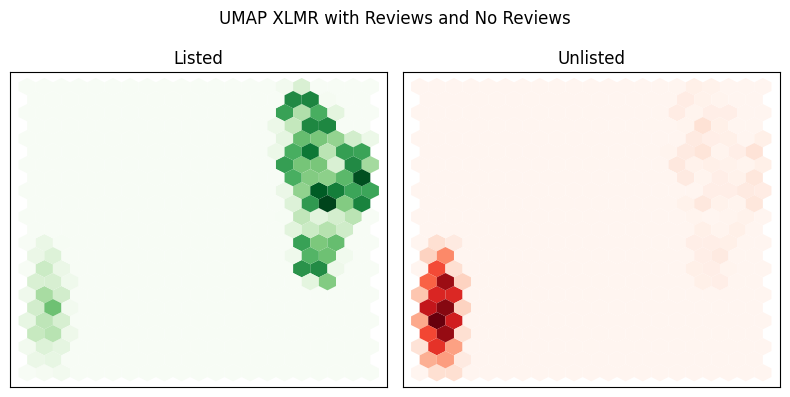

In [33]:
# dataset 1:
data_kwargs = {
    'columns': 'ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'xlm-roberta-base')

xlmr_datasets['xlmr_reviews'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP XLMR with Reviews and No Reviews')

Tokenizing...


Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

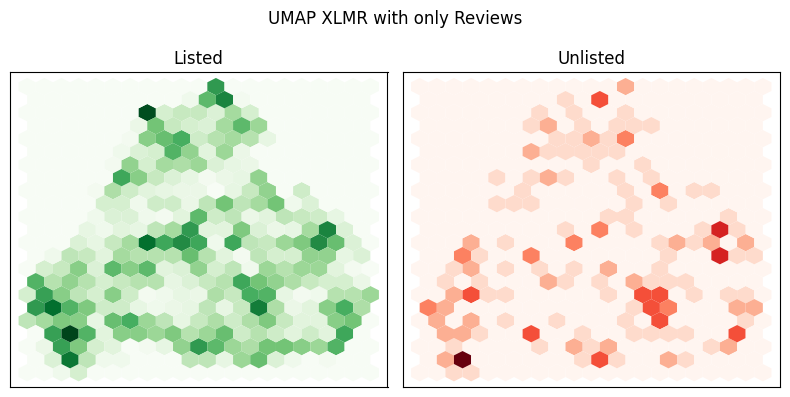

In [34]:
# dataset 2:
data_kwargs = {
    'columns': 'ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'xlm-roberta-base')

xlmr_datasets['xlmr_reviews_only'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP XLMR with only Reviews')

Tokenizing...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

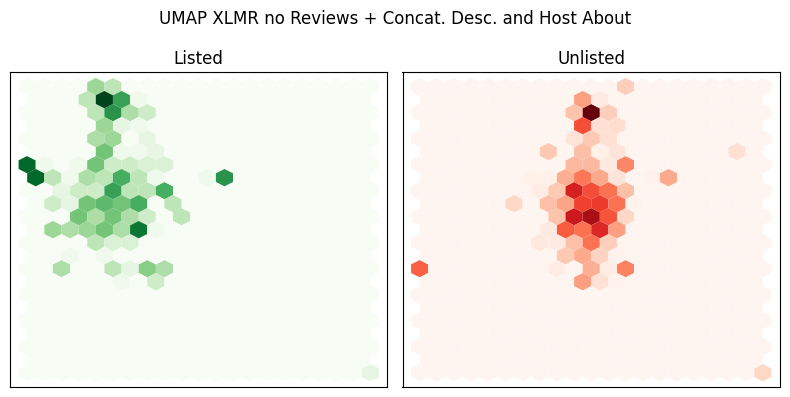

In [35]:
# dataset 3:
data_kwargs = {
    'columns': ['lemma_no_stopwords_ner_trans_clean_description', 'lemma_no_stopwords_ner_trans_clean_host_about'],
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-no-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'xlm-roberta-base')

xlmr_datasets['xlmr_concat_no_reviews'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP XLMR no Reviews + Concat. Desc. and Host About')

Tokenizing...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

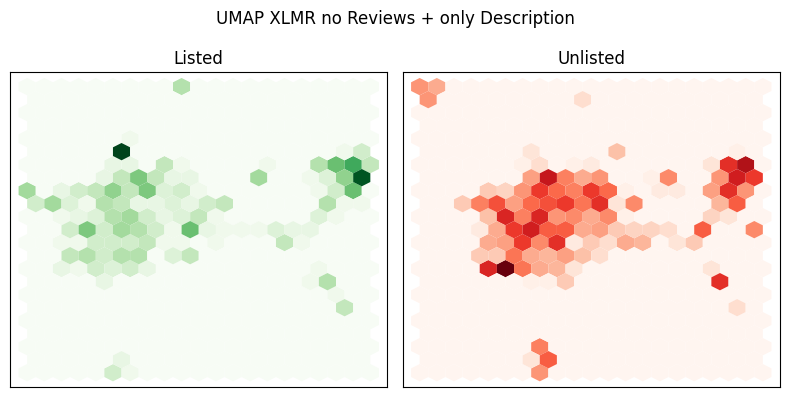

In [36]:
# dataset 4:
data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_description',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-no-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'xlm-roberta-base')

xlmr_datasets['xlmr_description_only'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP XLMR no Reviews + only Description')

Tokenizing...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

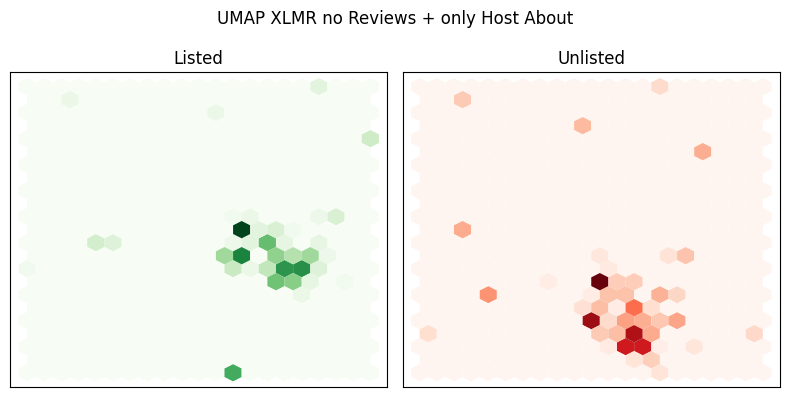

In [37]:
# dataset 5:
data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_host_about',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-no-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'xlm-roberta-base')

xlmr_datasets['xlmr_host_about_only'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP XLMR no Reviews + only Host About')

#### **Additional #2 - mBERT Embeddings**

- **mBERT Datasets**

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Tokenizing...


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/4998 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

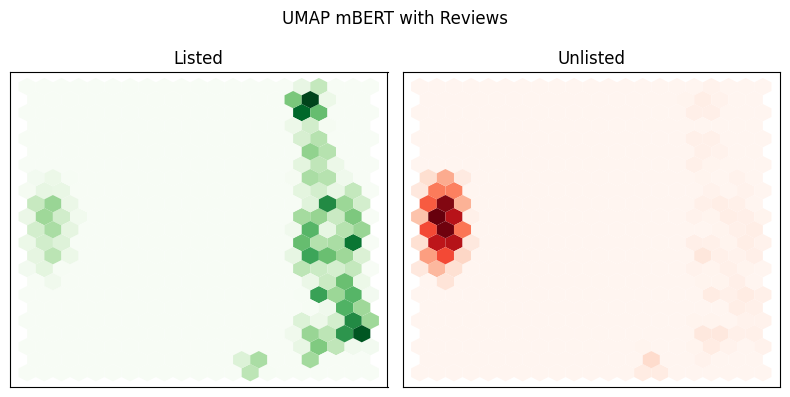

In [38]:
# dataset 1:
data_kwargs = {
    'columns': 'ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'google-bert/bert-base-multilingual-uncased')

mbert_datasets['mbert_reviews'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP mBERT with Reviews')

Tokenizing...


Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/3396 [00:00<?, ? examples/s]

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

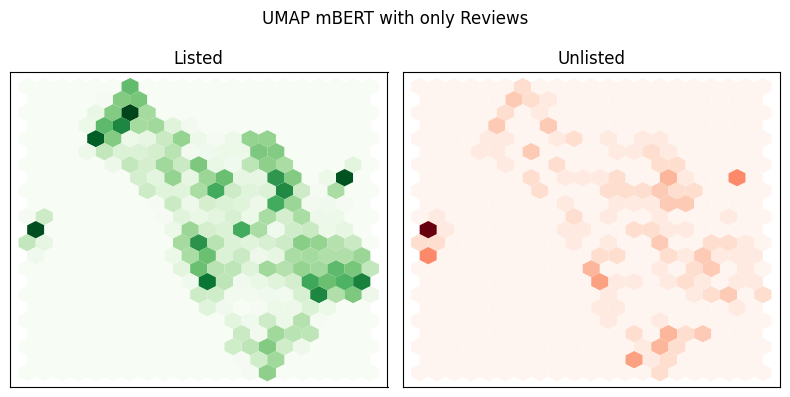

In [39]:
# dataset 2:
data_kwargs = {
    'columns': 'ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'google-bert/bert-base-multilingual-uncased')

mbert_datasets['mbert_reviews_only'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP mBERT with only Reviews')

Tokenizing...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

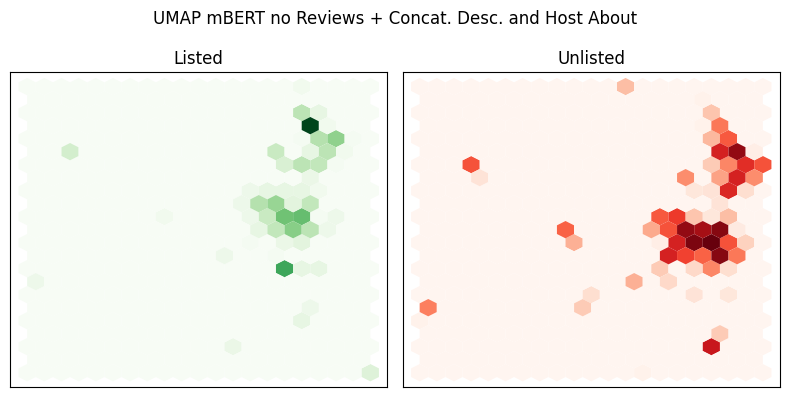

In [40]:
# dataset 3:
data_kwargs = {
    'columns': ['lemma_no_stopwords_ner_trans_clean_description', 'lemma_no_stopwords_ner_trans_clean_host_about'],
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-no-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'google-bert/bert-base-multilingual-uncased')

mbert_datasets['mbert_concat'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP mBERT no Reviews + Concat. Desc. and Host About')

Tokenizing...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

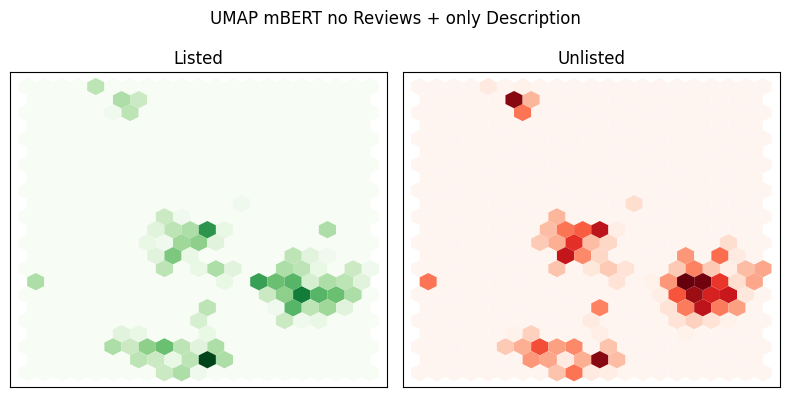

In [41]:
# dataset 4:
data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_description',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-no-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'google-bert/bert-base-multilingual-uncased')

mbert_datasets['mbert_description'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP mBERT no Reviews + only Description')

Tokenizing...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Extracting hidden states...


Map:   0%|          | 0/1602 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

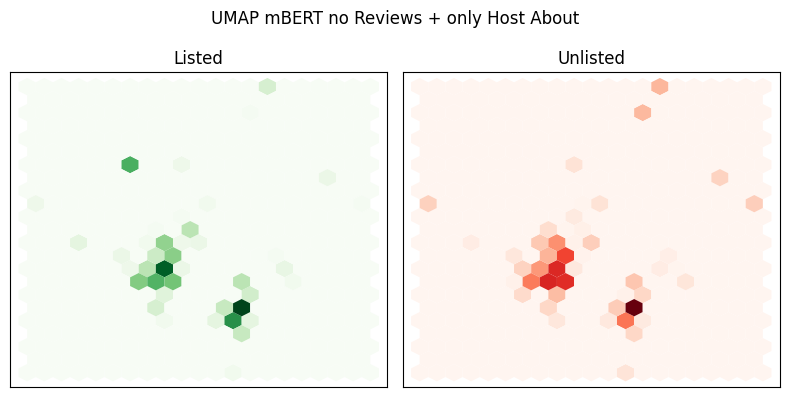

In [42]:
# dataset 5:
data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_host_about',
    'group': True,
    'concat_features': True,
    'handle_reviews': 'keep-no-reviews',
    'lang': 'all',
    'lang_col': None,
}

X_train, X_test, y_train, y_test, train_indices, test_indices = create_feature_extraction_datasets(data_kwargs, 'google-bert/bert-base-multilingual-uncased')

mbert_datasets['mbert_host_about'] = {
    'X_train': deepcopy(X_train),
    'X_test': deepcopy(X_test),
    'y_train': deepcopy(y_train),
    'y_test': deepcopy(y_test),
    'train_indices': deepcopy(train_indices),
    'test_indices': deepcopy(test_indices)
}

plot_umap(X_train, y_train, title='UMAP mBERT no Reviews + only Host About')

## **Model Development**<a id='model-dev'></a>

#### **Functions**

In [54]:
# e.g. at least the following
# glove sentence embeddings: 50d
# word2vec sentence embeddings: 50d
# xlm-roberta sentence embeddings
# mt5 sentence embeddings

def join_embeddings_dicts(*dicts):
    embeddings_dict = {}
    for dic in dicts:
        if dic:
            embeddings_dict.update(dic)
    return embeddings_dict


datasets = (
    tfidf_datasets,
    glove_datasets,
    xlmr_datasets,
    mbert_datasets
)

embeddings_dict = join_embeddings_dicts(*datasets)

# print(f'Embeddings: {list(embeddings_dict.keys())}')

for name, splits in embeddings_dict.items():
    print(f"{name} X_train shape: {splits['X_train'].shape}")

tfidf X_train shape: (4952,)
glove_50d X_train shape: (4998, 50)
glove_concat X_train shape: (4998, 50)
glove_200d X_train shape: (4998, 200)
xlmr_reviews X_train shape: (4998, 768)
xlmr_reviews_only X_train shape: (3396, 768)
xlmr_concat_no_reviews X_train shape: (1602, 768)
xlmr_description_only X_train shape: (1602, 768)
xlmr_host_about_only X_train shape: (1602, 768)
mbert_reviews X_train shape: (4998, 768)
mbert_reviews_only X_train shape: (3396, 768)
mbert_concat X_train shape: (1602, 768)
mbert_description X_train shape: (1602, 768)
mbert_host_about X_train shape: (1602, 768)


In [6]:
def plot_confusion_matrix(y_true, y_preds, labels=['Listed', 'Unlisted'], title='Confusion Matrix of the Test Dataset'):
    cm = confusion_matrix(y_true, y_preds) # normalize='true'
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title(title)
    plt.show()


def show_classification_report(preds_dict, th=None):

    for embed, preds in preds_dict.items():

        if th is not None:
            y_train_true = preds['train_true']
            y_train_pred = (preds['train_pred'][:, 1] >= th).astype(int)
            y_test_true = preds['test_true']
            y_test_pred = (preds['test_pred'][:, 1] >= th).astype(int)
        else:
            y_train_true = preds['train_true']
            y_train_pred = preds['train_pred']
            y_test_true = preds['test_true']
            y_test_pred = preds['test_pred']

        print(f"Classification report for {embed} - Training")
        print(classification_report(y_train_true, y_train_pred, digits=4))

        print(f"\nClassification report for {embed} - Test data")
        print(classification_report(y_test_true, y_test_pred, digits=4))

        plot_confusion_matrix(y_test_true, y_test_pred, title=f"{embed} Test's Conf. Matrix")

        print('\n------------------------------------------------------\n')

In [48]:
def train_sklearn_classifier(clf, embeddings_dict,
                             *,
                             grid_search=False,
                             param_grid=None,
                             grid_kwargs=None,
                             predict_proba=True,
                             verbose=0):

    preds_dict = {}
    fitted_clf_dict = {}
    for embed, splits in embeddings_dict.items():

        if verbose:
            print(f"Fitting {embed}...")
            start = time.perf_counter()

        X_train = splits['X_train']
        X_test = splits['X_test']
        y_train = splits['y_train']
        y_test = splits['y_test']

        if 'tfidf' in embed:
            X_train = pd.Series(X_train); X_test = pd.Series(X_test)
            y_train = pd.Series(y_train); y_test = pd.Series(y_test)
            vectorizer = splits['vectorizer']

            if not grid_search:
                X_train = vectorizer.fit_transform(X_train)
                X_test = vectorizer.transform(X_test)

        if grid_search:
            # TF-IDF is the only embedding function that needs
            # to be fitted beforehand, hence we need a pipeline
            # to avoid data leakage
            if 'tfidf' in embed:
                pipe = Pipeline([('vectorizer', vectorizer), ('clf', clf)])
                special_param_grid = {f'clf__{k}': v for k,v in param_grid.items()}  # sklearn convention to tune a specific param in a specific pipeline step
                grid = GridSearchCV(pipe, special_param_grid, **grid_kwargs)
            else:
                grid = GridSearchCV(clf, param_grid, random_state=SEED, **grid_kwargs) # refit needs to be always True

            grid.fit(X_train, y_train)  # reshaping because X needs to be 2D array
            print(f"{embed} best params: {grid.best_params_}")
        else:
            clf.fit(X_train, y_train)

        # note that if refit = True, grid is a trained classifier on the best set of params
        if predict_proba:
            train_pred = grid.predict_proba(X_train) if grid_search else clf.predict_proba(X_train)
            test_pred = grid.predict_proba(X_test) if grid_search else clf.predict_proba(X_test)
        else:
            train_pred = grid.predict(X_train) if grid_search else clf.predict(X_train)
            test_pred = grid.predict(X_test) if grid_search else clf.predict(X_test)

        preds_dict[embed] = {'train_true': deepcopy(y_train),
                             'test_true': deepcopy(y_test),
                             'train_pred': deepcopy(train_pred),
                             'test_pred': deepcopy(test_pred),
                             'train_indices': splits['train_indices'],
                             'test_indices': splits['test_indices']}

        # fitted_clf_dict[embed] = deepcopy(grid.best_estimator_) if grid_search else deepcopy(clf)
        fitted_clf_dict[embed] = deepcopy(grid) if grid_search else deepcopy(clf)

        if verbose:
            print(f"It took: {time.perf_counter() - start:0.2f} seconds.")
            print()

    return preds_dict, fitted_clf_dict

#### **Rule-Based Model i.e. Our Baseline**

              precision    recall  f1-score   support

           0     0.9370    0.8763    0.9056      3631
           1     0.7197    0.8435    0.7767      1367

    accuracy                         0.8673      4998
   macro avg     0.8284    0.8599    0.8412      4998
weighted avg     0.8776    0.8673    0.8704      4998

              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



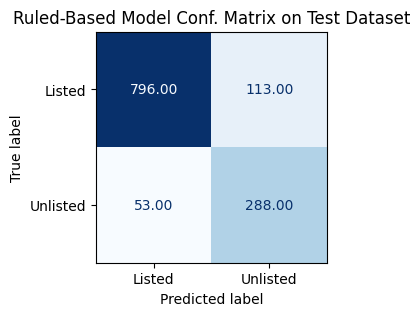

In [7]:
# as we've seen during data exploration we know that if a property
# has at least one review  then its chance of remaining listed is
# about 97%. Whereas if that house has no reviews then its chance of
# remaning listed is only about 30%. Hence our logic can be defined as
# follows:
# IF property has no reviews => predict 1 (i.e. will be unlisted)
# ELSE predict 0 (will remain listed)


data_kwargs = {
    'columns': 'trans_clean_comments',  # doesn't really matter what colum we choose here
    'group': True,
    'drop_property_index': False, # !!!
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None
}

train_df, test_df = load_preprocessed_data(**data_kwargs)

train_indices = train_df['property_index'].to_numpy()
test_indices = test_df['property_index'].to_numpy()

def ruled_based_predictions(corpus):
    # FYI during pre proc we replaced nulls with 'unknown'
    return [1 if doc == 'unknown' else 0 for doc in corpus]

y_train = train_df['unlisted'].to_numpy()
y_test = test_df['unlisted'].to_numpy()

train_pred = np.array(ruled_based_predictions(train_df[data_kwargs['columns']]))
test_pred = np.array(ruled_based_predictions(test_df[data_kwargs['columns']]))

print(classification_report(y_train, train_pred, digits=4))
print(classification_report(y_test, test_pred, digits=4))
plot_confusion_matrix(y_test, test_pred, title=f"Ruled-Based Model Conf. Matrix on Test Dataset")

# Adding as dict
rule_based_preds_dict = {
    'ruled_based': {
        'train_true': deepcopy(y_train),
        'test_true': deepcopy(y_test),
        'train_pred': deepcopy(train_pred),
        'test_pred': deepcopy(test_pred),
        'train_indices': deepcopy(train_indices),
        'test_indices': deepcopy(test_indices),
    }
}

#### **K-Nearest Neighbors**

Fitting tfidf...
It took: 271.55 seconds.

Fitting glove_50d...
It took: 0.30 seconds.

Fitting glove_concat...
It took: 0.09 seconds.

Fitting glove_200d...
It took: 0.23 seconds.

Fitting xlmr_reviews...
It took: 1.18 seconds.

Fitting xlmr_reviews_only...
It took: 0.28 seconds.

Fitting xlmr_concat_no_reviews...
It took: 0.47 seconds.

Fitting xlmr_description_only...
It took: 0.68 seconds.

Fitting xlmr_host_about_only...
It took: 0.37 seconds.

Fitting mbert_reviews...
It took: 0.43 seconds.

Fitting mbert_reviews_only...
It took: 0.19 seconds.

Fitting mbert_concat...
It took: 0.05 seconds.

Fitting mbert_description...
It took: 0.06 seconds.

Fitting mbert_host_about...
It took: 0.05 seconds.


Classification report for tfidf - Training
              precision    recall  f1-score   support

           0     0.9388    0.8715    0.9039      3588
           1     0.7156    0.8504    0.7772      1364

    accuracy                         0.8657      4952
   macro avg     0.8272    0

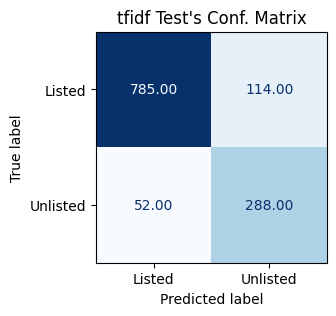


------------------------------------------------------

Classification report for glove_50d - Training
              precision    recall  f1-score   support

           0     0.9383    0.8750    0.9055      3631
           1     0.7184    0.8471    0.7774      1367

    accuracy                         0.8673      4998
   macro avg     0.8283    0.8610    0.8415      4998
weighted avg     0.8781    0.8673    0.8705      4998


Classification report for glove_50d - Test data
              precision    recall  f1-score   support

           0     0.9375    0.8746    0.9050       909
           1     0.7164    0.8446    0.7752       341

    accuracy                         0.8664      1250
   macro avg     0.8270    0.8596    0.8401      1250
weighted avg     0.8772    0.8664    0.8696      1250



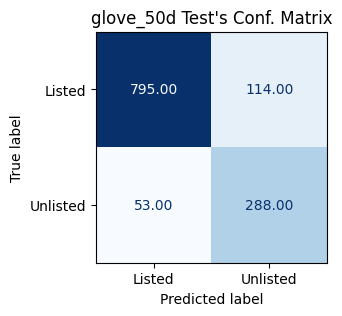


------------------------------------------------------

Classification report for glove_concat - Training
              precision    recall  f1-score   support

           0     0.9386    0.8761    0.9063      3631
           1     0.7203    0.8478    0.7789      1367

    accuracy                         0.8683      4998
   macro avg     0.8295    0.8620    0.8426      4998
weighted avg     0.8789    0.8683    0.8714      4998


Classification report for glove_concat - Test data
              precision    recall  f1-score   support

           0     0.9375    0.8746    0.9050       909
           1     0.7164    0.8446    0.7752       341

    accuracy                         0.8664      1250
   macro avg     0.8270    0.8596    0.8401      1250
weighted avg     0.8772    0.8664    0.8696      1250



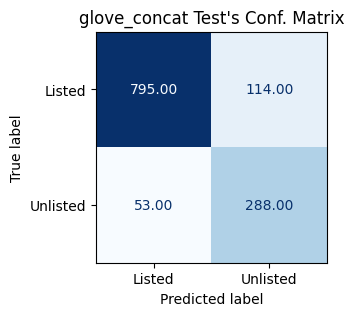


------------------------------------------------------

Classification report for glove_200d - Training
              precision    recall  f1-score   support

           0     0.9372    0.8755    0.9053      3631
           1     0.7186    0.8442    0.7763      1367

    accuracy                         0.8669      4998
   macro avg     0.8279    0.8599    0.8408      4998
weighted avg     0.8774    0.8669    0.8700      4998


Classification report for glove_200d - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



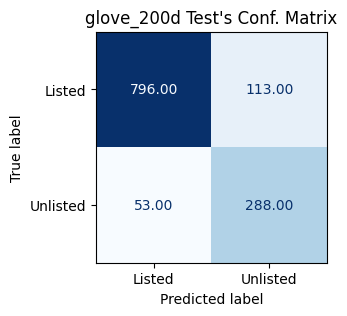


------------------------------------------------------

Classification report for xlmr_reviews - Training
              precision    recall  f1-score   support

           0     0.9389    0.8758    0.9062      3631
           1     0.7200    0.8486    0.7790      1367

    accuracy                         0.8683      4998
   macro avg     0.8295    0.8622    0.8426      4998
weighted avg     0.8790    0.8683    0.8715      4998


Classification report for xlmr_reviews - Test data
              precision    recall  f1-score   support

           0     0.9375    0.8746    0.9050       909
           1     0.7164    0.8446    0.7752       341

    accuracy                         0.8664      1250
   macro avg     0.8270    0.8596    0.8401      1250
weighted avg     0.8772    0.8664    0.8696      1250



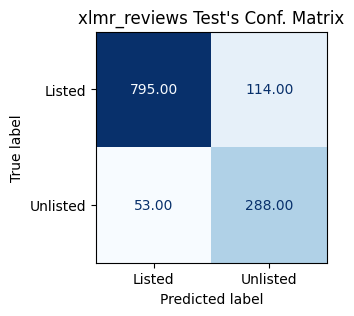


------------------------------------------------------

Classification report for xlmr_reviews_only - Training
              precision    recall  f1-score   support

           0     0.9389    0.9994    0.9682      3182
           1     0.7778    0.0327    0.0628       214

    accuracy                         0.9385      3396
   macro avg     0.8583    0.5160    0.5155      3396
weighted avg     0.9287    0.9385    0.9111      3396


Classification report for xlmr_reviews_only - Test data
              precision    recall  f1-score   support

           0     0.9375    0.9987    0.9672       796
           1     0.0000    0.0000    0.0000        53

    accuracy                         0.9364       849
   macro avg     0.4688    0.4994    0.4836       849
weighted avg     0.8790    0.9364    0.9068       849



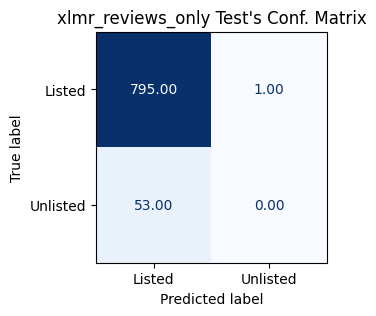


------------------------------------------------------

Classification report for xlmr_concat_no_reviews - Training
              precision    recall  f1-score   support

           0     0.7721    0.4677    0.5825       449
           1     0.8203    0.9462    0.8788      1153

    accuracy                         0.8121      1602
   macro avg     0.7962    0.7070    0.7306      1602
weighted avg     0.8068    0.8121    0.7957      1602


Classification report for xlmr_concat_no_reviews - Test data
              precision    recall  f1-score   support

           0     0.5806    0.3186    0.4114       113
           1     0.7729    0.9097    0.8357       288

    accuracy                         0.7431       401
   macro avg     0.6768    0.6142    0.6236       401
weighted avg     0.7187    0.7431    0.7162       401



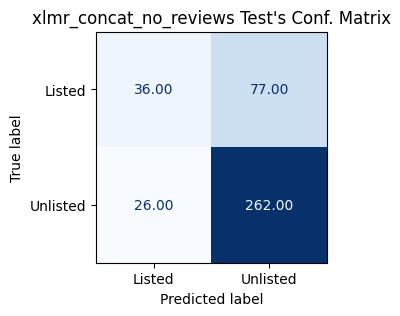


------------------------------------------------------

Classification report for xlmr_description_only - Training
              precision    recall  f1-score   support

           0     0.7702    0.4254    0.5481       449
           1     0.8095    0.9506    0.8744      1153

    accuracy                         0.8034      1602
   macro avg     0.7898    0.6880    0.7112      1602
weighted avg     0.7984    0.8034    0.7829      1602


Classification report for xlmr_description_only - Test data
              precision    recall  f1-score   support

           0     0.6154    0.2124    0.3158       113
           1     0.7541    0.9479    0.8400       288

    accuracy                         0.7406       401
   macro avg     0.6848    0.5802    0.5779       401
weighted avg     0.7150    0.7406    0.6923       401



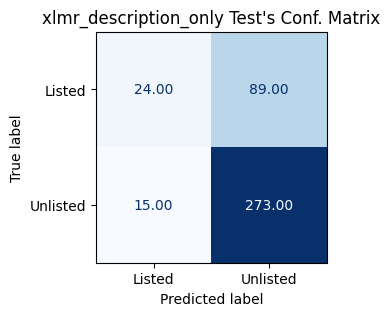


------------------------------------------------------

Classification report for xlmr_host_about_only - Training
              precision    recall  f1-score   support

           0     0.7560    0.4900    0.5946       449
           1     0.8253    0.9384    0.8782      1153

    accuracy                         0.8127      1602
   macro avg     0.7907    0.7142    0.7364      1602
weighted avg     0.8059    0.8127    0.7987      1602


Classification report for xlmr_host_about_only - Test data
              precision    recall  f1-score   support

           0     0.5714    0.3186    0.4091       113
           1     0.7722    0.9062    0.8339       288

    accuracy                         0.7406       401
   macro avg     0.6718    0.6124    0.6215       401
weighted avg     0.7156    0.7406    0.7142       401



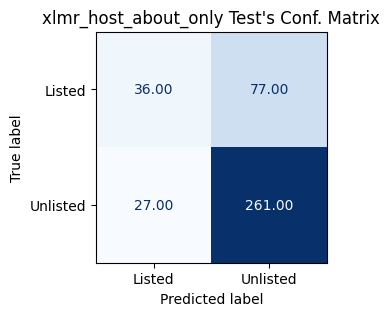


------------------------------------------------------

Classification report for mbert_reviews - Training
              precision    recall  f1-score   support

           0     0.9389    0.8763    0.9066      3631
           1     0.7209    0.8486    0.7796      1367

    accuracy                         0.8687      4998
   macro avg     0.8299    0.8625    0.8431      4998
weighted avg     0.8793    0.8687    0.8718      4998


Classification report for mbert_reviews - Test data
              precision    recall  f1-score   support

           0     0.9375    0.8746    0.9050       909
           1     0.7164    0.8446    0.7752       341

    accuracy                         0.8664      1250
   macro avg     0.8270    0.8596    0.8401      1250
weighted avg     0.8772    0.8664    0.8696      1250



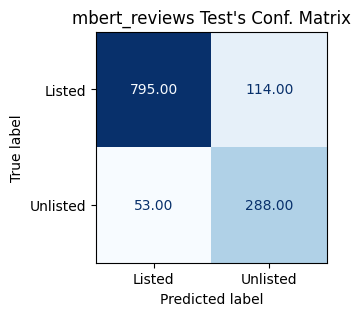


------------------------------------------------------

Classification report for mbert_reviews_only - Training
              precision    recall  f1-score   support

           0     0.9389    1.0000    0.9685      3182
           1     1.0000    0.0327    0.0633       214

    accuracy                         0.9390      3396
   macro avg     0.9695    0.5164    0.5159      3396
weighted avg     0.9428    0.9390    0.9115      3396


Classification report for mbert_reviews_only - Test data
              precision    recall  f1-score   support

           0     0.9375    0.9987    0.9672       796
           1     0.0000    0.0000    0.0000        53

    accuracy                         0.9364       849
   macro avg     0.4688    0.4994    0.4836       849
weighted avg     0.8790    0.9364    0.9068       849



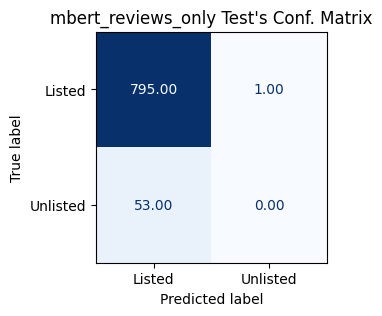


------------------------------------------------------

Classification report for mbert_concat - Training
              precision    recall  f1-score   support

           0     0.7795    0.4410    0.5633       449
           1     0.8138    0.9514    0.8772      1153

    accuracy                         0.8084      1602
   macro avg     0.7967    0.6962    0.7203      1602
weighted avg     0.8042    0.8084    0.7893      1602


Classification report for mbert_concat - Test data
              precision    recall  f1-score   support

           0     0.5714    0.3186    0.4091       113
           1     0.7722    0.9062    0.8339       288

    accuracy                         0.7406       401
   macro avg     0.6718    0.6124    0.6215       401
weighted avg     0.7156    0.7406    0.7142       401



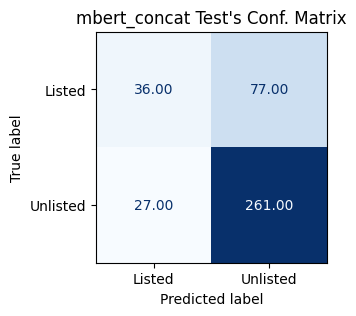


------------------------------------------------------

Classification report for mbert_description - Training
              precision    recall  f1-score   support

           0     0.7736    0.3653    0.4962       449
           1     0.7950    0.9584    0.8691      1153

    accuracy                         0.7921      1602
   macro avg     0.7843    0.6618    0.6826      1602
weighted avg     0.7890    0.7921    0.7646      1602


Classification report for mbert_description - Test data
              precision    recall  f1-score   support

           0     0.5102    0.2212    0.3086       113
           1     0.7500    0.9167    0.8250       288

    accuracy                         0.7207       401
   macro avg     0.6301    0.5690    0.5668       401
weighted avg     0.6824    0.7207    0.6795       401



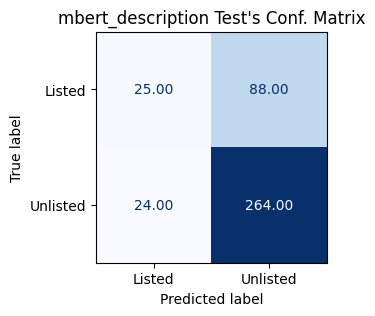


------------------------------------------------------

Classification report for mbert_host_about - Training
              precision    recall  f1-score   support

           0     0.7329    0.4766    0.5776       449
           1     0.8206    0.9324    0.8729      1153

    accuracy                         0.8046      1602
   macro avg     0.7767    0.7045    0.7253      1602
weighted avg     0.7960    0.8046    0.7901      1602


Classification report for mbert_host_about - Test data
              precision    recall  f1-score   support

           0     0.5765    0.4336    0.4949       113
           1     0.7975    0.8750    0.8344       288

    accuracy                         0.7506       401
   macro avg     0.6870    0.6543    0.6647       401
weighted avg     0.7352    0.7506    0.7388       401



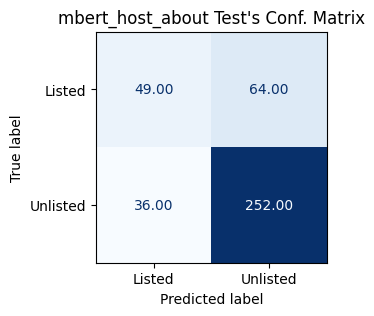


------------------------------------------------------



In [55]:
knn_param_grid = {
    'n_neighbors': np.arange(5, 25, 5),  # Number of neighbors to use
    'p': [1, 2]  # Power parameter for the Minkowski metric
}

knn_grid_kwargs = {
    'cv': StratifiedKFold(n_splits=5),
    'scoring': 'f1',
    'return_train_score': False,
    'verbose': 1
}

knn = KNeighborsClassifier(n_neighbors=5)
knn_preds_dict, knn_fitted_dict = train_sklearn_classifier(knn, embeddings_dict, grid_search=False, param_grid=knn_param_grid, grid_kwargs=knn_grid_kwargs, predict_proba=True, verbose=1)
print()
show_classification_report(knn_preds_dict, th=.5)

#### **Logistic Regression**

Fitting tfidf...
It took: 4.31 seconds.

Fitting glove_50d...
It took: 0.04 seconds.

Fitting glove_concat...
It took: 0.04 seconds.

Fitting glove_200d...
It took: 0.07 seconds.

Fitting xlmr_reviews...
It took: 0.12 seconds.

Fitting xlmr_reviews_only...
It took: 0.10 seconds.

Fitting xlmr_concat_no_reviews...
It took: 0.06 seconds.

Fitting xlmr_description_only...
It took: 0.08 seconds.

Fitting xlmr_host_about_only...
It took: 0.07 seconds.

Fitting mbert_reviews...
It took: 0.20 seconds.

Fitting mbert_reviews_only...
It took: 0.14 seconds.

Fitting mbert_concat...
It took: 0.12 seconds.

Fitting mbert_description...
It took: 0.09 seconds.

Fitting mbert_host_about...
It took: 0.09 seconds.


Classification report for tfidf - Training
              precision    recall  f1-score   support

           0     0.9370    0.8746    0.9047      3588
           1     0.7193    0.8453    0.7772      1364

    accuracy                         0.8665      4952
   macro avg     0.8281    0.8

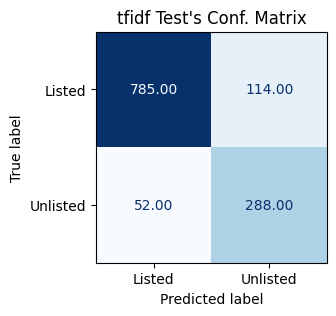


------------------------------------------------------

Classification report for glove_50d - Training
              precision    recall  f1-score   support

           0     0.9370    0.8763    0.9056      3631
           1     0.7197    0.8435    0.7767      1367

    accuracy                         0.8673      4998
   macro avg     0.8284    0.8599    0.8412      4998
weighted avg     0.8776    0.8673    0.8704      4998


Classification report for glove_50d - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



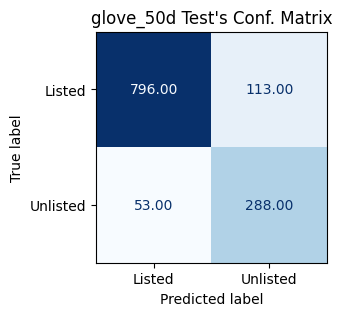


------------------------------------------------------

Classification report for glove_concat - Training
              precision    recall  f1-score   support

           0     0.9370    0.8763    0.9056      3631
           1     0.7197    0.8435    0.7767      1367

    accuracy                         0.8673      4998
   macro avg     0.8284    0.8599    0.8412      4998
weighted avg     0.8776    0.8673    0.8704      4998


Classification report for glove_concat - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



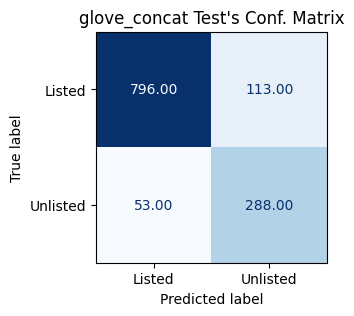


------------------------------------------------------

Classification report for glove_200d - Training
              precision    recall  f1-score   support

           0     0.9370    0.8763    0.9056      3631
           1     0.7197    0.8435    0.7767      1367

    accuracy                         0.8673      4998
   macro avg     0.8284    0.8599    0.8412      4998
weighted avg     0.8776    0.8673    0.8704      4998


Classification report for glove_200d - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



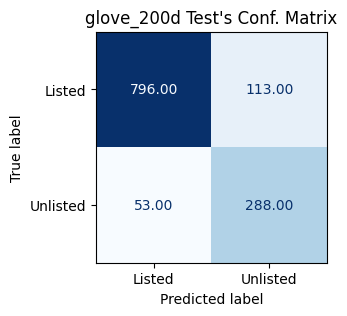


------------------------------------------------------

Classification report for xlmr_reviews - Training
              precision    recall  f1-score   support

           0     0.9369    0.8758    0.9053      3631
           1     0.7188    0.8435    0.7762      1367

    accuracy                         0.8669      4998
   macro avg     0.8279    0.8596    0.8408      4998
weighted avg     0.8773    0.8669    0.8700      4998


Classification report for xlmr_reviews - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



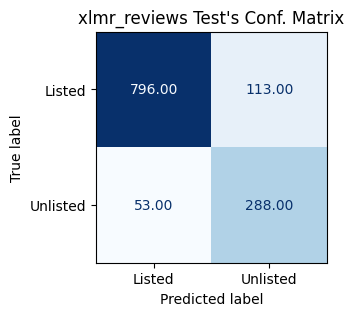


------------------------------------------------------

Classification report for xlmr_reviews_only - Training
              precision    recall  f1-score   support

           0     0.9370    1.0000    0.9675      3182
           1     0.0000    0.0000    0.0000       214

    accuracy                         0.9370      3396
   macro avg     0.4685    0.5000    0.4837      3396
weighted avg     0.8779    0.9370    0.9065      3396


Classification report for xlmr_reviews_only - Test data
              precision    recall  f1-score   support

           0     0.9376    1.0000    0.9678       796
           1     0.0000    0.0000    0.0000        53

    accuracy                         0.9376       849
   macro avg     0.4688    0.5000    0.4839       849
weighted avg     0.8790    0.9376    0.9074       849



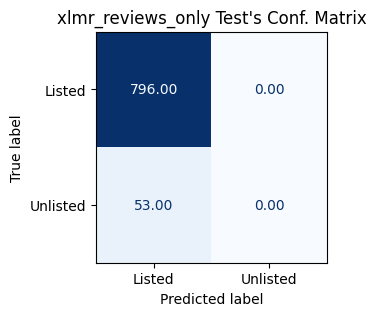


------------------------------------------------------

Classification report for xlmr_concat_no_reviews - Training
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       449
           1     0.7197    1.0000    0.8370      1153

    accuracy                         0.7197      1602
   macro avg     0.3599    0.5000    0.4185      1602
weighted avg     0.5180    0.7197    0.6024      1602


Classification report for xlmr_concat_no_reviews - Test data
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       113
           1     0.7182    1.0000    0.8360       288

    accuracy                         0.7182       401
   macro avg     0.3591    0.5000    0.4180       401
weighted avg     0.5158    0.7182    0.6004       401



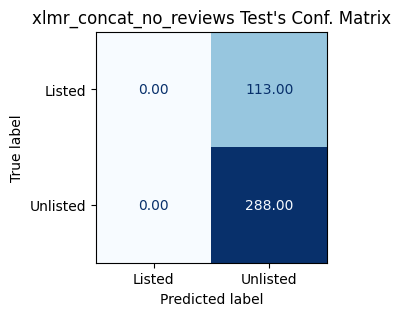


------------------------------------------------------

Classification report for xlmr_description_only - Training
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       449
           1     0.7197    1.0000    0.8370      1153

    accuracy                         0.7197      1602
   macro avg     0.3599    0.5000    0.4185      1602
weighted avg     0.5180    0.7197    0.6024      1602


Classification report for xlmr_description_only - Test data
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       113
           1     0.7182    1.0000    0.8360       288

    accuracy                         0.7182       401
   macro avg     0.3591    0.5000    0.4180       401
weighted avg     0.5158    0.7182    0.6004       401



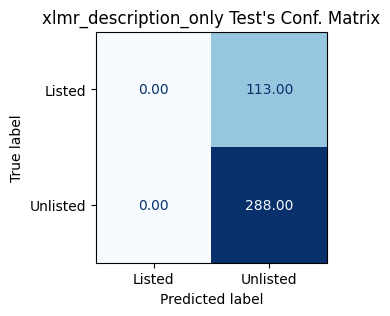


------------------------------------------------------

Classification report for xlmr_host_about_only - Training
              precision    recall  f1-score   support

           0     1.0000    0.0111    0.0220       449
           1     0.7220    1.0000    0.8385      1153

    accuracy                         0.7228      1602
   macro avg     0.8610    0.5056    0.4303      1602
weighted avg     0.7999    0.7228    0.6097      1602


Classification report for xlmr_host_about_only - Test data
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       113
           1     0.7182    1.0000    0.8360       288

    accuracy                         0.7182       401
   macro avg     0.3591    0.5000    0.4180       401
weighted avg     0.5158    0.7182    0.6004       401



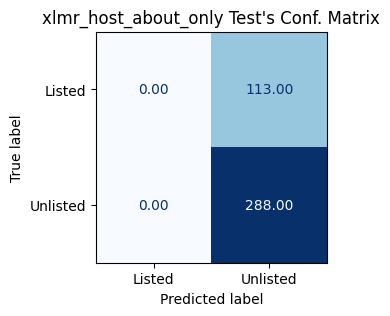


------------------------------------------------------

Classification report for mbert_reviews - Training
              precision    recall  f1-score   support

           0     0.9370    0.8763    0.9056      3631
           1     0.7197    0.8435    0.7767      1367

    accuracy                         0.8673      4998
   macro avg     0.8284    0.8599    0.8412      4998
weighted avg     0.8776    0.8673    0.8704      4998


Classification report for mbert_reviews - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



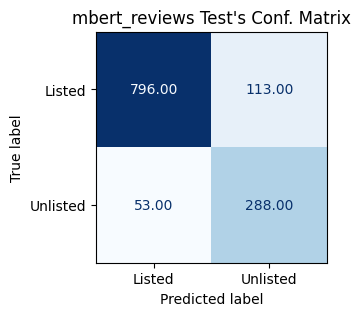


------------------------------------------------------

Classification report for mbert_reviews_only - Training
              precision    recall  f1-score   support

           0     0.9370    1.0000    0.9675      3182
           1     0.0000    0.0000    0.0000       214

    accuracy                         0.9370      3396
   macro avg     0.4685    0.5000    0.4837      3396
weighted avg     0.8779    0.9370    0.9065      3396


Classification report for mbert_reviews_only - Test data
              precision    recall  f1-score   support

           0     0.9376    1.0000    0.9678       796
           1     0.0000    0.0000    0.0000        53

    accuracy                         0.9376       849
   macro avg     0.4688    0.5000    0.4839       849
weighted avg     0.8790    0.9376    0.9074       849



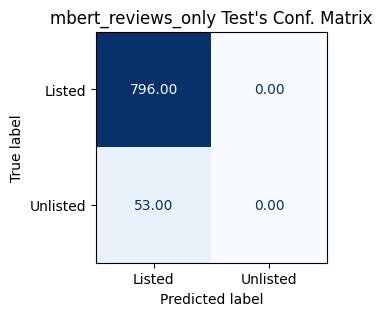


------------------------------------------------------

Classification report for mbert_concat - Training
              precision    recall  f1-score   support

           0     0.9070    0.1737    0.2916       449
           1     0.7553    0.9931    0.8580      1153

    accuracy                         0.7634      1602
   macro avg     0.8311    0.5834    0.5748      1602
weighted avg     0.7978    0.7634    0.6992      1602


Classification report for mbert_concat - Test data
              precision    recall  f1-score   support

           0     0.8214    0.2035    0.3262       113
           1     0.7587    0.9826    0.8563       288

    accuracy                         0.7631       401
   macro avg     0.7901    0.5931    0.5913       401
weighted avg     0.7764    0.7631    0.7069       401



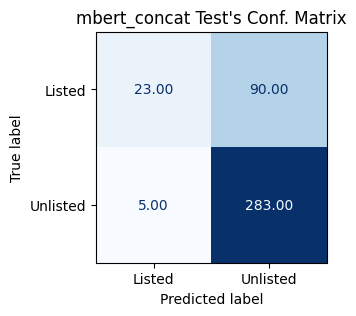


------------------------------------------------------

Classification report for mbert_description - Training
              precision    recall  f1-score   support

           0     0.8776    0.1915    0.3144       449
           1     0.7586    0.9896    0.8589      1153

    accuracy                         0.7659      1602
   macro avg     0.8181    0.5906    0.5867      1602
weighted avg     0.7920    0.7659    0.7063      1602


Classification report for mbert_description - Test data
              precision    recall  f1-score   support

           0     0.6000    0.1062    0.1805       113
           1     0.7349    0.9722    0.8371       288

    accuracy                         0.7282       401
   macro avg     0.6675    0.5392    0.5088       401
weighted avg     0.6969    0.7282    0.6520       401



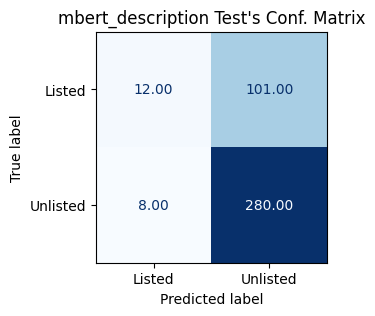


------------------------------------------------------

Classification report for mbert_host_about - Training
              precision    recall  f1-score   support

           0     0.8760    0.2361    0.3719       449
           1     0.7684    0.9870    0.8641      1153

    accuracy                         0.7765      1602
   macro avg     0.8222    0.6115    0.6180      1602
weighted avg     0.7986    0.7765    0.7261      1602


Classification report for mbert_host_about - Test data
              precision    recall  f1-score   support

           0     0.7222    0.2301    0.3490       113
           1     0.7616    0.9653    0.8515       288

    accuracy                         0.7581       401
   macro avg     0.7419    0.5977    0.6002       401
weighted avg     0.7505    0.7581    0.7099       401



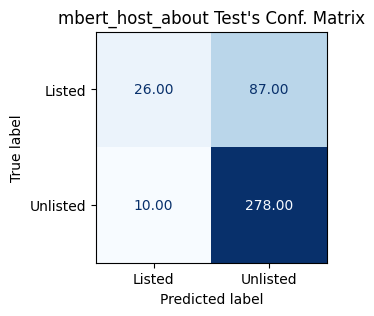


------------------------------------------------------

It took: 7.01 seconds.


In [56]:
lr_param_grid = {
    'C': [0.01, 0.1, 1],  # Regularization strength
    'penalty': ['l1', 'l2', None],  # Regularization norm
    'class_weight': [None, 'balanced']
}

lr_grid_kwargs = {
    'cv': StratifiedKFold(n_splits=5),
    'scoring': 'f1',
    'return_train_score': False,
    'verbose': 1
}

start = time.perf_counter()
lr = LogisticRegression(random_state=SEED)
lr_preds_dict, lr_fitted_dict = train_sklearn_classifier(lr, embeddings_dict, grid_search=False, param_grid=lr_param_grid, grid_kwargs=lr_grid_kwargs, predict_proba=True, verbose=1)
print()
show_classification_report(lr_preds_dict, th=.5)
print(f"It took: {time.perf_counter() - start:0.2f} seconds.")

In [57]:
# showing example of using class weights
# using glove, 50d, all properties

lr = LogisticRegression(class_weight='balanced', random_state=SEED)
lr.fit(embeddings_dict['glove_50d']['X_train'], embeddings_dict['glove_50d']['y_train'])
train_pred = lr.predict(embeddings_dict['glove_50d']['X_train'])
test_pred = lr.predict(embeddings_dict['glove_50d']['X_test'])

print(classification_report(embeddings_dict['glove_50d']['y_train'], train_pred))
print(classification_report(embeddings_dict['glove_50d']['y_test'], test_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3631
           1       0.72      0.84      0.78      1367

    accuracy                           0.87      4998
   macro avg       0.83      0.86      0.84      4998
weighted avg       0.88      0.87      0.87      4998

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       909
           1       0.72      0.84      0.78       341

    accuracy                           0.87      1250
   macro avg       0.83      0.86      0.84      1250
weighted avg       0.88      0.87      0.87      1250



#### **Random Forest**

Fitting tfidf...
It took: 12.97 seconds.

Fitting glove_50d...
It took: 2.90 seconds.

Fitting glove_concat...
It took: 2.93 seconds.

Fitting glove_200d...
It took: 5.50 seconds.

Fitting xlmr_reviews...
It took: 20.63 seconds.

Fitting xlmr_reviews_only...
It took: 19.95 seconds.

Fitting xlmr_concat_no_reviews...
It took: 3.93 seconds.

Fitting xlmr_description_only...
It took: 4.15 seconds.

Fitting xlmr_host_about_only...
It took: 3.03 seconds.

Fitting mbert_reviews...
It took: 22.89 seconds.

Fitting mbert_reviews_only...
It took: 20.71 seconds.

Fitting mbert_concat...
It took: 3.92 seconds.

Fitting mbert_description...
It took: 4.28 seconds.

Fitting mbert_host_about...
It took: 2.81 seconds.


Classification report for tfidf - Training
              precision    recall  f1-score   support

           0     0.9997    0.8746    0.9330      3588
           1     0.7518    0.9993    0.8580      1364

    accuracy                         0.9089      4952
   macro avg     0.8757  

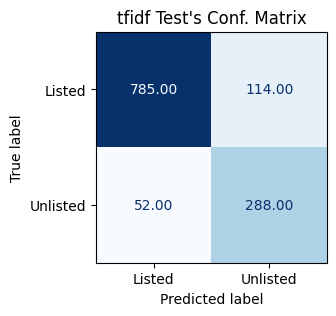


------------------------------------------------------

Classification report for glove_50d - Training
              precision    recall  f1-score   support

           0     1.0000    0.8763    0.9341      3631
           1     0.7528    1.0000    0.8589      1367

    accuracy                         0.9102      4998
   macro avg     0.8764    0.9382    0.8965      4998
weighted avg     0.9324    0.9102    0.9135      4998


Classification report for glove_50d - Test data
              precision    recall  f1-score   support

           0     0.9375    0.8746    0.9050       909
           1     0.7164    0.8446    0.7752       341

    accuracy                         0.8664      1250
   macro avg     0.8270    0.8596    0.8401      1250
weighted avg     0.8772    0.8664    0.8696      1250



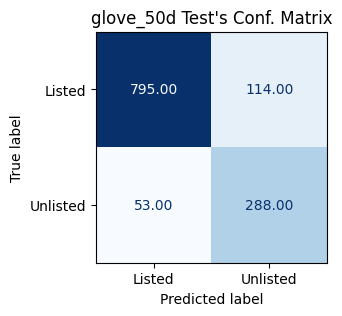


------------------------------------------------------

Classification report for glove_concat - Training
              precision    recall  f1-score   support

           0     1.0000    0.8763    0.9341      3631
           1     0.7528    1.0000    0.8589      1367

    accuracy                         0.9102      4998
   macro avg     0.8764    0.9382    0.8965      4998
weighted avg     0.9324    0.9102    0.9135      4998


Classification report for glove_concat - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



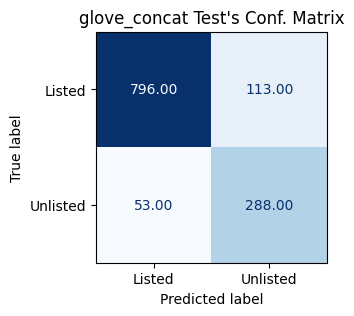


------------------------------------------------------

Classification report for glove_200d - Training
              precision    recall  f1-score   support

           0     1.0000    0.8763    0.9341      3631
           1     0.7528    1.0000    0.8589      1367

    accuracy                         0.9102      4998
   macro avg     0.8764    0.9382    0.8965      4998
weighted avg     0.9324    0.9102    0.9135      4998


Classification report for glove_200d - Test data
              precision    recall  f1-score   support

           0     0.9376    0.8757    0.9056       909
           1     0.7182    0.8446    0.7763       341

    accuracy                         0.8672      1250
   macro avg     0.8279    0.8601    0.8409      1250
weighted avg     0.8777    0.8672    0.8703      1250



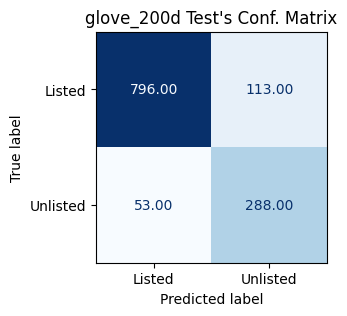


------------------------------------------------------

Classification report for xlmr_reviews - Training
              precision    recall  f1-score   support

           0     1.0000    0.8763    0.9341      3631
           1     0.7528    1.0000    0.8589      1367

    accuracy                         0.9102      4998
   macro avg     0.8764    0.9382    0.8965      4998
weighted avg     0.9324    0.9102    0.9135      4998


Classification report for xlmr_reviews - Test data
              precision    recall  f1-score   support

           0     0.9374    0.8735    0.9043       909
           1     0.7146    0.8446    0.7742       341

    accuracy                         0.8656      1250
   macro avg     0.8260    0.8590    0.8393      1250
weighted avg     0.8767    0.8656    0.8688      1250



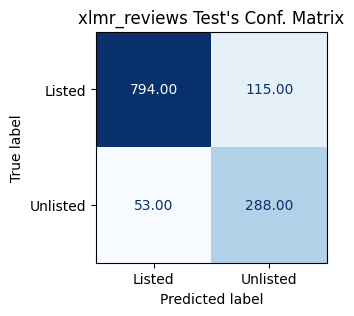


------------------------------------------------------

Classification report for xlmr_reviews_only - Training
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3182
           1     1.0000    1.0000    1.0000       214

    accuracy                         1.0000      3396
   macro avg     1.0000    1.0000    1.0000      3396
weighted avg     1.0000    1.0000    1.0000      3396


Classification report for xlmr_reviews_only - Test data
              precision    recall  f1-score   support

           0     0.9385    0.9975    0.9671       796
           1     0.3333    0.0189    0.0357        53

    accuracy                         0.9364       849
   macro avg     0.6359    0.5082    0.5014       849
weighted avg     0.9008    0.9364    0.9090       849



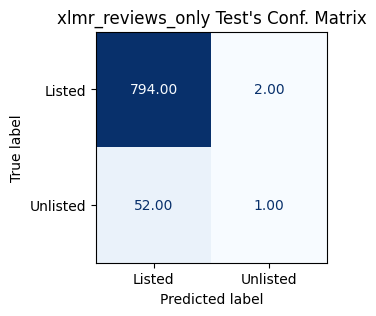


------------------------------------------------------

Classification report for xlmr_concat_no_reviews - Training
              precision    recall  f1-score   support

           0     0.9978    1.0000    0.9989       449
           1     1.0000    0.9991    0.9996      1153

    accuracy                         0.9994      1602
   macro avg     0.9989    0.9996    0.9992      1602
weighted avg     0.9994    0.9994    0.9994      1602


Classification report for xlmr_concat_no_reviews - Test data
              precision    recall  f1-score   support

           0     0.9600    0.2124    0.3478       113
           1     0.7633    0.9965    0.8645       288

    accuracy                         0.7756       401
   macro avg     0.8616    0.6045    0.6061       401
weighted avg     0.8187    0.7756    0.7189       401



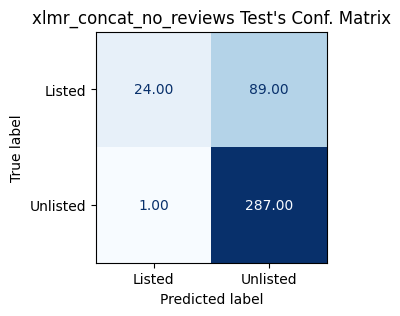


------------------------------------------------------

Classification report for xlmr_description_only - Training
              precision    recall  f1-score   support

           0     0.9890    0.9978    0.9933       449
           1     0.9991    0.9957    0.9974      1153

    accuracy                         0.9963      1602
   macro avg     0.9940    0.9967    0.9954      1602
weighted avg     0.9963    0.9963    0.9963      1602


Classification report for xlmr_description_only - Test data
              precision    recall  f1-score   support

           0     0.8095    0.1504    0.2537       113
           1     0.7474    0.9861    0.8503       288

    accuracy                         0.7506       401
   macro avg     0.7784    0.5683    0.5520       401
weighted avg     0.7649    0.7506    0.6822       401



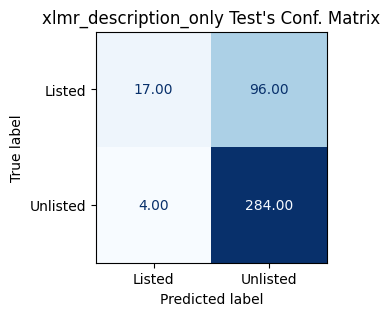


------------------------------------------------------

Classification report for xlmr_host_about_only - Training
              precision    recall  f1-score   support

           0     0.9415    0.8597    0.8987       449
           1     0.9471    0.9792    0.9629      1153

    accuracy                         0.9457      1602
   macro avg     0.9443    0.9194    0.9308      1602
weighted avg     0.9456    0.9457    0.9449      1602


Classification report for xlmr_host_about_only - Test data
              precision    recall  f1-score   support

           0     0.7015    0.4159    0.5222       113
           1     0.8024    0.9306    0.8617       288

    accuracy                         0.7855       401
   macro avg     0.7519    0.6732    0.6920       401
weighted avg     0.7740    0.7855    0.7661       401



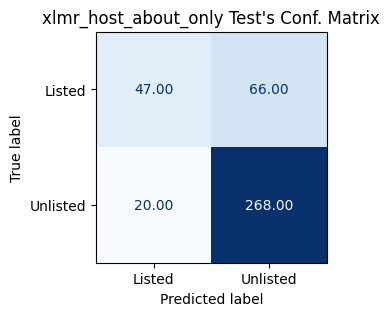


------------------------------------------------------

Classification report for mbert_reviews - Training
              precision    recall  f1-score   support

           0     1.0000    0.8763    0.9341      3631
           1     0.7528    1.0000    0.8589      1367

    accuracy                         0.9102      4998
   macro avg     0.8764    0.9382    0.8965      4998
weighted avg     0.9324    0.9102    0.9135      4998


Classification report for mbert_reviews - Test data
              precision    recall  f1-score   support

           0     0.9375    0.8746    0.9050       909
           1     0.7164    0.8446    0.7752       341

    accuracy                         0.8664      1250
   macro avg     0.8270    0.8596    0.8401      1250
weighted avg     0.8772    0.8664    0.8696      1250



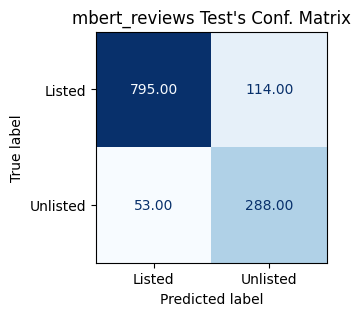


------------------------------------------------------

Classification report for mbert_reviews_only - Training
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3182
           1     1.0000    1.0000    1.0000       214

    accuracy                         1.0000      3396
   macro avg     1.0000    1.0000    1.0000      3396
weighted avg     1.0000    1.0000    1.0000      3396


Classification report for mbert_reviews_only - Test data
              precision    recall  f1-score   support

           0     0.9375    0.9987    0.9672       796
           1     0.0000    0.0000    0.0000        53

    accuracy                         0.9364       849
   macro avg     0.4688    0.4994    0.4836       849
weighted avg     0.8790    0.9364    0.9068       849



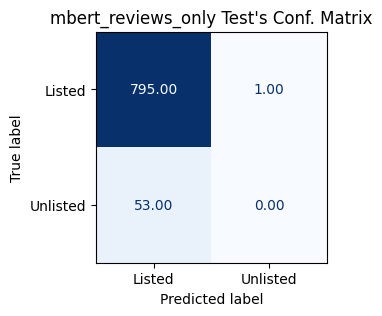


------------------------------------------------------

Classification report for mbert_concat - Training
              precision    recall  f1-score   support

           0     0.9978    1.0000    0.9989       449
           1     1.0000    0.9991    0.9996      1153

    accuracy                         0.9994      1602
   macro avg     0.9989    0.9996    0.9992      1602
weighted avg     0.9994    0.9994    0.9994      1602


Classification report for mbert_concat - Test data
              precision    recall  f1-score   support

           0     0.8718    0.3009    0.4474       113
           1     0.7818    0.9826    0.8708       288

    accuracy                         0.7905       401
   macro avg     0.8268    0.6418    0.6591       401
weighted avg     0.8071    0.7905    0.7515       401



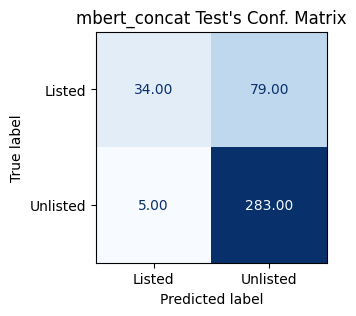


------------------------------------------------------

Classification report for mbert_description - Training
              precision    recall  f1-score   support

           0     0.9890    0.9978    0.9933       449
           1     0.9991    0.9957    0.9974      1153

    accuracy                         0.9963      1602
   macro avg     0.9940    0.9967    0.9954      1602
weighted avg     0.9963    0.9963    0.9963      1602


Classification report for mbert_description - Test data
              precision    recall  f1-score   support

           0     0.7826    0.1593    0.2647       113
           1     0.7487    0.9826    0.8498       288

    accuracy                         0.7506       401
   macro avg     0.7656    0.5710    0.5573       401
weighted avg     0.7582    0.7506    0.6850       401



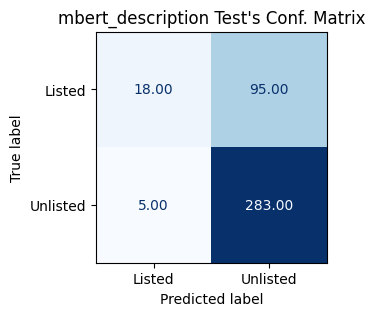


------------------------------------------------------

Classification report for mbert_host_about - Training
              precision    recall  f1-score   support

           0     0.9436    0.8575    0.8985       449
           1     0.9464    0.9801    0.9629      1153

    accuracy                         0.9457      1602
   macro avg     0.9450    0.9188    0.9307      1602
weighted avg     0.9456    0.9457    0.9449      1602


Classification report for mbert_host_about - Test data
              precision    recall  f1-score   support

           0     0.6984    0.3894    0.5000       113
           1     0.7959    0.9340    0.8594       288

    accuracy                         0.7805       401
   macro avg     0.7471    0.6617    0.6797       401
weighted avg     0.7684    0.7805    0.7581       401



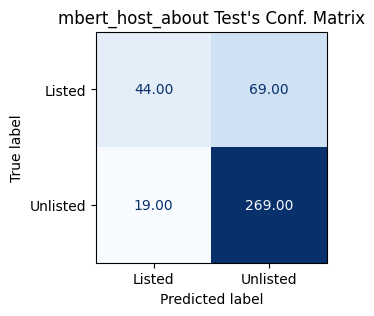


------------------------------------------------------

It took: 132.07 seconds.


In [59]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'class_weight': [None, 'balanced']
}

rf_grid_kwargs = {
    'cv': StratifiedKFold(n_splits=5),
    'scoring': 'f1',
    'return_train_score': False,
    'verbose': 1
}

start = time.perf_counter()
rf = RandomForestClassifier(random_state=SEED)
rf_preds_dict, rf_fitted_dict = train_sklearn_classifier(rf, embeddings_dict, grid_search=False, param_grid=rf_param_grid, grid_kwargs=rf_grid_kwargs, verbose=1)
print()
show_classification_report(rf_preds_dict, th=.5)
print(f"It took: {time.perf_counter() - start:0.2f} seconds.")

In [58]:
# showing example of using class weights
# using glove, 50d, all properties

rf = RandomForestClassifier(class_weight='balanced', random_state=SEED)
rf.fit(embeddings_dict['glove_50d']['X_train'], embeddings_dict['glove_50d']['y_train'])
train_pred = rf.predict(embeddings_dict['glove_50d']['X_train'])
test_pred = rf.predict(embeddings_dict['glove_50d']['X_test'])

print(classification_report(embeddings_dict['glove_50d']['y_train'], train_pred))
print(classification_report(embeddings_dict['glove_50d']['y_test'], test_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      3631
           1       0.75      1.00      0.86      1367

    accuracy                           0.91      4998
   macro avg       0.88      0.94      0.90      4998
weighted avg       0.93      0.91      0.91      4998

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       909
           1       0.72      0.84      0.78       341

    accuracy                           0.87      1250
   macro avg       0.83      0.86      0.84      1250
weighted avg       0.88      0.87      0.87      1250



#### **Comparing Predictions**

In [60]:
# our hypothesis is that the models all achieve very similar performances
# when the data contains all houses with and without reviews because they all
# learn that if a house has comments other than their representation for "unknown"
# they it is more likely to be listed and unlisted if not. Therefore they all end
# up getting stuck in this local minima.

# e.g. comparing KNN and LR and RF Predictions for the glove_50d (both achieve a similar
# f1 score of in the test set)

# assert all(knn_preds_dict['glove_50d']['test_indices'] == lr_preds_dict['glove_50d']['test_indices'])
# assert set(test_info.keys()) == set(knn_preds_dict['glove_50d']['test_indices'])
# assert set(knn_preds_dict['glove_50d']['test_indices']) == set(test_df['property_index'])
# assert knn_preds_dict['glove_50d']['test_indices'].tolist() == test_df['property_index'].tolist()
# ... all good

data_kwargs = {
    'columns': 'trans_clean_comments',
    'group': True,
    'drop_property_index': False,
    'concat_features': True,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None,
}

train_df, test_df = load_preprocessed_data(**data_kwargs)
test_info = load_pkl_list(XY_TEST_INFO_PATH)

# since we know the predictions are in the same order as the properties
# in the train and test dfs we can just add new columns like this:
test_df['knn_pred'] = np.argmax(knn_preds_dict['glove_50d']['test_pred'], axis=-1)
test_df['lr_pred'] = np.argmax(lr_preds_dict['glove_50d']['test_pred'], axis=-1)
test_df['rf_pred'] = np.argmax(rf_preds_dict['glove_50d']['test_pred'], axis=-1)

print('HOUSES WITHOUT REVIEWS:')
print('\nTrue Labels:')
print(test_df.loc[test_df[data_kwargs['columns']] == 'unknown', 'unlisted'].value_counts(1))
print('\nKNN Predictions:')
print(test_df.loc[test_df[data_kwargs['columns']] == 'unknown', 'knn_pred'].value_counts(1))
print('\nLR Predictions:')
print(test_df.loc[test_df[data_kwargs['columns']] == 'unknown', 'lr_pred'].value_counts(1))
print('\nRF Predictions:')
print(test_df.loc[test_df[data_kwargs['columns']] == 'unknown', 'rf_pred'].value_counts(1))

# ... we basically get the confirmation that these models, when seeing an embedding
# resembling the 'unknown' token always predict that that house will be unlisted
# just like we hypothesized it!

print('\n-----------------------------\n')
print('HOUSES WITH REVIEWS:')
print('\nTrue Labels:')
print(test_df.loc[test_df[data_kwargs['columns']] != 'unknown', 'unlisted'].value_counts(1))
print('\nKNN Predictions:')
print(test_df.loc[test_df[data_kwargs['columns']] != 'unknown', 'knn_pred'].value_counts(1))
print('\nLR Predictions:')
print(test_df.loc[test_df[data_kwargs['columns']] != 'unknown', 'lr_pred'].value_counts(1))
print('\nRF Predictions:')
print(test_df.loc[test_df[data_kwargs['columns']] != 'unknown', 'rf_pred'].value_counts(1))

# ... and on the other hand we also see that when the house has at least one comment
# then they will virtually always predict that that house will remain listed also
# just like we hypothesized it!

HOUSES WITHOUT REVIEWS:

True Labels:
unlisted
1    0.718204
0    0.281796
Name: proportion, dtype: float64

KNN Predictions:
knn_pred
1    1.0
Name: proportion, dtype: float64

LR Predictions:
lr_pred
1    1.0
Name: proportion, dtype: float64

RF Predictions:
rf_pred
1    1.0
Name: proportion, dtype: float64

-----------------------------

HOUSES WITH REVIEWS:

True Labels:
unlisted
0    0.937574
1    0.062426
Name: proportion, dtype: float64

KNN Predictions:
knn_pred
0    0.998822
1    0.001178
Name: proportion, dtype: float64

LR Predictions:
lr_pred
0    1.0
Name: proportion, dtype: float64

RF Predictions:
rf_pred
0    0.998822
1    0.001178
Name: proportion, dtype: float64


#### **Ungrouped Texts**

In [61]:
# loading data
data_kwargs = {
    'columns': 'lemma_no_stopwords_ner_trans_clean_comments',
    'group': False, # !!!
    'concat_features': True,
    'drop_property_index': False, # !!!
    'lang': 'all',
    'lang_col': None
}

train_df, test_df = load_preprocessed_data(handle_reviews='keep-all', **data_kwargs)

X_train = train_df[data_kwargs['columns']]
y_train = train_df['unlisted']

X_test = test_df[data_kwargs['columns']]
y_test = test_df['unlisted']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (289732,)
X_test shape: (73375,)


In [62]:
# embedding no reviews
# using glove 50d because it had a similar performance to the others
glove = ExtractGloVe('6B', 50, GLOVE_CACHE_DIR)
X_train = glove.get_sentence_embeddings(X_train)
X_test = glove.get_sentence_embeddings(X_test)

print(f"New X_train shape: {X_train.shape}")
print(f"New X_test shape: {X_test.shape}")

Extracting GloVe Embeddings (50): 100%|██████████| 73375/73375 [00:13<00:00, 5480.96it/s]

New X_train shape: (289732, 50)
New X_test shape: (73375, 50)


In [65]:
# fitting model
#  really need to add class weights because if the the dataset is not grouped by property
# the imbalance skyrockets (like 99%+ to <1%)
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

print('INTERMEDIATE MODELS:\n')
print(classification_report(y_train, train_preds))
print()
print(classification_report(y_test, test_preds))

INTERMEDIATE MODELS:

              precision    recall  f1-score   support

           0       0.96      0.68      0.79    275590
           1       0.07      0.45      0.12     14142

    accuracy                           0.67    289732
   macro avg       0.51      0.56      0.46    289732
weighted avg       0.92      0.67      0.76    289732


              precision    recall  f1-score   support

           0       0.97      0.68      0.80     70699
           1       0.05      0.42      0.08      2676

    accuracy                           0.67     73375
   macro avg       0.51      0.55      0.44     73375
weighted avg       0.94      0.67      0.77     73375



In [66]:
# grouping reviews by property

train_df['preds'] = train_preds
test_df['preds'] = test_preds

def group_predictions(df):
    return (df.groupby('property_index')
            .agg({'preds': lambda x: x.value_counts().index[0],  # mode
                  'unlisted': lambda x: list(x)[0]}))

grouped_train_df = group_predictions(train_df)
grouped_test_df = group_predictions(test_df)

ungrouped_preds_dict = {
    'ungrouped': {
       'train_true': deepcopy(grouped_train_df['unlisted'].to_numpy()),
        'test_true': deepcopy(grouped_test_df['unlisted'].to_numpy()),
        'train_pred': deepcopy(grouped_train_df['preds'].to_numpy()),
        'test_pred': deepcopy(grouped_test_df['preds'].to_numpy()),
        'train_indices': deepcopy(grouped_train_df.index.to_numpy()),
        'test_indices': deepcopy(grouped_test_df.index.to_numpy())
    }
}

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      3631
           1       0.62      0.87      0.72      1367

    accuracy                           0.82      4998
   macro avg       0.78      0.83      0.79      4998
weighted avg       0.85      0.82      0.82      4998

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       909
           1       0.60      0.87      0.71       341

    accuracy                           0.81      1250
   macro avg       0.77      0.83      0.78      1250
weighted avg       0.85      0.81      0.82      1250



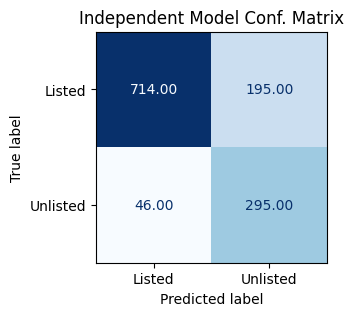

In [67]:
# classification report and Confusion Matrix
print(classification_report(grouped_train_df['unlisted'], grouped_train_df['preds']))
print(classification_report(grouped_test_df['unlisted'], grouped_test_df['preds']))
plot_confusion_matrix(grouped_test_df['unlisted'], grouped_test_df['preds'], title=f"Independent Model Conf. Matrix")

# not that bad but also not as good...

#### **Additional #1: XLM-RoBERTa Fine-Tuning**

In [68]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    # print(preds, labels)

    acc = accuracy_score(labels, preds)
    recall = recall_score(labels, preds)
    precision = precision_score(labels, preds)
    f1 = f1_score(labels, preds)

    metrics = {
        'accuracy': acc,
        'f1': f1,
        'recall': recall,
        'precision': precision}

    return metrics


def fine_tune_transformer(model_ckpt, dataset, output_dir=OUTPUT_DIR, max_len=256, batch_size=16, epochs=3, lr=1e-6, num_labels=2):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    def tokenize(batch):
        return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=max_len)

    dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

    os.makedirs(output_dir, exist_ok=True)
    training_args = TrainingArguments(output_dir=output_dir,
                                      num_train_epochs=epochs,
                                      learning_rate=lr,
                                      per_device_train_batch_size=batch_size,
                                      per_device_eval_batch_size=batch_size,
                                      weight_decay=0.01,
                                      evaluation_strategy="epoch",
                                      disable_tqdm=False,
                                      push_to_hub=False,
                                      log_level="error",
                                      seed=SEED)

    trainer = Trainer(model=model, args=training_args,
                      compute_metrics=compute_metrics,
                      train_dataset=dataset_encoded['train'],
                      eval_dataset=dataset_encoded['test'],
                      tokenizer=tokenizer)

    return trainer, dataset_encoded

def fine_tune_on_datasets(model_ckpt,
                          dataset_list,
                          max_len=256,
                          batch_size=16,
                          epochs=3,
                          lr=1e-5,
                          predict_proba=True,
                          names=[]):

    if not isinstance(dataset_list, list):
        dataset_list = [dataset_list]

    if not names:
        names = [f'model_{i}' for i in range(len(dataset_list))]

    preds_dict = {}
    fitted_clf_dict = {}
    for i, data_kwargs in enumerate(dataset_list):
        joint_dataset = create_feature_extraction_datasets(data_kwargs, return_joint=True)
        trainer, dataset_encoded = fine_tune_transformer(model_ckpt=model_ckpt,
                                                         dataset=joint_dataset,
                                                         max_len=max_len,
                                                         batch_size=batch_size,
                                                         epochs=epochs,
                                                         lr=lr)

        torch.cuda.empty_cache()
        gc.collect()
        trainer.train()

        train_pred = softmax(trainer.predict(dataset_encoded['train']).predictions, axis=-1)
        test_pred = softmax(trainer.predict(dataset_encoded['test']).predictions, axis=-1)

        if predict_proba is False:
            train_pred = np.argmax(train_pred, axis=-1)
            test_pred = np.argmax(test_pred, axis=-1)

        # as arrays
        preds_dict[names[i]] = {'train_true': deepcopy(np.array(dataset_encoded['train']['label'])),
                                'test_true': deepcopy(np.array(dataset_encoded['test']['label'])),
                                'train_pred': deepcopy(train_pred),
                                'test_pred': deepcopy(test_pred)}

        fitted_clf_dict[names[i]] = deepcopy(trainer)

    return preds_dict, fitted_clf_dict

In [69]:
# best way to clear GPU cache without restarsting kernel:
# 1. generate error, e.g. 1/0
# 2. del <var>
# 3. torch.cuda.empty_cache()
# 4. gc.collect()

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


def pt_compute_metrics(preds, labels):
    preds = np.array(preds); labels = np.array(labels)
    preds = np.argmax(preds, axis=-1)
    f1 = f1_score(labels, preds)
    return f1


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    all_preds = []
    all_labels = []
    train_loss = 0
    for batch in dataloader:
        ids, mask, y = batch['input_ids'], batch['attention_mask'], batch['labels']
        ids, mask, y = ids.to(DEVICE), mask.to(DEVICE), y.to(DEVICE)

        # Compute prediction error
        pred = model(input_ids=ids, attention_mask=mask)[0]
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        all_preds.extend(torch.softmax(pred, dim=1).detach().cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    train_loss /= len(dataloader)
    f1 = pt_compute_metrics(all_preds, all_labels)

    return train_loss, f1


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            ids, mask, y = batch['input_ids'], batch['attention_mask'], batch['labels']
            ids, mask, y = ids.to(DEVICE), mask.to(DEVICE), y.to(DEVICE)

            # Compute prediction error
            pred = model(input_ids=ids, attention_mask=mask)[0]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            all_preds.extend(torch.softmax(pred, dim=1).detach().cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size

    f1 = pt_compute_metrics(all_preds, all_labels)

    return test_loss, f1


def log_metrics(epoch, train_metrics, test_metrics, time=None):
    print(f"Epoch {epoch}:")
    print(f"Training Metrics - Loss: {train_metrics[0]:.4f}, F1: {train_metrics[1]:.4f}")
    print(f"Test Metrics - Loss: {test_metrics[0]:.4f}, F1: {test_metrics[1]:.4f}")

    if time is not None:
        print(f"It took {time:.2f} seconds. \n")


def get_predictions(dataloader, model, device):
    all_preds = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            ids, mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            outputs = model(input_ids=ids, attention_mask=mask)
            preds = torch.softmax(outputs.logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
    return np.array(all_preds)


def pt_fine_tune_on_datasets(model_ckpt,
                             dataset_list,
                             max_len=256,
                             batch_size=16,
                             epochs=3,
                             lr=1e-5,
                             predict_proba=True,
                             compute_class_weights=False,
                             names=[]):

    if not isinstance(dataset_list, list):
        dataset_list = [dataset_list]

    if not names:
        names = [f'model_{i}' for i in range(len(dataset_list))]

    preds_dict = {}
    fitted_clf_dict = {}
    histories = {}

    for i, data_kwargs in enumerate(dataset_list):

        print(f"Fitting {names[i].title()}...")

        # Get data
        X_train, X_test, y_train, y_test, train_indices, test_indices = extract_split_datasets(**data_kwargs)

        # Get model and tokenizer
        model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)
        tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

        # Create datasets
        train_dataset = TextDataset(X_train, y_train, tokenizer, max_len)
        test_dataset = TextDataset(X_test, y_test, tokenizer, max_len)

        # Create dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

        # Use GPU if available
        model = model.to(DEVICE)

        # Compute class weights
        if compute_class_weights:
            class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
            class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
            loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            loss_fn = nn.CrossEntropyLoss()

        # train model

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, test_losses = [], []
        train_f1, test_f1 = [], []

        for t in range(epochs):
            start = time.perf_counter()
            train_metrics = train(train_dataloader, model, loss_fn, optimizer)
            test_metrics = test(test_dataloader, model, loss_fn)

            print('---------------------------------------')
            log_metrics(t, train_metrics, test_metrics, time.perf_counter() - start)

            train_losses.append(train_metrics[0]); test_losses.append(test_metrics[0])
            train_f1.append(train_metrics[1]); test_f1.append(test_metrics[1])

        history = {
            'train_loss': train_losses,
            'test_loss': test_losses,
            'train_f1': train_f1,
            'test_f1': test_f1,
        }

        train_pred = get_predictions(train_dataloader, model, DEVICE)
        test_pred = get_predictions(test_dataloader, model, DEVICE)

        if predict_proba is False:
            train_pred = np.argmax(train_pred, axis=-1)
            test_pred = np.argmax(test_pred, axis=-1)

        # as arrays
        preds_dict[names[i]] = {'train_true': deepcopy(y_train),
                                'test_true': deepcopy(y_test),
                                'train_pred': deepcopy(train_pred),
                                'test_pred': deepcopy(test_pred),
                                'train_indices': deepcopy(train_indices),
                                'test_indices': deepcopy(test_indices)}

        fitted_clf_dict[names[i]] = deepcopy(model)

        histories[names[i]] = history

        print()

        # resetting stuff
        del model, optimizer, loss_fn
        gc.collect()
        torch.cuda.empty_cache()

    return preds_dict, fitted_clf_dict, histories

In [116]:
def plot_metrics(histories, figsize=(15, 5)):

    for name, history in histories.items():

        epochs_range = range(1, len(history['train_loss']) + 1)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        ax1.plot(epochs_range, history['train_loss'], label='Training Loss', color=(188/255, 208/255, 49/255))
        ax1.plot(epochs_range, history['test_loss'], label='Test Loss', color=(92/255, 103/255, 109/255))
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss')
        ax1.legend()

        ax2.plot(epochs_range, history['train_f1'], label='Training F1 Score', color=(188/255, 208/255, 49/255))
        ax2.plot(epochs_range, history['test_f1'], label='Test F1 Score', color=(92/255, 103/255, 109/255))
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('F1 Score')
        ax2.set_title('F1 Score')
        ax2.legend()

        plt.suptitle(f'{name.title()} History')
        plt.tight_layout()
        plt.show()

        print()

In [71]:
# only one, because of UMAPS (there are some datasets that are not even worth trying, e.g. reviews only) + GPU constraints

fine_tuned_datasets = [
    {
        'columns': 'ner_trans_clean_description',
        'group': True,
        'concat_features': True,
        'handle_reviews': 'keep-no-reviews',
        'lang': 'all',
        'lang_col': None,
    }
]

In [104]:
xlmr_preds_dict, xlmr_fitted_dict, xlmr_histories = pt_fine_tune_on_datasets(
    model_ckpt='xlm-roberta-base',
    dataset_list=fine_tuned_datasets,
    predict_proba=True,
    epochs=15,
    batch_size=16,
    lr=1e-5,
    compute_class_weights=False,
    names=['xlmr_no_reviews_description_only']
)

# tested values:
# lr: 1e-3, 1e-4, 1e-5, 1e-6
# batch size: 8, 16, 32 (64 + gets us cuda out of memory errors)
# the models might converge quicker of slower but end up with
# similar results, can't learn and inevitably overfit

Fitting Xlmr_No_Reviews_Description_Only...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------------------------------------
Epoch 0:
Training Metrics - Loss: 0.6181, F1: 0.8264
Test Metrics - Loss: 0.5950, F1: 0.8360
It took 92.64 seconds. 

---------------------------------------
Epoch 1:
Training Metrics - Loss: 0.6029, F1: 0.8370
Test Metrics - Loss: 0.5884, F1: 0.8360
It took 92.20 seconds. 

---------------------------------------
Epoch 2:
Training Metrics - Loss: 0.5978, F1: 0.8370
Test Metrics - Loss: 0.5829, F1: 0.8360
It took 92.09 seconds. 

---------------------------------------
Epoch 3:
Training Metrics - Loss: 0.5841, F1: 0.8370
Test Metrics - Loss: 0.6397, F1: 0.8360
It took 92.10 seconds. 

---------------------------------------
Epoch 4:
Training Metrics - Loss: 0.5826, F1: 0.8369
Test Metrics - Loss: 0.5791, F1: 0.8360
It took 92.08 seconds. 

---------------------------------------
Epoch 5:
Training Metrics - Loss: 0.5508, F1: 0.8382
Test Metrics - Loss: 0.5635, F1: 0.8471
It took 92.05 seconds. 

---------------------------------------
Epoch 6:
Tra

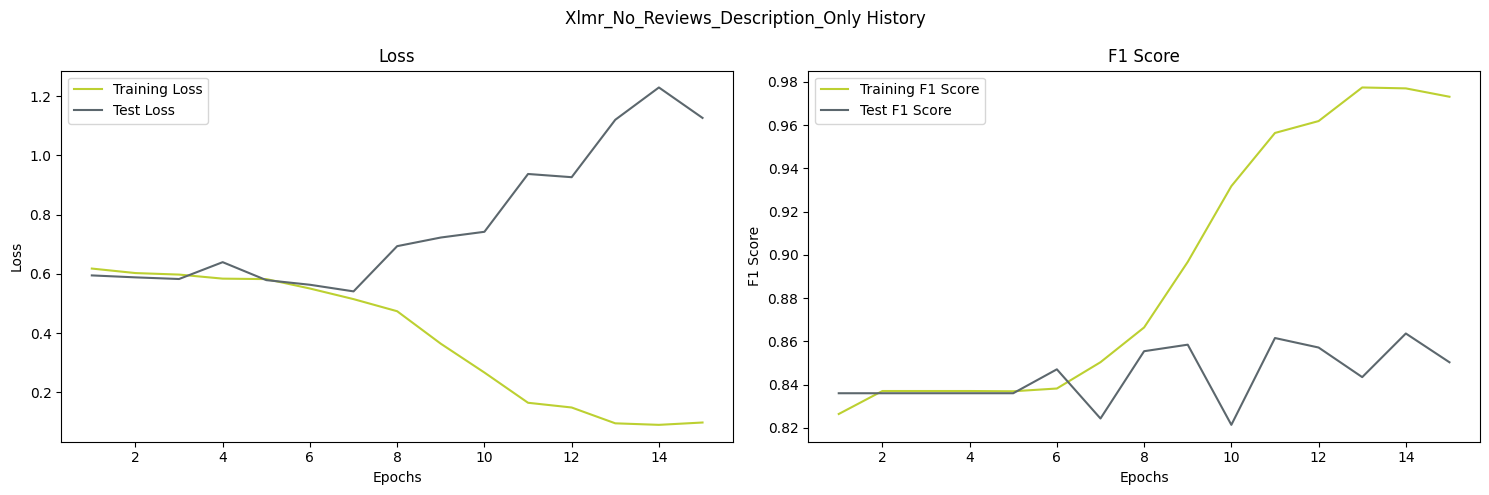

In [117]:
plot_metrics(xlmr_histories)

# ... overfit, model never even learns a bit

In [110]:
# with class weighting

xlmr_preds_dict_cw, xlmr_fitted_dict_cw, xlmr_histories_cw = pt_fine_tune_on_datasets(
    model_ckpt='xlm-roberta-base',
    dataset_list=fine_tuned_datasets,
    predict_proba=True,
    epochs=15,
    batch_size=16,
    lr=1e-5,
    compute_class_weights=True,
    names=['xlmr_no_reviews_description_only_cw']
)

Fitting Xlmr_No_Reviews_Description_Only_Cw...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------------------------------------
Epoch 0:
Training Metrics - Loss: 0.6988, F1: 0.7412
Test Metrics - Loss: 0.6910, F1: 0.8360
It took 82.73 seconds. 

---------------------------------------
Epoch 1:
Training Metrics - Loss: 0.6956, F1: 0.7322
Test Metrics - Loss: 0.6895, F1: 0.7653
It took 82.36 seconds. 

---------------------------------------
Epoch 2:
Training Metrics - Loss: 0.6868, F1: 0.6657
Test Metrics - Loss: 0.6871, F1: 0.8360
It took 82.12 seconds. 

---------------------------------------
Epoch 3:
Training Metrics - Loss: 0.6882, F1: 0.7480
Test Metrics - Loss: 0.6857, F1: 0.8360
It took 82.22 seconds. 

---------------------------------------
Epoch 4:
Training Metrics - Loss: 0.6815, F1: 0.7600
Test Metrics - Loss: 0.6593, F1: 0.8104
It took 82.06 seconds. 

---------------------------------------
Epoch 5:
Training Metrics - Loss: 0.6893, F1: 0.6746
Test Metrics - Loss: 0.6637, F1: 0.7817
It took 82.10 seconds. 

---------------------------------------
Epoch 6:
Tra

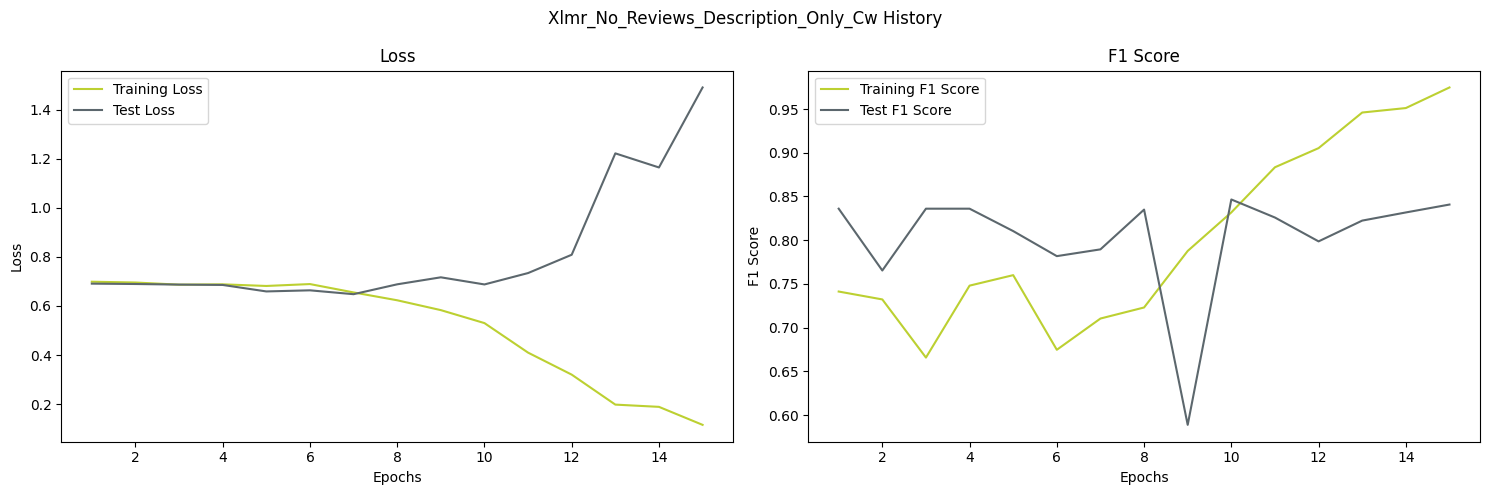

In [118]:
plot_metrics(xlmr_histories_cw)

# ... overfit, model never even learns a bit

In [ ]:
# ... neither model actually learns, goes straight to overfitting even with
# different learning rates and batch sizes

In [119]:
# that being said we can append the cw dict to the xlmr dict

xlmr_preds_dict['xlmr_no_reviews_description_only_cw'] = xlmr_preds_dict_cw['xlmr_no_reviews_description_only_cw']

#### **Additional #2: mBERT Fine-Tuning**

In [113]:
mbert_preds_dict, mbert_fitted_dict, mbert_histories = pt_fine_tune_on_datasets(
    model_ckpt='google-bert/bert-base-multilingual-uncased',
    dataset_list=fine_tuned_datasets,
    predict_proba=True,
    epochs=15,
    batch_size=16,
    lr=1e-5,
    compute_class_weights=False,
    names=['mbert_no_reviews_description_only']
)

Fitting Mbert_No_Reviews_Description_Only...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------------------------------------
Epoch 0:
Training Metrics - Loss: 0.5986, F1: 0.8360
Test Metrics - Loss: 0.5496, F1: 0.8487
It took 77.66 seconds. 

---------------------------------------
Epoch 1:
Training Metrics - Loss: 0.5610, F1: 0.8454
Test Metrics - Loss: 0.5357, F1: 0.8502
It took 77.46 seconds. 

---------------------------------------
Epoch 2:
Training Metrics - Loss: 0.5122, F1: 0.8562
Test Metrics - Loss: 0.5436, F1: 0.8528
It took 77.50 seconds. 

---------------------------------------
Epoch 3:
Training Metrics - Loss: 0.4760, F1: 0.8774
Test Metrics - Loss: 0.5224, F1: 0.8429
It took 77.37 seconds. 

---------------------------------------
Epoch 4:
Training Metrics - Loss: 0.4033, F1: 0.8971
Test Metrics - Loss: 0.5568, F1: 0.8554
It took 77.41 seconds. 

---------------------------------------
Epoch 5:
Training Metrics - Loss: 0.3200, F1: 0.9185
Test Metrics - Loss: 0.6237, F1: 0.8475
It took 77.52 seconds. 

---------------------------------------
Epoch 6:
Tra

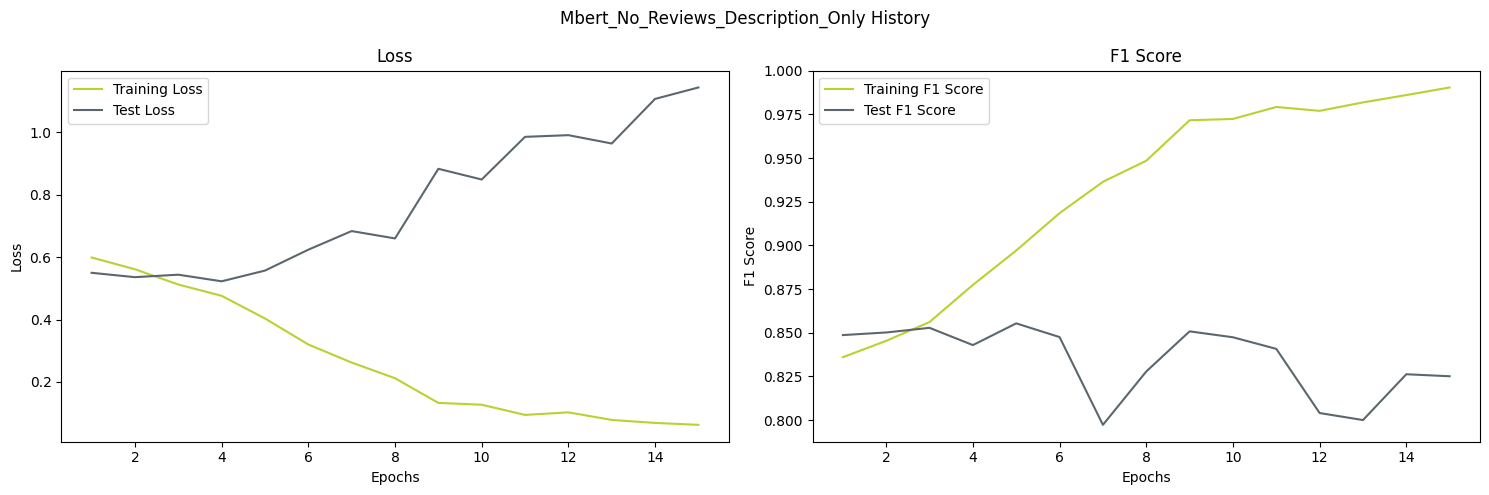

In [120]:
plot_metrics(mbert_histories)

# ... extreme overfit

In [123]:
# with class weighting

mbert_preds_dict_cw, mbert_fitted_dict_cw, mbert_histories_cw = pt_fine_tune_on_datasets(
    model_ckpt='google-bert/bert-base-multilingual-uncased',
    dataset_list=fine_tuned_datasets,
    predict_proba=True,
    epochs=15,
    batch_size=16,
    lr=1e-5,
    compute_class_weights=True,
    names=['mbert_no_reviews_description_only_cw']
)

Fitting Mbert_No_Reviews_Description_Only_Cw...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------------------------------------
Epoch 0:
Training Metrics - Loss: 0.6951, F1: 0.7553
Test Metrics - Loss: 0.6879, F1: 0.7994
It took 77.95 seconds. 

---------------------------------------
Epoch 1:
Training Metrics - Loss: 0.6863, F1: 0.7174
Test Metrics - Loss: 0.6591, F1: 0.7038
It took 77.71 seconds. 

---------------------------------------
Epoch 2:
Training Metrics - Loss: 0.6789, F1: 0.7423
Test Metrics - Loss: 0.6820, F1: 0.6271
It took 77.62 seconds. 

---------------------------------------
Epoch 3:
Training Metrics - Loss: 0.6640, F1: 0.7563
Test Metrics - Loss: 0.6228, F1: 0.7915
It took 77.55 seconds. 

---------------------------------------
Epoch 4:
Training Metrics - Loss: 0.6488, F1: 0.7461
Test Metrics - Loss: 0.6264, F1: 0.8355
It took 77.55 seconds. 

---------------------------------------
Epoch 5:
Training Metrics - Loss: 0.5601, F1: 0.8322
Test Metrics - Loss: 0.6779, F1: 0.6053
It took 77.64 seconds. 

---------------------------------------
Epoch 6:
Tra

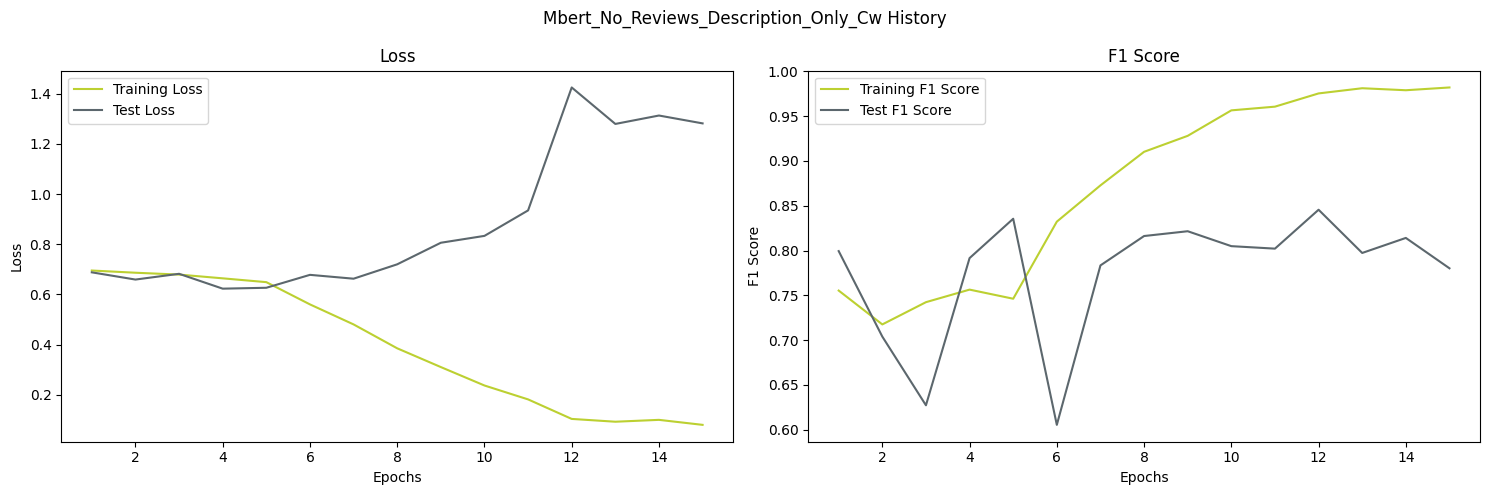

In [124]:
plot_metrics(mbert_histories_cw)

In [ ]:
# ... also, neither model actually learns, goes straight to overfitting even with
# different learning rates and batch sizes

In [125]:
# that being said we can append the cw dict to the mbert dict

mbert_preds_dict['mbert_no_reviews_description_only_cw'] = mbert_preds_dict_cw['mbert_no_reviews_description_only_cw']

#### **Additional #3: Text Summarization + Text Classification**

In [133]:
# the descriptions are all similar (house size, location, what they're near to etc..)
# maybe we can try and summarize them to remove noise and enhance possible signal?

data_kwargs = {
    'columns': 'ner_trans_clean_description',
    'group': True,
    'concat_features': True,
    'drop_property_index': False,
    'handle_reviews': 'keep-no-reviews',
    'lang': 'en',  # !!!
    'lang_col': 'trans_clean_description_lang',
}

train_df, test_df = load_preprocessed_data(**data_kwargs)

In [134]:
def summarize_text(corpus,
                   model_ckpt='sshleifer/distilbart-cnn-12-6',
                   max_len=50,
                   min_len=25,
                   do_sample=False):

    # we want to skip docs with less tokens than max len
    skipped, summarized = [], []
    for i, doc in enumerate(corpus):
        if len(doc.split()) < max_len:
            skipped.append((i, doc))
        else:
            summarized.append((i, doc))

    device = ("cuda" if torch.cuda.is_available() else "cpu")
    summarizer = pipeline("summarization",
                          model=model_ckpt,
                          tokenizer=model_ckpt,
                          device=device)

    summaries = summarizer([doc for idx, doc in summarized],  # we don't want the indices
                           max_length=max_len,
                           min_length=min_len,
                           do_sample=do_sample)

    summaries = [summary['summary_text'] for summary in summaries]

    # joining summarized with skipped
    idx_summaries = list(zip([idx for idx, doc in summarized], summaries))
    idx_summaries.extend(skipped)
    idx_summaries = sorted(idx_summaries, key=lambda x: x[0])

    return [doc for idx, doc in idx_summaries]


start = time.perf_counter()
train_df[f"summ_{data_kwargs['columns']}"] = summarize_text(train_df[data_kwargs['columns']].tolist())
test_df[f"summ_{data_kwargs['columns']}"] = summarize_text(test_df[data_kwargs['columns']].tolist())
print(f"It took {time.perf_counter() - start:.2f} seconds.")

It took 495.95 seconds.


In [135]:
glove = ExtractGloVe('6B', 50, GLOVE_CACHE_DIR)
X_train = glove.get_sentence_embeddings(train_df[f"summ_{data_kwargs['columns']}"])
X_test = glove.get_sentence_embeddings(test_df[f"summ_{data_kwargs['columns']}"])

y_train = train_df['unlisted']
y_test = test_df['unlisted']

Extracting GloVe Embeddings (50): 100%|██████████| 317/317 [00:00<00:00, 3834.41it/s]


              precision    recall  f1-score   support

           0       0.83      0.02      0.03       320
           1       0.74      1.00      0.85       904

    accuracy                           0.74      1224
   macro avg       0.79      0.51      0.44      1224
weighted avg       0.77      0.74      0.64      1224

              precision    recall  f1-score   support

           0       1.00      0.03      0.07        88
           1       0.73      1.00      0.84       229

    accuracy                           0.73       317
   macro avg       0.86      0.52      0.45       317
weighted avg       0.80      0.73      0.63       317



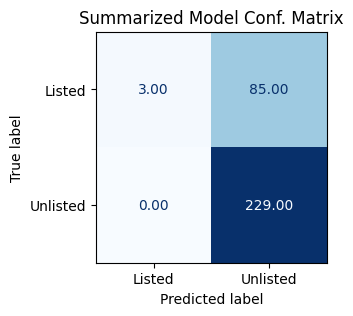

In [136]:
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
plot_confusion_matrix(y_test, test_pred, title=f"Summarized Model Conf. Matrix")

# ... similar results (just a little bit better)

# with class weights:
# precision    recall  f1-score   support

#            0       0.35      0.57      0.44        88
#            1       0.78      0.60      0.68       229

#     accuracy                           0.59       317
#    macro avg       0.57      0.59      0.56       317
# weighted avg       0.66      0.59      0.61       317
# less one sided but would not help final model
# no CW => more Type II
# with C => more Type I

In [137]:
summarized_preds_dict = {
    'summarized': {
        'train_true': deepcopy(np.array(y_train.astype(int))),
        'test_true': deepcopy(np.array(y_test.astype(int))),
        'train_pred': deepcopy(train_pred),
        'test_pred': deepcopy(test_pred),
        'train_indices': deepcopy(np.array(train_df['property_index'])),
        'test_indices': deepcopy(np.array(test_df['property_index']))
    }
}

#### **Extending Rule-Based Model**

- **With Sentiment Analysis**

In [148]:
data_kwargs = {
    'columns': 'ner_trans_clean_comments',
    'group': True,
    'concat_features': True,
    'drop_property_index':False,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None,
}

train_df, test_df = load_preprocessed_data(**data_kwargs)

In [144]:
def sentiment_based_predictions(corpus, en=False):
    # doing this for efficiency, instead of passing
    # through the sentiment analysis pipe one doc at
    # a time we pass an array of docs
    unknowns, knowns = [], []
    for i, doc in enumerate(corpus):
        if doc == 'unknown':
            unknowns.append((i, doc))
        else:
            knowns.append((i, doc))

    sentiment = analyse_sentiment([doc for i, doc in knowns], en=en)
    known_preds = [0 if sent == 1 else 1 for sent in sentiment]
    known_preds = list(zip([i for i, doc in knowns], known_preds))

    unknown_preds = [(i, 1) for i, _ in unknowns]

    preds = known_preds + unknown_preds
    preds = sorted(preds, key= lambda x: x[0])
    preds = [pred for i, pred in preds]

    return preds

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3631
           1       0.68      0.85      0.76      1367

    accuracy                           0.85      4998
   macro avg       0.81      0.85      0.83      4998
weighted avg       0.87      0.85      0.86      4998

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       909
           1       0.67      0.86      0.76       341

    accuracy                           0.85      1250
   macro avg       0.81      0.85      0.82      1250
weighted avg       0.87      0.85      0.85      1250



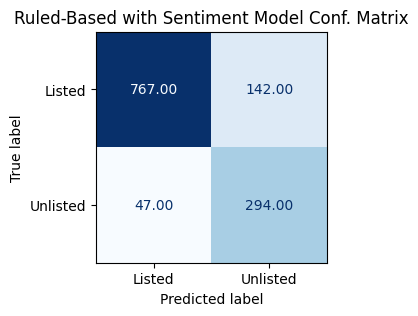

In [149]:
X_train = train_df[data_kwargs['columns']]
X_test = test_df[data_kwargs['columns']]

y_train = train_df['unlisted']
y_test = test_df['unlisted']

train_pred = sentiment_based_predictions(train_df[data_kwargs['columns']])
test_pred = sentiment_based_predictions(test_df[data_kwargs['columns']])

print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))
plot_confusion_matrix(y_test, test_pred, title=f"Ruled-Based with Sentiment Model Conf. Matrix")

# ... it is slightly worse; we are predicting more truly listd homes as unlisted
# ... it seems that the trick is not to increase the efficiency of
# the model when predicting for houses with comments, since if we
# always predict '0' we will be right 93% of the time but rather
# to try and develop a model that is better than random when pre-
# dicting for houses without comments using only the description
# and host about!

In [150]:
sentiment_preds_dict = {
    'sentiment': {
        'train_true': deepcopy(np.array(y_train)),
        'test_true': deepcopy(np.array(y_test)),
        'train_pred': deepcopy(np.array(train_pred)),
        'test_pred': deepcopy(np.array(test_pred)),
        'train_indices': deepcopy(np.array(train_df['property_index'])),
        'test_indices': deepcopy(np.array(test_df['property_index']))
    }
}

- **Feature Extraction**

In [151]:
# importing data

data_kwargs = {
    'columns': ['trans_clean_comments', 'trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments_lang'],
    'group': False,
    'concat_features': False,
    'drop_property_index': False,
    'handle_reviews': 'keep-all',
    'lang': 'all',
    'lang_col': None,
}

train_df, test_df = load_preprocessed_data(**data_kwargs)

display(train_df.head())

trans_clean_description  property_index  \
0  this is a shared mixed room in our hostel with...               1   
1  this is a shared mixed room in our hostel with...               1   
2  this is a shared mixed room in our hostel with...               1   
3  this is a shared mixed room in our hostel with...               1   
4  this is a shared mixed room in our hostel with...               1   

                                trans_clean_comments  unlisted  \
0  this is a very cozy and comfortable house to s...         0   
1                                               good         0   
2  my first hostel experience and all i have to s...         0   
3  das hostel war neu und deshalb funktionierte a...         0   
4  it was fine for a dorm but i think for the peo...         0   

              trans_clean_host_about trans_clean_comments_lang  
0  alojamento local registro 20835al                        en  
1  alojamento local registro 20835al                        en  
2  alojamento local registro 20835al                        en  
3  alojamento local registro 20835al                        de  
4  alojamento local registro 20835al                        en

In [165]:
# extracting features

# features:
# 1. number of comments
# 2. avg comment lenght
# 3. count of reviews in different languages
# 4. description len
# 5. host about len
# 6. number of houses of the same host
# 7. comment sentiment

def extract_features(df, comments_col = 'trans_clean_comments', en=False, host_about_col='trans_clean_host_about', labeled=True, drop_property_index=False):
    # easy aggs
    aggregations = {
        'num_comments': ('trans_clean_comments', lambda x: 0 if (x.iloc[0] == 'unknown' and len(x) == 1) else len(x)),
        'avg_comments_len': ('trans_clean_comments', lambda x: x.apply(lambda review: len(review.split())).mean()),
        'nunique_comments_lang': ('trans_clean_comments_lang', 'nunique'),
        'avg_description_len': ('trans_clean_description', lambda x: x.apply(lambda review: len(review.split())).mean()),
        'avg_host_about_len': ('trans_clean_host_about', lambda x: x.apply(lambda review: len(review.split())).mean()),
        'host_about': (host_about_col, lambda x: list(set(x))[0])
    }

    if labeled:
        aggregations['unlisted'] = ('unlisted', 'mean')  # doesn't really matter if its mean, median, mode, etc, always the same number

    # aggregation
    fe_df = df.groupby('property_index').agg(**aggregations).reset_index()

    # sentiment
    sentiment_df = df[['property_index', comments_col]]
    sentiment_df = groupby_property(sentiment_df)

    # removing unknown
    sentiment_df = sentiment_df.loc[sentiment_df[comments_col] != 'unknown', :]
    sentiments = analyse_sentiment(sentiment_df[comments_col].tolist(), en=en)
    sentiments_dict = dict(zip(sentiment_df['property_index'], sentiments))

    # adding sentiment col
    fe_df['comments_sentiment'] = fe_df['property_index'].map(sentiments_dict)
    fe_df['comments_sentiment'] = fe_df['comments_sentiment'].fillna(-1) # if house has no reviews then place -1

    # houses of the same host
    moguls = df.groupby(host_about_col).agg(property_index_count = ('property_index', 'nunique')).reset_index()
    moguls_dict = dict(zip(moguls[host_about_col], moguls['property_index_count']))
    fe_df['number_of_properties_hosted'] =  fe_df['host_about'].map(moguls_dict)
    fe_df['number_of_properties_hosted'] = fe_df['number_of_properties_hosted'].fillna(0)  # there are houses whose hosts have no comments in any of their properties
    fe_df = fe_df.drop('host_about', axis=1)

    # dropping property_index
    if drop_property_index:
        fe_df = fe_df.drop('property_index', axis=1)

    return fe_df


train_fe = extract_features(train_df, labeled=True, drop_property_index=False)
test_fe = extract_features(test_df, labeled=True, drop_property_index=False)

display(test_fe.head())

property_index  num_comments  avg_comments_len  nunique_comments_lang  \
0               2             0          1.000000                      1   
1               5            41         25.975610                      6   
2               6             0          1.000000                      1   
3              19           113         31.672566                      7   
4              23           248         50.310484                      6   

   avg_description_len  avg_host_about_len  unlisted  comments_sentiment  \
0                 22.0                24.0       1.0                -1.0   
1                 89.0                36.0       0.0                 1.0   
2                 95.0                95.0       0.0                -1.0   
3                110.0                 1.0       0.0                 1.0   
4                125.0                47.0       0.0                 1.0   

   number_of_properties_hosted  
0                            2  
1                            1  
2                           15  
3                           16  
4                            1

In [166]:
# train test splits

X_train = train_fe[[col for col in train_fe if (col != 'unlisted') & (col != 'property_index')]]
X_test = test_fe[[col for col in test_fe if (col != 'unlisted') & (col != 'property_index')]]

y_train = train_fe['unlisted']
y_test = test_fe['unlisted']

print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")

X_train shape: (4998, 7) | X_test shape: (1250, 7)
y_train shape: (4998,) | y_test shape: (1250,)


In [167]:
# fitting and evaluating model
# using a DT for easy access to feature importance
clf = DecisionTreeClassifier(random_state=SEED)

param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [2, 4, 8, 16],
    'class_weight': ['balanced', None]
}

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           scoring='f1', cv=stratified_kf, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
clf = grid_search.best_estimator_

# clf.fit(X_train, y_train)

train_pred = clf.predict_proba(X_train)
test_pred = clf.predict_proba(X_test)

print(classification_report(y_train, np.argmax(train_pred, axis=-1)))
print(classification_report(y_test, np.argmax(test_pred, axis=-1)))

# ... that local minima again

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best params: {'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 2}
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      3631
         1.0       0.73      0.85      0.79      1367

    accuracy                           0.87      4998
   macro avg       0.84      0.86      0.85      4998
weighted avg       0.88      0.87      0.88      4998

              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90       909
         1.0       0.71      0.85      0.77       341

    accuracy                           0.86      1250
   macro avg       0.82      0.86      0.84      1250
weighted avg       0.88      0.86      0.87      1250



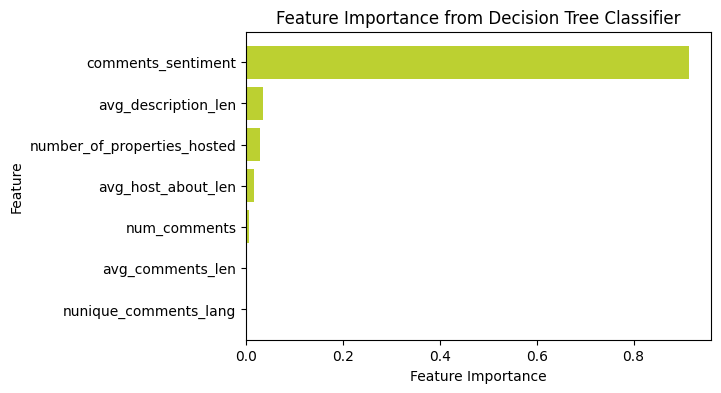

In [168]:
# plotting feature importances

feature_importances = clf.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})

importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(6, 4))
plt.barh(importance_df['feature'], importance_df['importance'], color=(188/255, 208/255, 49/255))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Decision Tree Classifier')
plt.gca().invert_yaxis()
plt.show()

# ... comments_sentiment is definitely the most important but because
# it works similaly to num of comments, if -1 then house has no reviews
# if 0 or 1 then it has

In [169]:
fe_preds_dict = {
    'feature_extraction': {
        'train_true': deepcopy(np.array(y_train.astype(int))),  # because all other y arrays are in int and not floats
        'test_true': deepcopy(np.array(y_test.astype(int))),
        'train_pred': deepcopy(train_pred),
        'test_pred': deepcopy(test_pred),
        'train_indices': deepcopy(train_fe['property_index'].to_numpy()),
        'test_indices': deepcopy(test_fe['property_index'].to_numpy())
    }
}

## **Model Comparison**

#### **Fixing Predictions**

In [240]:
# not all datasets are composed of the same properties, same, for example
# datasets composed only of houses without reviews only pertain to 1602
# properties out of the total 4998 in the train set. To be able to evalua-
# te models accurately we have to make sure they all make predictions on
# the full train and test datasets. How to? by keeping the predictions as
# they are for the houses they've been trained and tested on but for houses
# not in the datasets then fabricate a prediction following the logic in the
# rule based approach. For example a dataset with only houses with no reviews
# (1602) would now make 'predictions' on the remaining houses, since those
# remaining houses are houses with at least one review then, following the logic,
# the predictions would all be '0', i.e. house remains listed.

def fix_predictions(preds_dict,
                    fix_all=False,
                    train_info_path=XY_TRAIN_INFO_PATH,
                    test_info_path=XY_TEST_INFO_PATH):

    train_info = load_pkl_list(train_info_path)
    test_info = load_pkl_list(test_info_path)

    if fix_all:
        all_info = deepcopy(train_info)
        all_info.update(deepcopy(test_info))

    def apply_fix(preds, preds_col, indices_col, info_dict):
        in_proba_format = False
        if preds[preds_col].ndim > 1:
            in_proba_format = True

        new_preds = []
        for idx in info_dict.keys():
            if idx not in preds[indices_col]:
                # if that houses does not exist then follow The logic
                if in_proba_format:
                    new_preds.append([1., 0.] if info_dict[idx]['has_comments'] == 1 else [0., 1.])
                else:
                    new_preds.append(0 if info_dict[idx]['has_comments'] == 1 else 1)
            else:
                # if that house already exists then keep the og prediction
                new_preds.append(preds[preds_col][list(preds[indices_col]).index(idx)])
        return new_preds


    new_preds_dict = {}
    if fix_all:
        for embed, preds in preds_dict.items():
            if len(preds['pred']) == len(all_info):
                # basically just skipping
                new_preds_dict[embed] = preds
            else:
                new_all_true = [i['unlisted'] for i in all_info.values()]
                new_all_indices = list(all_info.keys())

                # here's the tricky part
                new_all_pred = apply_fix(preds, 'pred', 'indices', all_info)

                new_preds_dict[embed] = {
                    'true': np.array(new_all_true),
                    'pred': np.array(new_all_pred),
                    'indices': np.array(new_all_indices)
                }
    else:
        for embed, preds in preds_dict.items():
            if len(preds['train_pred']) == len(train_info):
                # basically just skipping
                new_preds_dict[embed] = preds
            else:
                new_train_true = [i['unlisted'] for i in train_info.values()]
                new_test_true = [i['unlisted'] for i in test_info.values()]

                new_train_indices = list(train_info.keys())
                new_test_indices = list(test_info.keys())

                # here's the tricky part
                new_train_pred = apply_fix(preds, 'train_pred', 'train_indices', train_info)
                new_test_pred = apply_fix(preds, 'test_pred', 'test_indices', test_info)

                new_preds_dict[embed] = {
                    'train_true': np.array(new_train_true),
                    'test_true': np.array(new_test_true),
                    'train_pred': np.array(new_train_pred),
                    'test_pred': np.array(new_test_pred),
                    'train_indices': np.array(new_train_indices),
                    'test_indices': np.array(new_test_indices),
                }

    return new_preds_dict

In [237]:
# grouping all predictions dictionaries

joint_preds_dict = {
    'RuledBased': deepcopy(rule_based_preds_dict),
    'KNN': deepcopy(knn_preds_dict),
    'LR': deepcopy(lr_preds_dict),
    'RF': deepcopy(rf_preds_dict),
    'Ungrouped': deepcopy(ungrouped_preds_dict),
    'XLMR': deepcopy(xlmr_preds_dict),
    'MBERT': deepcopy(mbert_preds_dict),
    'Summarized': deepcopy(summarized_preds_dict),
    'Sentiment': deepcopy(sentiment_preds_dict),
    'FeatureExtraction': deepcopy(fe_preds_dict)
}

In [238]:
print('Before...\n')
for name, pdic in joint_preds_dict.items():
    print(name)
    for embed, preds in pdic.items():
        print(f"\t- {embed} shape:  train_pred: {preds['train_pred'].shape} | test_pred: {preds['test_pred'].shape} | train_indices: {preds['train_indices'].shape} | test_indices: {preds['test_indices'].shape}")

print('\nAfter...\n')
for name, pdic in joint_preds_dict.items():
    print(name)
    fixed_pdic = fix_predictions(pdic)
    joint_preds_dict[name] = fixed_pdic
    for embed, preds in fixed_pdic.items():
        print(f"\t- {embed} shape:  train_pred: {preds['train_pred'].shape} | test_pred: {preds['test_pred'].shape} | train_indices: {preds['train_indices'].shape} | test_indices: {preds['test_indices'].shape}")

# ...

Before...

RuledBased
	- ruled_based shape:  train_pred: (4998,) | test_pred: (1250,) | train_indices: (4998,) | test_indices: (1250,)
KNN
	- tfidf shape:  train_pred: (4952, 2) | test_pred: (1239, 2) | train_indices: (4952,) | test_indices: (1239,)
	- glove_50d shape:  train_pred: (4998, 2) | test_pred: (1250, 2) | train_indices: (4998,) | test_indices: (1250,)
	- glove_concat shape:  train_pred: (4998, 2) | test_pred: (1250, 2) | train_indices: (4998,) | test_indices: (1250,)
	- glove_200d shape:  train_pred: (4998, 2) | test_pred: (1250, 2) | train_indices: (4998,) | test_indices: (1250,)
	- xlmr_reviews shape:  train_pred: (4998, 2) | test_pred: (1250, 2) | train_indices: (4998,) | test_indices: (1250,)
	- xlmr_reviews_only shape:  train_pred: (3396, 2) | test_pred: (849, 2) | train_indices: (3396,) | test_indices: (849,)
	- xlmr_concat_no_reviews shape:  train_pred: (1602, 2) | test_pred: (401, 2) | train_indices: (1602,) | test_indices: (401,)
	- xlmr_description_only shape:  tra

#### **Threshold Tuning**

In [239]:
def tune_th(preds_dict, comparison_th = None):

    th_tuned_scores = pd.DataFrame(index=['Threshold',
                                          'Accuracy',
                                          'F1',
                                          'Recall',
                                          'Precision'])

    for embed, preds in preds_dict.items():

        if preds['train_pred'].ndim > 1:
            best_f1 = 0
            best_res = None
            best_th = None

            y_true = preds['test_true']
            y_pred = preds['test_pred']

            for th in np.arange(.1, .9, 0.05):
                # col [1] has the proba of property being 'unlisted'
                y_pred_1d = (y_pred[:, 1] >= th).astype(int)
                res = classification_report(y_true, y_pred_1d, output_dict=True)

                f1 = res['1']['f1-score']

                if f1 > best_f1:
                    best_f1 = f1
                    best_res = res
                    best_th = th

            th_tuned_scores[embed] = [
                best_th,
                best_res['accuracy'],
                best_res['1']['f1-score'],
                best_res['1']['recall'],
                best_res['1']['precision'],
            ]

        else:
            y_true = preds['test_true']
            y_pred = preds['test_pred']

            res = classification_report(y_true, y_pred, output_dict=True)
            th_tuned_scores[embed] = [
                0.5,
                res['accuracy'],
                res['1']['f1-score'],
                res['1']['recall'],
                res['1']['precision'],
            ]


    if comparison_th is not None:
        # just a simple way to check how changing the th
        # changes the scores
        comp_th_tuned_scores = pd.DataFrame(index=['Threshold',
                                                   'Accuracy',
                                                   'F1',
                                                   'Recall',
                                                   'Precision'])

        for embed, preds in preds_dict.items():
            if preds['train_pred'].ndim > 1:
                y_true = preds['test_true']
                y_pred = preds['test_pred']

                y_pred_1d = (y_pred[:, 1] >= comparison_th).astype(int)
                res = classification_report(y_true, y_pred_1d, output_dict=True)
                comp_th_tuned_scores[embed] = [
                    comparison_th,
                    res['accuracy'],
                    res['1']['f1-score'],
                    res['1']['recall'],
                    res['1']['precision'],
                ]

            else:
                y_true = preds['test_true']
                y_pred = preds['test_pred']

                res = classification_report(y_true, y_pred, output_dict=True)
                comp_th_tuned_scores[embed] = [
                    0.5,
                    res['accuracy'],
                    res['1']['f1-score'],
                    res['1']['recall'],
                    res['1']['precision'],
                ]

        th_tuned_scores['=>'] = ['=>'] * len(th_tuned_scores)
        th_tuned_scores = pd.concat([th_tuned_scores, comp_th_tuned_scores], axis=1)

    return th_tuned_scores


def highlight_max(s):
    if s.name == 'Threshold':  # Check if the current row is the first row
        return [''] * len(s)
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

for name, pdic in joint_preds_dict.items():
    print(name)
    th_tuned = tune_th(pdic, comparison_th=None)
    # th_tuned_styled = th_tuned.style.apply(highlight_max, axis=1)
    # display(th_tuned_styled)
    display(th_tuned)
    print()

RuledBased


ruled_based
Threshold     0.500000
Accuracy      0.867200
F1            0.776280
Recall        0.844575
Precision     0.718204


KNN


tfidf  glove_50d  glove_concat  glove_200d  xlmr_reviews  \
Threshold  0.400000   0.400000      0.400000    0.400000      0.400000   
Accuracy   0.866400   0.866400      0.866400    0.867200      0.866400   
F1         0.775236   0.775236      0.775236    0.776280      0.775236   
Recall     0.844575   0.844575      0.844575    0.844575      0.844575   
Precision  0.716418   0.716418      0.716418    0.718204      0.716418   

           xlmr_reviews_only  xlmr_concat_no_reviews  xlmr_description_only  \
Threshold           0.600000                0.100000               0.200000   
Accuracy            0.867200                0.881600               0.878400   
F1                  0.776280                0.795580               0.790055   
Recall              0.844575                0.844575               0.838710   
Precision           0.718204                0.751958               0.746736   

           xlmr_host_about_only  mbert_reviews  mbert_reviews_only  \
Threshold              0.100000       0.400000            0.600000   
Accuracy               0.884800       0.866400            0.867200   
F1                     0.800000       0.775236            0.776280   
Recall                 0.844575       0.844575            0.844575   
Precision              0.759894       0.716418            0.718204   

           mbert_concat  mbert_description  mbert_host_about  
Threshold      0.200000           0.200000          0.200000  
Accuracy       0.883200           0.874400          0.889600  
F1             0.795518           0.783448          0.803419  
Recall         0.832845           0.832845          0.826979  
Precision      0.761394           0.739583          0.781163


LR


tfidf  glove_50d  glove_concat  glove_200d  xlmr_reviews  \
Threshold  0.700000   0.200000      0.150000    0.150000      0.250000   
Accuracy   0.867200   0.867200      0.867200    0.867200      0.867200   
F1         0.776280   0.776280      0.776280    0.776280      0.776280   
Recall     0.844575   0.844575      0.844575    0.844575      0.844575   
Precision  0.718204   0.718204      0.718204    0.718204      0.718204   

           xlmr_reviews_only  xlmr_concat_no_reviews  xlmr_description_only  \
Threshold           0.200000                0.600000               0.550000   
Accuracy            0.867200                0.868000               0.868000   
F1                  0.776280                0.777328               0.777328   
Recall              0.844575                0.844575               0.844575   
Precision           0.718204                0.720000               0.720000   

           xlmr_host_about_only  mbert_reviews  mbert_reviews_only  \
Threshold              0.550000       0.500000            0.500000   
Accuracy               0.868000       0.867200            0.867200   
F1                     0.777328       0.776280            0.776280   
Recall                 0.844575       0.844575            0.844575   
Precision              0.720000       0.718204            0.718204   

           mbert_concat  mbert_description  mbert_host_about  
Threshold      0.500000           0.400000          0.400000  
Accuracy       0.881600           0.870400          0.883200  
F1             0.792717           0.779891          0.796657  
Recall         0.829912           0.841642          0.838710  
Precision      0.758713           0.726582          0.758621


RF


tfidf  glove_50d  glove_concat  glove_200d  xlmr_reviews  \
Threshold  0.650000   0.550000      0.500000    0.500000      0.550000   
Accuracy   0.867200   0.867200      0.867200    0.867200      0.867200   
F1         0.776280   0.776280      0.776280    0.776280      0.776280   
Recall     0.844575   0.844575      0.844575    0.844575      0.844575   
Precision  0.718204   0.718204      0.718204    0.718204      0.718204   

           xlmr_reviews_only  xlmr_concat_no_reviews  xlmr_description_only  \
Threshold           0.550000                0.500000               0.500000   
Accuracy            0.867200                0.885600               0.878400   
F1                  0.776280                0.800558               0.788889   
Recall              0.844575                0.841642               0.832845   
Precision           0.718204                0.763298               0.749340   

           xlmr_host_about_only  mbert_reviews  mbert_reviews_only  \
Threshold              0.200000       0.550000            0.650000   
Accuracy               0.889600       0.867200            0.867200   
F1                     0.806180       0.776280            0.776280   
Recall                 0.841642       0.844575            0.844575   
Precision              0.773585       0.718204            0.718204   

           mbert_concat  mbert_description  mbert_host_about  
Threshold      0.450000           0.500000          0.200000  
Accuracy       0.888800           0.877600          0.889600  
F1             0.805049           0.787204          0.805634  
Recall         0.841642           0.829912          0.838710  
Precision      0.771505           0.748677          0.775068


Ungrouped


ungrouped
Threshold   0.500000
Accuracy    0.807200
F1          0.709988
Recall      0.865103
Precision   0.602041


XLMR


xlmr_no_reviews_description_only  \
Threshold                          0.100000   
Accuracy                           0.884000   
F1                                 0.794326   
Recall                             0.821114   
Precision                          0.769231   

           xlmr_no_reviews_description_only_cw  
Threshold                             0.100000  
Accuracy                              0.884000  
F1                                    0.790159  
Recall                                0.800587  
Precision                             0.780000


MBERT


mbert_no_reviews_description_only  \
Threshold                           0.100000   
Accuracy                            0.878400   
F1                                  0.777778   
Recall                              0.780059   
Precision                           0.775510   

           mbert_no_reviews_description_only_cw  
Threshold                              0.100000  
Accuracy                               0.865600  
F1                                     0.740741  
Recall                                 0.703812  
Precision                              0.781759


Summarized


summarized
Threshold    0.500000
Accuracy     0.869600
F1           0.779432
Recall       0.844575
Precision    0.723618


Sentiment


sentiment
Threshold   0.500000
Accuracy    0.848800
F1          0.756757
Recall      0.862170
Precision   0.674312


FeatureExtraction


feature_extraction
Threshold            0.550000
Accuracy             0.867200
F1                   0.776280
Recall               0.844575
Precision            0.718204

#### **Cross-Validating Best Model(s)**

In [228]:
# some models seem to achieve slighlty better scores than the rule based model.
# since the scores from above are solely based on the test set we need to ensure
# their scores are actually due to being better models rather than a coincidence
# given the distribution of the test data.

# those models are:
# 1. KNN xlmr_host_about_only, th=.1
# 2. RF xlmr_host_about_only, th=.2


# both models have a low th:
# Lowering the threshold (e.g., from 0.5 to 0.2) means that the model will predict
# the positive class more often because a lower probability is sufficient for the
# prediction to be classified as positive.

# we need: # model, threshold, data kwargs

def concat_X_y_indices(emb_dict, key):
    X = np.vstack((emb_dict[key]['X_train'], emb_dict[key]['X_test']))
    y = np.concatenate((emb_dict[key]['y_train'], emb_dict[key]['y_test']))
    ind = np.concatenate((emb_dict[key]['train_indices'], emb_dict[key]['test_indices']))
    return X, y, ind

ensure_results = [
    (deepcopy(knn_fitted_dict['xlmr_host_about_only']), .1, *concat_X_y_indices(embeddings_dict, 'xlmr_host_about_only')),
    (deepcopy(rf_fitted_dict['xlmr_host_about_only']), .2, *concat_X_y_indices(embeddings_dict, 'xlmr_host_about_only'))
]

In [248]:
def cross_validate_results(test_model, n_splits=5):
    clf = test_model[0]
    th = test_model[1]
    X = test_model[2]
    y = test_model[3]
    ind = test_model[4]
    X_ind = np.hstack((np.expand_dims(ind, axis=1), X))  # need to be able to track house indices
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X_ind, y):
        X_train_fold, X_test_fold = X_ind[train_index], X_ind[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Fit the model
        clf.fit(X_train_fold[:, 1:], y_train_fold)

        # Predict probabilities
        y_prob = clf.predict_proba(X_test_fold[:, 1:])[:, 1]

        # Apply the custom threshold
        y_pred = (y_prob >= th).astype(int)

        # Evaluate the model
        accuracy_scores.append(accuracy_score(y_test_fold, y_pred))
        precision_scores.append(precision_score(y_test_fold, y_pred))
        recall_scores.append(recall_score(y_test_fold, y_pred))
        f1_scores.append(f1_score(y_test_fold, y_pred))

    # Calculate average performance metrics
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    std_accuracy = np.std(accuracy_scores)
    std_precision = np.std(precision_scores)
    std_recall = np.std(recall_scores)
    std_f1 = np.std(f1_scores)

    results = {
        'accuracy': {'mean': avg_accuracy, 'std': std_accuracy},
        'precision': {'mean': avg_precision, 'std': std_precision},
        'recall': {'mean': avg_recall, 'std': std_recall},
        'f1': {'mean': avg_f1, 'std': std_f1},
    }

    return results



for test_model, name in zip(ensure_results, ['KNN', 'RF']):
    results = cross_validate_results(test_model)
    print(name)
    df = pd.DataFrame({
        'Mean': [v['mean'] for k,v in results.items()],
        'Std': [v['std'] for k,v in results.items()]
    }, index=results.keys())
    display(df)
    print()


# ATTENTION
# these results ought not to be compared to the results across all properties
# but rather against the the results on the same dataset (in both cases for
# properties without reviews). KNN xlmr_host_about_only got a score of around .834
# and RF xlmr_host_about_only .8617. This is by no means a statistically backed test
# but looking at the results f1 std we can see that those values (.849 and .866, for
# KNN and RF respectively) are probably not significantly higher than the ones retrieved
# from the test set and therefore they may not trump the rule based model.

KNN


Mean       Std
accuracy   0.746372  0.010279
precision  0.741888  0.007122
recall     0.993063  0.004905
f1         0.849275  0.005491


RF


Mean       Std
accuracy   0.780328  0.009095
precision  0.769296  0.007340
recall     0.992366  0.004050
f1         0.866686  0.004979

## **Plug-and-Play Solution**

**Our best model:** Rule-Based Approach, i.e. if property has at least one review then predict that house will remain listed (label 0), or unlisted (label 1), otherwise.

In [194]:
# NOTE: to run this you might need to change the constants paths

# loading real test data and info dict
real_test_df = pd.read_pickle(TEST_PREPROCESSED_PATH)
grouped_real_test_df = groupby_property(real_test_df)
print(f"Test data shape: {grouped_real_test_df.shape}")

# ... going back to data exp. before pre-processing we can confirm the no. of properties in the test set is indeed 695

Test data shape: (695, 37)


In [200]:
# using same function
def ruled_based_predictions(corpus):
    return [1 if doc == 'unknown' else 0 for doc in corpus]

# using the same column as during training
grouped_real_test_df['predicted'] = ruled_based_predictions(grouped_real_test_df['ner_trans_clean_comments'])

In [203]:
print('Absolut values:')
print(grouped_real_test_df['predicted'].value_counts())
print('\nRelative values:')
print(grouped_real_test_df['predicted'].value_counts(1))

# ... we know that the ratio of houses with reviews to houses without reviews
# is virtually the same between the real train and test sets. Our predictions
# also point to a similar ration of listed to unlisted present in the train
# dataset. Therefore, we can safely assume our model is minimally robust
# and should be able to generalize to unseen instances.

Absolut values:
predicted
0    475
1    220
Name: count, dtype: int64

Relative values:
predicted
0    0.683453
1    0.316547
Name: proportion, dtype: float64


In [206]:
# saving to csv
submission_path = 'Predictions_03.csv' if not colab else '/content/drive/MyDrive/text-mining-pre-processed-data/Predictions_03.csv'

submission_df = grouped_real_test_df[['property_index', 'predicted']]
submission_df = submission_df.rename(columns={'property_index': 'id'})
submission_df.to_csv(submission_path, index=False)

In [210]:
# double checking if all is good
display(pd.read_csv(submission_path).head())
display(pd.read_csv(submission_path).tail())

id  predicted
0   1          0
1   2          0
2   3          1
3   4          0
4   5          0

id  predicted
690  691          0
691  692          0
692  693          1
693  694          0
694  695          0